# Predictive Modeling of Hospital Length of Stay and Discharge Type
# [Step 4: Outliers handling in the merged dataset]

his notebook focuses on identifying and handling outliers in the merged dataset, which includes both laboratory results and clinical data. 
Additional data cleaning steps are also performed.

**Libraries used:**  
- pandas  
- matplotlib  
- seaborn  

**Last updated:** March 31, 2025.  

## 1. Import libraries and load dataset

In [1]:
# Import data manipulation library
import pandas as pd
import numpy as np
import math

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define file paths for input dataset 
merged_data_path = "/home/anna/Desktop/Master_thesis/output_data/merged_data" 

# Define output path for cleaned output dataset  
otl_merged_data_path = "/home/anna/Desktop/Master_thesis/output_data/merged_data_otl"  

In [4]:
# Load dataset 
merged_data = pd.read_csv(merged_data_path)
display(merged_data)

,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,...,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
0,1,171465,Entlassung,f,73,28,A04.70,Infectious diseases,10.0,NaN,...,13.2,18.3,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,333396,Entlassung,f,73,34,K57.22,Digestive diseases,19.0,93.0,...,11.6,18.8,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,27091,Entlassung,m,51,13,T84.5,Injury & poisoning,NaN,NaN,...,14.0,18.9,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,36154,Entl.ext.Instit,m,50,12,I21.4,Circulatory diseases,38.0,58.0,...,12.7,14.4,131.0,367.0,NaN,4.5,NaN,NaN,NaN,NaN
4,2,142617,Entl. in ex.KH,m,51,1,T84.5,Injury & poisoning,15.0,65.0,...,19.2,17.6,159.0,NaN,NaN,5.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268776,240988,393440,Entlassung,m,79,2,K55.21,Digestive diseases,12.0,NaN,...,10.3,13.8,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268777,240988,412516,Entlassung,m,79,10,I11.00,Circulatory diseases,11.0,NaN,...,11.0,14.3,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268778,240988,425806,Entl.ext.Instit,m,79,7,M16.7,Musculoskeletal diseases,NaN,NaN,...,NaN,13.2,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268779,240989,393141,Entlassung,m,62,1,I49.3,Circulatory diseases,NaN,NaN,...,10.9,13.6,269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Check outliers and extreme outliers for each lab test

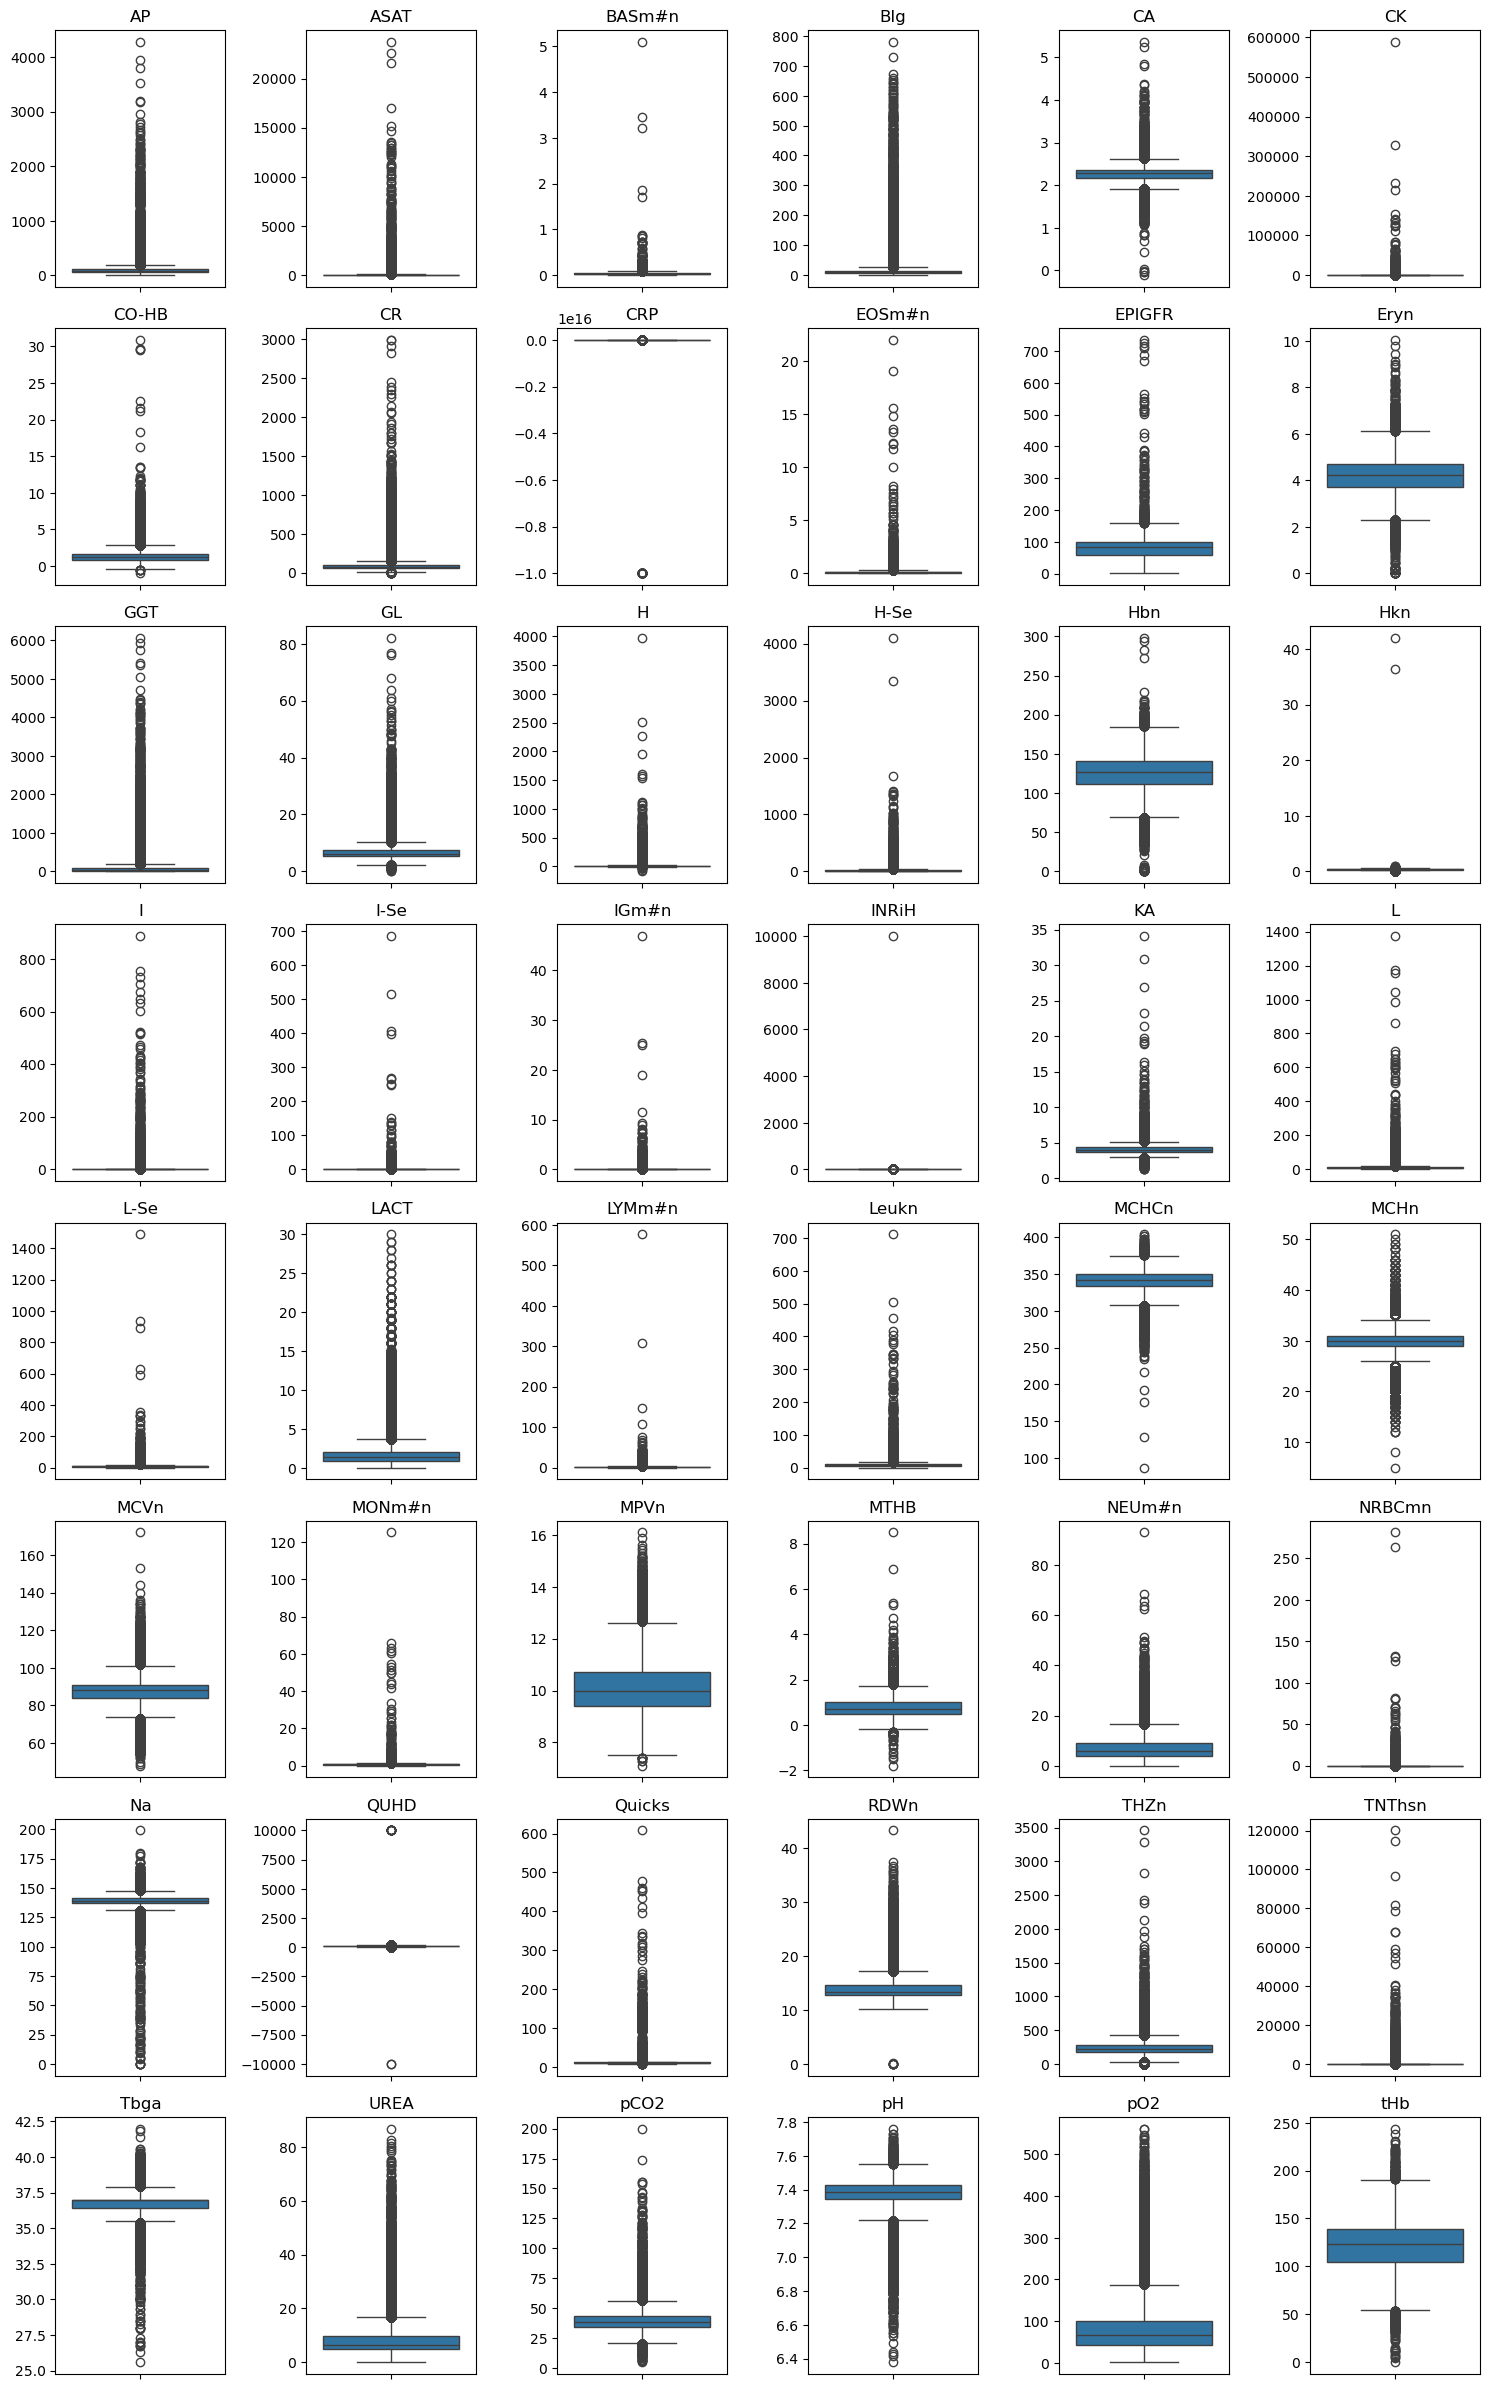

In [5]:
# Select lab test columns (starting from the 10th column)
lab_test_cols = merged_data.columns[9:]

# Dynamically determine subplot grid size
num_cols = len(lab_test_cols)
num_rows = math.ceil(num_cols / 6) 

plt.figure(figsize=(15, num_rows * 3))  # Scale figure height

for i in range(num_cols):
    plt.subplot(num_rows, 6, i + 1) 
    sns.boxplot(y=merged_data[lab_test_cols[i]])  
    plt.title(lab_test_cols[i]) 
    plt.ylabel('')

plt.tight_layout() 
plt.show()

In [6]:
pd.set_option('display.max_columns', None) # Diplay all the columns

In [7]:
def detect_extreme_outliers(df, columns, multiplier=3):
    """
    Detects extreme outliers in the given columns using the IQR method.
    
    Args:
        df (pd.DataFrame): The dataframe to analyze.
        columns (list): List of column names to check for outliers.
        multiplier (float): The multiplier for defining extreme outliers (default is 3 for very extreme).
        
    Returns:
        pd.DataFrame: A dataframe with all extreme outlier rows.
    """
    outlier_rows = pd.DataFrame()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        lower_outliers = df[df[col] < lower_bound].sort_values(by=col, ascending=True)
        upper_outliers = df[df[col] > upper_bound].sort_values(by=col, ascending=False)

        if not lower_outliers.empty:
            print(f"\nExtreme lower outliers detected in {col}:")
            display(lower_outliers)
        
        if not upper_outliers.empty:
            print(f"\nExtreme upper outliers detected in {col}:")
            display(upper_outliers)

        outlier_rows = pd.concat([outlier_rows, lower_outliers, upper_outliers])

    return outlier_rows.drop_duplicates()


In [8]:
# Example usage:
extreme_outliers = detect_extreme_outliers(merged_data, lab_test_cols)


Extreme upper outliers detected in AP:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
66148,63426,51027,Verstorben,f,52,6,C78.7,Neoplasms,57.0,4283.0,280.0,NaN,128.0,NaN,NaN,NaN,115.0,200.0,NaN,47.0,3.20,1053.0,1.07,4.0,NaN,81.0,0.28,9.0,NaN,NaN,1.35,4.1,19.0,NaN,9.3,NaN,3.83,303.0,25.0,83.0,NaN,11.0,NaN,NaN,2.1,128.0,52.4,14.5,22.8,152.0,NaN,37.0,NaN,28.0,7.237,38.0,NaN
87262,83626,378727,Entlassung,f,68,2,T85.51,Injury & poisoning,93.0,3956.0,86.0,0.07,15.0,2.35,NaN,NaN,56.0,7.0,0.00,92.0,3.63,838.0,10.64,20.0,21.0,90.0,0.26,1.0,1.0,0.09,1.10,3.3,18.0,48.0,1.3,3.13,10.20,344.0,29.0,82.0,0.87,10.1,NaN,6.12,0.2,137.0,77.8,12.0,20.1,527.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN
151626,145728,148832,Entl. in ex.KH,m,72,9,C79.5,Neoplasms,4.0,3803.0,36.0,0.01,11.0,2.05,NaN,NaN,39.0,167.0,0.04,112.0,2.64,129.0,5.27,1.0,0.0,89.0,0.24,1.0,1.0,NaN,1.38,3.2,25.0,6.0,NaN,0.71,5.96,313.0,29.0,92.0,0.39,7.5,NaN,3.74,NaN,137.0,52.7,NaN,16.1,263.0,NaN,NaN,3.2,NaN,NaN,NaN,NaN
169236,163047,256869,Entlassung,m,66,4,K83.1,Digestive diseases,209.0,3521.0,249.0,0.05,275.0,2.14,NaN,NaN,60.0,47.0,0.03,100.0,3.06,2770.0,4.54,3.0,NaN,88.0,0.25,18.0,NaN,0.04,1.25,4.4,40.0,NaN,0.7,0.56,6.41,331.0,29.0,87.0,0.66,11.5,NaN,5.38,0.1,132.0,60.5,13.1,16.4,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32878,31452,132149,Entlassung,f,68,10,C24.0,Neoplasms,38.0,3203.0,61.0,NaN,43.0,NaN,NaN,NaN,59.0,44.0,NaN,91.0,NaN,2747.0,5.80,2.0,NaN,NaN,NaN,50.0,NaN,NaN,1.06,3.6,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,87.9,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30414,29197,380742,Entlassung,f,85,2,R11,Symptoms & abnormal findings,28.0,265.0,45.0,0.03,9.0,2.20,NaN,NaN,37.0,9.0,0.02,94.0,3.57,266.0,6.16,NaN,NaN,112.0,0.33,NaN,NaN,NaN,1.04,3.5,NaN,NaN,NaN,0.44,4.23,341.0,31.0,92.0,0.25,9.7,NaN,3.49,NaN,135.0,94.6,NaN,14.1,210.0,NaN,NaN,2.1,NaN,NaN,NaN,NaN
24027,22930,299927,Verstorben,f,92,0,C18.7,Neoplasms,14.0,265.0,25.0,0.02,11.0,2.02,NaN,NaN,NaN,32.0,0.00,NaN,3.69,370.0,5.71,41.0,NaN,108.0,0.32,1.0,NaN,0.05,0.94,3.1,4.0,NaN,1.3,0.34,9.48,335.0,29.0,87.0,0.20,9.1,NaN,8.87,0.0,139.0,115.4,10.3,14.9,557.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170898,164712,189567,Entlassung,m,61,1,C22.0,Neoplasms,137.0,265.0,52.0,0.06,28.0,2.32,NaN,NaN,69.0,35.0,0.30,97.0,3.78,561.0,10.50,11.0,NaN,98.0,0.30,2.0,NaN,0.08,1.07,4.5,13.0,NaN,0.8,0.45,4.87,327.0,26.0,79.0,0.37,9.9,NaN,3.61,0.2,133.0,86.1,11.4,17.6,326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62277,59703,60834,Entl.ext.Instit,m,90,10,A46,Infectious diseases,14.0,265.0,41.0,0.06,3.0,2.18,NaN,NaN,162.0,312.0,0.15,29.0,3.29,263.0,8.50,10.0,9.0,95.0,0.34,0.0,0.0,0.69,1.97,3.8,7.0,3.0,1.7,0.70,11.70,325.0,29.0,89.0,0.99,9.2,NaN,9.04,0.2,139.0,46.6,15.1,15.7,492.0,NaN,NaN,10.9,NaN,NaN,NaN,NaN



Extreme upper outliers detected in ASAT:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
175402,169071,332397,Verstorben,m,59,0,T82.8,Injury & poisoning,8857.0,NaN,23743.0,0.05,50.0,NaN,1499.0,0.7,85.0,25.0,0.01,86.0,3.45,42.0,0.3,40.0,NaN,114.0,0.34,4.0,NaN,0.17,NaN,5.8,12.0,NaN,16.0,0.70,13.80,334.0,33.0,99.0,0.79,10.4,0.9,12.09,0.2,140.0,NaN,NaN,12.5,57.0,328.0,37.0,5.4,27.0,7.141,84.0,84.0
44244,42485,206496,Entl. in ex.KH,m,51,8,I23.5,Circulatory diseases,3265.0,NaN,22589.0,NaN,34.0,NaN,702.0,0.2,252.0,141.0,NaN,24.0,2.63,130.0,5.8,91.0,NaN,88.0,0.32,2.0,NaN,NaN,1.65,4.3,9.0,NaN,4.2,NaN,15.20,359.0,34.0,96.0,NaN,11.4,1.3,NaN,0.2,137.0,41.1,22.5,12.5,161.0,NaN,35.1,16.3,38.0,7.356,36.0,91.0
220319,211585,5583,Entl. in ex.KH,f,46,6,K72.0,Digestive diseases,4709.0,169.0,21617.0,NaN,68.0,NaN,294.0,0.9,204.0,15.0,NaN,NaN,NaN,124.0,10.8,5.0,NaN,NaN,NaN,56.0,NaN,NaN,NaN,3.5,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,37.2,8.1,38.0,NaN,87.0,116.0
176203,169895,148574,Entl. in ex.KH,f,75,1,I50.01,Circulatory diseases,4495.0,NaN,16969.0,NaN,28.0,NaN,159.0,0.6,196.0,107.0,NaN,21.0,3.83,64.0,7.2,50.0,NaN,132.0,0.35,2.0,NaN,NaN,1.58,4.2,8.0,NaN,14.0,NaN,26.00,308.0,32.0,90.0,NaN,10.2,0.3,NaN,6.1,134.0,36.9,17.3,12.5,204.0,149.0,34.8,14.3,38.0,7.486,80.0,112.0
200283,192877,295171,Verstorben,f,33,11,I46.0,Circulatory diseases,8127.0,NaN,15186.0,NaN,25.0,NaN,234.0,0.7,105.0,31.0,NaN,66.0,4.59,44.0,5.4,8.0,NaN,94.0,0.40,2.0,NaN,NaN,1.59,3.5,9.0,NaN,3.5,NaN,10.60,311.0,26.0,78.0,NaN,10.2,0.8,NaN,0.1,139.0,41.7,17.9,14.6,205.0,63.6,36.7,9.0,27.0,7.450,76.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128289,122973,289337,Verstorben,m,86,3,I50.01,Circulatory diseases,351.0,346.0,100.0,NaN,13.0,NaN,NaN,NaN,188.0,36.0,NaN,27.0,3.89,165.0,NaN,3.0,5.0,118.0,0.39,1.0,1.0,NaN,1.21,4.4,4.0,2.0,NaN,NaN,13.70,299.0,30.0,101.0,NaN,11.5,NaN,NaN,0.9,164.0,64.0,NaN,17.0,199.0,NaN,NaN,29.4,NaN,NaN,NaN,NaN
91509,87757,141148,Entl.ext.Instit,m,34,1,F10.4,Mental disorders,64.0,61.0,100.0,0.05,17.0,2.49,563.0,NaN,93.0,16.0,0.13,92.0,3.86,368.0,4.7,17.0,11.0,133.0,0.38,1.0,1.0,0.06,0.92,3.1,6.0,2.0,2.2,1.98,7.01,349.0,34.0,99.0,1.03,11.3,NaN,3.76,0.1,134.0,125.7,9.8,11.8,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7543,7178,360805,Entl. in ex.KH,f,65,6,I63.8,Circulatory diseases,31.0,NaN,100.0,NaN,3.0,2.09,3482.0,1.2,60.0,27.0,NaN,92.0,3.69,11.0,7.1,6.0,8.0,104.0,0.30,0.0,1.0,NaN,1.10,4.7,9.0,2.0,0.7,NaN,9.58,338.0,31.0,90.0,NaN,10.2,0.4,NaN,0.0,134.0,77.8,11.5,12.7,231.0,70.8,36.2,8.0,46.0,7.416,82.0,105.0
157939,151789,111144,Entlassung,f,29,21,O72.1,Pregnancy & childbirth,10.0,NaN,100.0,0.02,7.0,NaN,396.0,1.6,80.0,12.0,0.03,86.0,2.20,9.0,5.1,10.0,15.0,61.0,0.18,1.0,1.0,0.12,1.01,4.3,1.0,4.0,1.9,0.82,15.00,358.0,30.0,83.0,0.73,10.2,0.5,13.31,0.1,131.0,97.9,11.0,15.6,41.0,121.0,36.6,3.1,44.0,7.240,85.0,74.0



Extreme upper outliers detected in BASm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
125113,119859,294343,Entlassung,m,38,4,C92.10,Neoplasms,101.0,64.0,49.0,5.10,8.0,2.34,NaN,NaN,100.0,2.0,1.43,90.0,3.78,36.0,7.20,29.0,NaN,118.0,0.35,1.0,NaN,46.89,1.02,3.8,10.0,NaN,1.5,8.57,134.00,334.0,28.0,86.0,2.04,9.9,NaN,93.06,0.8,142.0,96.2,10.7,16.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204352,196682,45078,Entlassung,m,47,2,C92.10,Neoplasms,48.0,NaN,NaN,3.46,11.0,2.37,264.0,NaN,84.0,NaN,1.10,95.0,4.15,42.0,5.80,11.0,9.0,123.0,0.37,1.0,1.0,25.49,1.06,3.8,11.0,10.0,2.0,5.51,86.10,338.0,30.0,87.0,3.63,10.3,NaN,46.99,0.5,138.0,87.0,11.1,17.6,164.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN
188941,182019,300766,Entlassung,m,46,3,C92.10,Neoplasms,39.0,82.0,41.0,3.21,9.0,2.20,NaN,NaN,60.0,15.0,0.81,102.0,3.66,95.0,7.90,8.0,NaN,126.0,0.33,1.0,NaN,24.91,1.11,3.1,20.0,NaN,5.1,3.71,102.00,369.0,35.0,95.0,4.77,11.6,NaN,65.55,0.0,125.0,69.9,12.0,14.2,235.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN
119539,114554,361777,Entlassung,f,43,3,C92.10,Neoplasms,18.0,64.0,22.0,1.87,9.0,2.20,NaN,NaN,57.0,257.0,0.29,109.0,3.80,37.0,6.95,8.0,NaN,108.0,0.33,1.0,NaN,19.08,1.29,3.8,3.0,NaN,NaN,2.08,89.70,331.0,28.0,86.0,2.91,11.3,NaN,63.55,0.2,140.0,57.2,13.5,15.4,324.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
251965,233326,413613,Entlassung,m,71,3,N20.0,Genitourinary diseases,NaN,NaN,NaN,1.71,NaN,2.39,NaN,NaN,92.0,0.0,0.74,72.0,4.81,NaN,NaN,27.0,NaN,145.0,0.44,1.0,NaN,6.52,1.08,5.0,48.0,NaN,NaN,3.48,26.10,330.0,30.0,92.0,0.56,9.5,NaN,13.18,0.1,142.0,83.7,11.2,16.4,824.0,NaN,37.0,9.0,41.0,7.406,43.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182152,175552,294230,Entlassung,f,71,3,C34.3,Neoplasms,38.0,1383.0,57.0,0.15,5.0,1.88,18.0,NaN,53.0,87.0,0.82,92.0,3.35,927.0,8.60,7.0,NaN,102.0,0.32,0.0,NaN,0.80,1.09,3.7,9.0,NaN,1.7,0.41,32.70,324.0,30.0,94.0,0.87,10.3,NaN,29.65,0.1,141.0,82.0,11.5,19.0,180.0,24.4,NaN,NaN,NaN,NaN,NaN,NaN
184854,178177,130962,Entlassung,f,77,1,C83.3,Neoplasms,15.0,83.0,15.0,0.15,NaN,2.13,NaN,NaN,55.0,NaN,0.03,87.0,3.46,27.0,5.53,6.0,NaN,102.0,0.29,1.0,NaN,0.58,NaN,3.8,7.0,NaN,NaN,0.37,10.50,347.0,30.0,85.0,0.60,10.3,NaN,8.85,0.2,140.0,NaN,NaN,18.5,210.0,NaN,NaN,4.6,NaN,NaN,NaN,NaN
186019,179218,378662,Entlassung,f,66,6,M54.87,Musculoskeletal diseases,NaN,NaN,NaN,0.15,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,3.98,NaN,NaN,NaN,NaN,122.0,0.35,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,1.90,5.92,347.0,31.0,88.0,0.69,11.0,NaN,2.92,0.0,NaN,NaN,NaN,13.1,161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51137,48976,176668,Entlassung,m,85,6,I50.01,Circulatory diseases,36.0,201.0,61.0,0.15,14.0,2.29,428.0,NaN,219.0,26.0,6.32,22.0,4.07,694.0,5.70,20.0,54.0,127.0,0.38,1.0,1.0,0.06,1.37,4.8,6.0,4.0,2.4,1.66,12.10,329.0,31.0,95.0,0.77,11.0,NaN,3.14,0.1,145.0,51.7,14.4,15.9,156.0,228.0,NaN,19.2,NaN,NaN,NaN,NaN



Extreme upper outliers detected in BIg:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
82602,79110,82052,Verstorben,f,72,1,K71.0,Digestive diseases,28.0,26.0,228.0,NaN,781.0,2.39,165.0,1.7,148.0,22.0,NaN,20.0,1.39,178.0,5.79,107.0,78.0,56.0,0.17,64.0,66.0,NaN,3.81,5.8,54.0,53.0,3.1,NaN,17.40,326.0,33.0,92.0,NaN,10.9,1.5,NaN,1.6,139.0,18.1,35.3,14.8,100.0,51.3,36.2,17.9,33.0,7.325,77.0,46.0
48496,46573,150052,Entl. in ex.KH,m,66,3,K74.6,Digestive diseases,1507.0,1384.0,8628.0,0.05,729.0,2.38,50.0,1.5,199.0,35.0,0.04,23.0,4.33,282.0,9.30,2.0,52.0,145.0,0.40,59.0,58.0,0.26,2.08,4.1,32.0,26.0,10.8,0.46,8.48,360.0,33.0,92.0,0.98,13.5,0.4,6.69,0.0,130.0,31.1,29.2,21.7,120.0,NaN,34.8,16.5,25.0,7.277,79.0,142.0
149903,144086,368314,Entl. in ex.KH,f,60,6,C22.1,Neoplasms,393.0,1901.0,531.0,NaN,674.0,NaN,NaN,NaN,98.0,NaN,NaN,54.0,3.10,958.0,NaN,0.0,NaN,96.0,0.26,54.0,NaN,NaN,1.13,4.1,34.0,NaN,NaN,NaN,11.60,364.0,31.0,85.0,NaN,8.2,NaN,NaN,0.0,122.0,74.8,11.9,19.8,130.0,NaN,NaN,10.3,NaN,NaN,NaN,NaN
61569,58980,4536,Verstorben,m,66,14,K70.3,Digestive diseases,34.0,126.0,60.0,NaN,660.0,2.14,NaN,NaN,206.0,12.0,NaN,27.0,NaN,28.0,9.50,0.0,NaN,NaN,NaN,888.0,NaN,NaN,1.55,4.1,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,43.1,NaN,NaN,NaN,NaN,37.0,15.9,26.0,7.306,37.0,NaN
152018,146113,26896,Entl. in ex.KH,m,75,3,C19,Neoplasms,50.0,383.0,65.0,0.10,653.0,1.88,NaN,NaN,153.0,55.0,0.20,33.0,2.32,196.0,NaN,0.0,0.0,58.0,0.16,50.0,53.0,0.12,1.19,2.9,29.0,33.0,NaN,0.17,10.20,371.0,38.0,102.0,0.64,11.1,NaN,5.99,0.0,136.0,63.2,12.8,15.0,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29541,28361,375764,Entlassung,m,70,2,C22.0,Neoplasms,100.0,552.0,339.0,NaN,39.0,NaN,NaN,NaN,173.0,26.0,NaN,34.0,3.78,422.0,NaN,5.0,13.0,114.0,0.32,3.0,4.0,NaN,1.20,4.7,13.0,22.0,NaN,NaN,9.53,336.0,30.0,92.0,NaN,10.2,NaN,NaN,0.0,143.0,65.0,12.4,17.2,266.0,NaN,NaN,13.8,NaN,NaN,NaN,NaN
179647,173051,263007,Entl.ext.Instit,m,68,30,I50.14,Circulatory diseases,21.0,114.0,39.0,0.02,39.0,2.43,NaN,2.5,252.0,133.0,0.00,22.0,3.24,279.0,7.20,4.0,2.0,97.0,0.29,2.0,3.0,0.10,1.87,4.2,11.0,6.0,0.8,0.41,8.07,316.0,29.0,90.0,0.92,11.0,0.7,15.73,0.1,137.0,27.4,18.9,27.8,111.0,NaN,35.0,28.3,42.0,7.390,111.0,96.0
73225,70147,64859,Entl. in ex.KH,f,80,0,K80.30,Digestive diseases,697.0,226.0,429.0,0.03,39.0,2.38,NaN,NaN,84.0,200.0,0.10,57.0,3.63,1034.0,10.94,5.0,NaN,113.0,0.32,3.0,NaN,0.03,1.09,3.5,23.0,NaN,NaN,1.13,10.00,352.0,31.0,88.0,0.48,9.6,NaN,8.29,NaN,133.0,86.6,111.0,13.1,193.0,NaN,NaN,9.6,NaN,NaN,NaN,119.0
180295,173691,214409,Entlassung,m,84,5,I50.14,Circulatory diseases,29.0,167.0,32.0,NaN,39.0,NaN,NaN,NaN,93.0,12.0,NaN,65.0,4.41,290.0,6.99,181.0,NaN,145.0,0.42,3.0,NaN,NaN,1.38,4.7,6.0,NaN,NaN,NaN,5.15,347.0,33.0,95.0,NaN,11.7,NaN,NaN,0.0,140.0,50.6,14.8,15.6,138.0,79.6,NaN,7.5,NaN,NaN,NaN,NaN



Extreme lower outliers detected in CA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
247483,231400,405775,Entlassung,f,78,4,C54.1,Neoplasms,NaN,NaN,24.0,0.02,10.0,-0.11,NaN,NaN,65.0,1.0,0.06,80.0,4.54,62.0,4.83,14.0,NaN,125.0,0.37,1.0,NaN,0.03,1.09,4.0,8.0,NaN,NaN,1.47,6.10,341.0,28.0,81.0,0.45,9.4,NaN,4.07,0.0,135.0,83.3,11.8,13.3,188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76707,73350,351582,Entl. in ex.KH,m,62,2,I63.5,Circulatory diseases,NaN,NaN,17.0,NaN,NaN,-0.04,120.0,NaN,54.0,1.0,NaN,107.0,4.75,35.0,4.90,10.0,6.0,148.0,0.44,1.0,1.0,NaN,1.04,4.1,7.0,9.0,1.1,NaN,7.16,336.0,31.0,93.0,NaN,9.0,NaN,NaN,0.0,138.0,91.5,11.1,12.4,301.0,7.33,37.0,5.6,NaN,7.410,NaN,NaN
95616,91617,184151,Entlassung,m,80,3,C15.5,Neoplasms,44.0,93.0,39.0,NaN,NaN,-0.03,NaN,NaN,147.0,0.0,NaN,38.0,3.97,36.0,8.20,7.0,NaN,118.0,0.34,1.0,NaN,NaN,1.14,4.4,13.0,NaN,NaN,NaN,6.88,345.0,30.0,87.0,NaN,9.0,NaN,NaN,0.0,133.0,73.9,12.4,12.5,188.0,NaN,NaN,8.7,NaN,NaN,NaN,NaN
93826,89815,149807,Entlassung,m,70,10,A41.9,Infectious diseases,NaN,486.0,20.0,NaN,94.0,-0.02,NaN,NaN,243.0,157.0,NaN,22.0,2.58,NaN,NaN,8.0,NaN,65.0,0.22,6.0,NaN,NaN,NaN,3.9,23.0,NaN,NaN,NaN,19.30,341.0,29.0,83.0,NaN,NaN,NaN,NaN,0.3,131.0,NaN,NaN,23.6,68.0,NaN,37.0,40.4,25.0,7.333,25.0,NaN
5613,5373,278026,Entlassung,f,89,4,K52.8,Digestive diseases,11.0,19.0,24.0,NaN,13.0,0.04,42.0,1.0,218.0,1.0,NaN,27.0,4.57,14.0,4.60,34.0,NaN,125.0,0.37,1.0,NaN,NaN,1.06,5.3,13.0,NaN,2.6,NaN,8.31,334.0,30.0,87.0,NaN,10.3,0.5,NaN,0.0,140.0,88.4,11.3,12.6,221.0,NaN,37.0,26.7,41.0,7.345,20.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213768,205599,386047,Verstorben,m,46,2,A41.51,Infectious diseases,460.0,NaN,1375.0,NaN,6.0,1.64,312.0,0.5,149.0,179.0,NaN,81.0,3.65,32.0,4.80,18.0,NaN,113.0,0.31,1.0,NaN,NaN,1.30,4.1,7.0,NaN,6.2,NaN,1.04,366.0,33.0,97.0,NaN,9.1,0.7,NaN,0.9,129.0,87.5,11.5,14.6,80.0,9.85,36.2,8.9,51.0,7.078,72.0,114.0
108120,103585,90397,Entlassung,m,71,2,T82.8,Injury & poisoning,NaN,NaN,NaN,0.03,NaN,1.64,NaN,NaN,990.0,26.0,0.27,4.0,3.26,NaN,NaN,9.0,NaN,115.0,0.33,0.0,NaN,0.03,1.03,5.9,10.0,NaN,NaN,2.28,7.88,344.0,35.0,102.0,0.61,10.0,NaN,4.66,0.0,132.0,94.6,10.9,13.5,130.0,NaN,37.0,37.9,29.0,7.220,59.0,NaN
129496,124112,193022,Entlassung,m,68,4,N30.2,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,1.64,NaN,NaN,386.0,9.0,NaN,13.0,3.69,NaN,NaN,7.0,NaN,114.0,0.34,1.0,NaN,NaN,1.16,5.1,12.0,NaN,NaN,NaN,11.60,334.0,31.0,92.0,NaN,11.2,NaN,NaN,0.0,145.0,71.4,12.3,15.0,279.0,NaN,NaN,31.5,NaN,NaN,NaN,NaN
171031,164842,228951,Entl. in ex.KH,m,81,7,E83.4,Endocrine & metabolic,12.0,95.0,15.0,NaN,13.0,1.64,303.0,NaN,137.0,23.0,NaN,41.0,3.58,28.0,7.68,9.0,NaN,123.0,0.36,1.0,NaN,NaN,1.51,3.8,8.0,NaN,NaN,NaN,12.30,345.0,35.0,99.0,NaN,11.8,NaN,NaN,0.0,142.0,45.6,16.3,13.2,172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in CA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
24946,23849,235335,Verstorben,f,57,1,R57.2,Symptoms & abnormal findings,56.0,NaN,97.0,NaN,59.0,5.37,355.0,1.3,205.0,NaN,NaN,33.0,4.09,NaN,4.90,16.0,NaN,123.0,0.37,5.0,NaN,NaN,1.38,4.1,6.0,NaN,5.2,NaN,20.40,336.0,30.0,90.0,NaN,10.9,0.7,NaN,0.3,140.0,51.1,14.1,14.6,162.0,555.0,34.8,11.7,64.0,7.213,68.0,113.0
94534,90504,51870,Entl. in ex.KH,m,71,12,C61,Neoplasms,15.0,54.0,113.0,0.03,13.0,5.24,NaN,1.9,113.0,67.0,0.10,75.0,2.43,21.0,6.47,8.0,NaN,67.0,0.19,0.0,NaN,1.30,1.10,3.8,4.0,NaN,1.2,0.65,10.90,358.0,30.0,83.0,0.61,10.7,0.8,7.48,1.0,146.0,80.1,12.4,14.6,85.0,NaN,37.0,NaN,41.0,7.365,106.0,69.0
248319,231775,409023,Entl. in ex.KH,m,45,4,M89.58,Musculoskeletal diseases,16.0,129.0,18.0,NaN,6.0,4.85,NaN,NaN,NaN,6.0,NaN,NaN,3.23,72.0,4.83,NaN,3.0,102.0,0.27,NaN,1.0,NaN,1.17,3.3,NaN,3.0,NaN,NaN,5.05,361.0,31.0,87.0,NaN,10.0,NaN,NaN,NaN,139.0,71.1,NaN,12.5,243.0,NaN,NaN,13.4,NaN,NaN,NaN,101.0
194096,186819,16410,Entl. in ex.KH,f,75,10,C50.9,Neoplasms,48.0,110.0,62.0,NaN,19.0,4.79,NaN,NaN,257.0,129.0,NaN,15.0,3.24,143.0,6.80,25.0,29.0,113.0,0.31,1.0,2.0,NaN,1.35,4.6,11.0,6.0,1.9,NaN,7.62,320.0,30.0,91.0,NaN,11.8,NaN,NaN,2.5,136.0,54.0,NaN,16.4,89.0,NaN,NaN,18.3,NaN,NaN,NaN,NaN
8149,7708,197748,Entlassung,f,58,5,C91.10,Neoplasms,12.0,NaN,NaN,NaN,10.0,4.37,NaN,NaN,72.0,29.0,NaN,80.0,4.84,21.0,NaN,4.0,13.0,139.0,0.42,1.0,1.0,NaN,1.13,3.3,12.0,6.0,NaN,NaN,22.60,333.0,29.0,86.0,NaN,11.8,NaN,NaN,0.0,139.0,76.2,12.0,14.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127749,122430,385840,Entl. in ex.KH,m,84,10,E83.58,Endocrine & metabolic,6.0,41.0,10.0,0.02,3.0,2.90,NaN,1.0,162.0,9.0,0.28,33.0,4.21,81.0,5.50,6.0,10.0,113.0,0.36,0.0,0.0,0.04,1.00,4.6,10.0,7.0,1.1,1.61,10.70,340.0,29.0,85.0,1.11,12.2,1.1,7.65,0.0,131.0,103.0,10.9,15.4,155.0,NaN,37.0,NaN,42.0,7.301,31.0,123.0
86999,83388,160128,Entl. in ex.KH,m,61,1,C43.7,Neoplasms,17.0,194.0,40.0,0.02,11.0,2.90,NaN,NaN,70.0,225.0,0.07,97.0,5.14,147.0,14.40,5.0,30.0,157.0,0.46,1.0,1.0,1.30,1.18,4.3,10.0,2.0,NaN,1.85,15.10,348.0,30.0,89.0,0.87,9.9,NaN,11.07,0.2,134.0,67.6,12.6,13.0,206.0,NaN,NaN,9.8,NaN,NaN,NaN,164.0
10286,9738,117941,Entl. in ex.KH,f,70,3,A08.4,Infectious diseases,17.0,108.0,19.0,0.02,7.0,2.90,NaN,NaN,83.0,82.0,0.02,62.0,4.52,22.0,8.70,8.0,12.0,124.0,0.34,1.0,1.0,0.04,0.97,3.6,6.0,4.0,1.5,0.80,7.40,359.0,28.0,76.0,0.68,10.1,NaN,5.84,0.0,134.0,110.1,10.3,12.8,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88790,85092,74076,Entl. in ex.KH,m,76,5,K75.0,Digestive diseases,56.0,480.0,64.0,0.04,6.0,2.90,NaN,NaN,74.0,102.0,0.54,85.0,3.45,3343.0,5.97,3.0,4.0,105.0,0.32,0.0,1.0,0.03,0.95,3.8,11.0,2.0,NaN,0.70,10.30,326.0,30.0,93.0,0.96,10.2,NaN,8.07,0.0,138.0,112.8,10.2,15.6,429.0,NaN,NaN,5.5,NaN,NaN,NaN,NaN



Extreme upper outliers detected in CK:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
16574,15785,111849,Entlassung,f,23,11,M62.80,Musculoskeletal diseases,1399.0,63.0,4701.0,0.10,6.0,NaN,589210.0,1.2,43.0,141.0,0.09,145.0,5.81,48.0,8.80,20.0,12.0,167.0,0.50,1.0,1.0,0.32,1.27,3.7,2.0,3.0,3.3,2.31,22.70,351.0,28.0,81.0,0.61,11.1,0.5,27.62,0.0,128.0,59.7,13.8,14.2,304.0,5.59,36.1,2.4,29.0,7.512,86.0,169.0
238133,227135,410762,Entl.ext.Instit,m,37,57,T82.5,Injury & poisoning,263.0,NaN,2005.0,NaN,13.0,NaN,327320.0,1.3,82.0,NaN,NaN,NaN,NaN,NaN,6.60,9.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,5.7,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,36.0,5.0,41.0,NaN,240.0,74.0
18622,17725,85564,Entl. in ex.KH,m,57,9,I71.03,Circulatory diseases,591.0,39.0,1827.0,NaN,7.0,NaN,232020.0,0.1,114.0,1.0,NaN,45.0,3.87,9.0,8.20,12.0,NaN,112.0,0.32,0.0,NaN,NaN,1.25,4.0,10.0,NaN,5.1,NaN,11.20,344.0,32.0,97.0,NaN,9.6,0.9,NaN,0.0,139.0,42.7,12.0,15.3,130.0,3769.00,37.1,9.3,23.0,7.180,32.0,90.0
34631,33171,121988,Verstorben,m,51,3,I71.03,Circulatory diseases,823.0,NaN,3226.0,0.01,NaN,NaN,214062.0,0.7,198.0,NaN,0.03,33.0,2.94,NaN,9.10,31.0,NaN,91.0,0.27,3.0,NaN,0.12,1.66,5.1,12.0,NaN,5.3,0.98,10.00,360.0,31.0,86.0,0.13,9.9,1.1,3.96,0.2,135.0,39.5,16.3,13.3,66.0,NaN,36.0,12.1,41.0,7.198,36.0,91.0
222479,213649,296743,Entl. in ex.KH,f,42,47,A40.0,Infectious diseases,230.0,NaN,334.0,NaN,3.0,1.52,154812.0,0.6,187.0,213.0,NaN,28.0,3.44,11.0,3.50,16.0,NaN,99.0,0.32,1.0,NaN,NaN,2.11,4.3,1.0,NaN,7.2,NaN,2.73,350.0,29.0,81.0,NaN,10.5,1.1,NaN,0.0,127.0,24.1,20.8,14.0,10.0,243.00,35.0,8.8,38.0,6.940,47.0,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255808,235033,400175,Entlassung,m,62,7,I34.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,550.0,1.6,74.0,1.0,NaN,94.0,5.04,NaN,6.03,29.0,NaN,153.0,0.43,1.0,NaN,NaN,0.99,3.7,14.0,NaN,1.8,NaN,7.52,354.0,30.0,86.0,NaN,10.9,1.2,NaN,0.0,142.0,102.5,10.8,12.8,279.0,NaN,35.9,NaN,42.0,7.360,63.0,131.0
102929,98538,117660,Entl. in ex.KH,m,47,10,S33.4,Injury & poisoning,25.0,NaN,36.0,NaN,6.0,NaN,550.0,0.8,110.0,2.0,NaN,69.0,4.88,24.0,7.10,11.0,NaN,148.0,0.45,1.0,NaN,NaN,1.02,4.2,9.0,NaN,1.2,NaN,17.00,331.0,30.0,92.0,NaN,10.3,1.1,NaN,0.0,141.0,98.4,10.9,13.3,213.0,4.10,37.0,6.0,49.0,7.359,60.0,137.0
130823,125410,106267,Entlassung,f,76,5,I26.0,Circulatory diseases,1976.0,NaN,3147.0,0.02,12.0,2.27,550.0,0.3,116.0,90.0,0.00,40.0,4.32,53.0,11.50,7.0,NaN,134.0,0.37,1.0,NaN,0.15,1.49,4.8,9.0,NaN,5.2,2.52,18.40,345.0,31.0,87.0,0.71,8.9,0.5,13.79,0.1,142.0,46.6,15.6,13.8,34.0,691.00,37.0,16.7,24.0,7.362,34.0,134.0
99326,95125,325206,Entlassung,m,72,8,F51.3,Mental disorders,NaN,NaN,NaN,NaN,NaN,2.20,550.0,NaN,82.0,4.0,NaN,82.0,4.03,NaN,4.70,15.0,NaN,137.0,0.39,3.0,NaN,NaN,1.27,3.5,3.0,NaN,NaN,NaN,7.93,351.0,34.0,97.0,NaN,9.7,NaN,NaN,0.0,140.0,59.1,13.3,13.2,207.0,13.20,NaN,7.9,NaN,NaN,NaN,NaN



Extreme upper outliers detected in CO-HB:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
54532,52185,295484,Entl. in ex.KH,m,48,0,T58,Injury & poisoning,41.0,56.0,33.0,0.02,3.0,2.50,442.0,30.9,86.0,0.0,0.08,92.0,4.89,29.0,6.05,12.0,NaN,146.0,0.42,0.0,NaN,0.00,1.01,3.3,36.0,NaN,NaN,2.18,7.45,347.0,30.0,86.0,0.63,11.1,0.9,4.54,NaN,140.0,100.8,11.1,12.6,191.0,NaN,NaN,5.8,NaN,NaN,NaN,147.0
54976,52634,170016,Entl. in ex.KH,m,47,0,T58,Injury & poisoning,22.0,NaN,25.0,NaN,6.0,NaN,235.0,29.7,83.0,1.0,NaN,96.0,4.73,19.0,10.10,18.0,NaN,144.0,0.41,1.0,NaN,NaN,1.04,3.8,7.0,NaN,3.3,NaN,11.70,351.0,30.0,87.0,NaN,9.8,1.2,NaN,0.0,138.0,93.2,11.1,12.1,200.0,6.34,35.7,5.9,31.0,7.465,191.0,146.0
84095,80581,244479,Entl. in ex.KH,m,69,0,I46.0,Circulatory diseases,150.0,NaN,175.0,NaN,5.0,NaN,155.0,29.6,148.0,2.0,NaN,28.0,4.50,90.0,20.30,235.0,NaN,147.0,0.46,0.0,NaN,NaN,1.57,4.3,48.0,NaN,11.7,NaN,19.90,321.0,33.0,102.0,NaN,10.3,3.9,NaN,0.1,133.0,42.3,16.5,12.3,256.0,NaN,36.8,6.5,65.0,6.723,109.0,148.0
76636,73277,180336,Entl. in ex.KH,m,41,0,T58,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.5,82.0,1.0,NaN,102.0,5.53,NaN,6.10,22.0,NaN,164.0,0.47,1.0,NaN,NaN,1.07,3.8,13.0,NaN,1.6,NaN,7.15,347.0,30.0,86.0,NaN,11.5,1.2,NaN,0.0,141.0,85.9,11.3,13.2,181.0,4.85,36.5,NaN,37.0,7.416,243.0,163.0
1870,1708,120421,Entlassung,m,58,1,C78.0,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.6,NaN,NaN,NaN,NaN,3.87,NaN,NaN,NaN,NaN,129.0,0.39,NaN,NaN,NaN,1.14,NaN,NaN,NaN,NaN,NaN,5.43,332.0,32.0,93.0,NaN,9.0,8.5,NaN,0.0,NaN,71.0,12.4,13.2,516.0,NaN,37.0,NaN,44.0,7.394,19.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161860,155514,330220,Entlassung,f,71,1,S40.0,Injury & poisoning,25.0,65.0,37.0,0.05,3.0,2.27,210.0,4.1,64.0,1.0,0.07,84.0,4.43,30.0,5.62,3.0,NaN,135.0,0.41,1.0,NaN,NaN,1.01,5.1,6.0,NaN,NaN,1.54,6.21,328.0,30.0,93.0,0.45,8.7,0.4,4.09,NaN,135.0,98.5,10.6,12.8,299.0,NaN,NaN,5.0,NaN,NaN,NaN,144.0
101028,96771,383570,Entlassung,m,66,16,C04.8,Neoplasms,13.0,77.0,17.0,NaN,NaN,2.43,NaN,4.1,57.0,26.0,NaN,102.0,3.82,25.0,6.61,8.0,9.0,126.0,0.36,0.0,0.0,NaN,1.02,5.7,20.0,16.0,1.4,NaN,10.20,346.0,33.0,95.0,NaN,8.3,1.3,NaN,0.0,135.0,98.4,10.9,11.9,287.0,NaN,36.9,4.9,49.0,7.370,99.0,120.0
100982,96721,204058,Entlassung,f,66,6,K43.2,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,9.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,43.0,7.310,74.0,145.0
224832,215838,103802,Entlassung,m,72,8,J44.09,Respiratory diseases,13.0,78.0,22.0,0.08,7.0,1.94,NaN,4.1,164.0,94.0,0.13,36.0,5.27,23.0,5.57,9.0,NaN,143.0,0.43,1.0,NaN,0.05,1.11,2.3,15.0,NaN,NaN,0.53,13.70,329.0,27.0,82.0,0.93,9.4,0.8,12.03,NaN,139.0,81.3,12.1,14.1,438.0,NaN,NaN,5.6,NaN,NaN,NaN,135.0



Extreme upper outliers detected in CR:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
237271,226765,420687,Entlassung,m,29,5,N18.5,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,2.23,NaN,NaN,2995.0,NaN,NaN,1.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,37.0,47.9,42.0,7.397,28.0,NaN
237268,226765,418640,Entlassung,m,28,4,K21.0,Digestive diseases,NaN,NaN,NaN,NaN,NaN,1.65,NaN,NaN,2994.0,5.0,NaN,1.0,3.60,NaN,NaN,5.0,NaN,98.0,0.29,1.0,NaN,NaN,NaN,4.6,7.0,NaN,NaN,NaN,10.10,340.0,27.0,80.0,NaN,11.3,NaN,NaN,0.0,136.0,NaN,NaN,15.6,207.0,NaN,NaN,45.4,NaN,NaN,NaN,NaN
237255,226765,398686,Entl.ext.Instit,m,28,8,N18.5,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,1.97,NaN,NaN,2920.0,2.0,NaN,1.0,4.61,NaN,NaN,6.0,11.0,127.0,0.37,1.0,1.0,NaN,1.08,4.5,10.0,7.0,NaN,NaN,5.10,347.0,28.0,79.0,NaN,11.6,NaN,NaN,0.2,135.0,86.1,11.4,16.4,311.0,NaN,37.0,48.6,37.0,7.354,63.0,NaN
237254,226765,397832,Entlassung,m,29,15,N18.5,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,2.46,474.0,NaN,2821.0,11.0,NaN,2.0,2.85,NaN,6.0,4.0,4.0,79.0,0.22,1.0,1.0,NaN,1.09,6.5,7.0,3.0,NaN,NaN,5.58,326.0,26.0,78.0,NaN,10.1,NaN,NaN,0.4,132.0,83.3,11.8,18.9,305.0,NaN,37.0,65.9,38.0,7.362,44.0,NaN
237263,226765,409033,Entlassung,m,28,3,N18.5,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,1.74,NaN,NaN,2452.0,NaN,NaN,2.0,3.64,NaN,6.4,11.0,NaN,97.0,0.28,1.0,NaN,NaN,2.05,5.6,17.0,NaN,NaN,NaN,5.37,342.0,27.0,78.0,NaN,11.1,NaN,NaN,0.0,125.0,31.5,21.0,17.2,164.0,NaN,37.0,44.6,40.0,7.303,46.0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254200,234287,397664,Entl. in ex.KH,m,73,2,A41.9,Infectious diseases,68.0,NaN,NaN,NaN,NaN,NaN,NaN,1.2,208.0,179.0,NaN,26.0,3.33,NaN,8.8,6.0,NaN,93.0,0.27,2.0,NaN,NaN,1.22,4.1,6.0,NaN,5.1,NaN,14.60,331.0,26.0,80.0,NaN,11.7,1.3,NaN,0.3,140.0,63.1,12.5,16.5,165.0,NaN,37.0,11.7,52.0,7.299,61.0,89.0
191301,184238,85687,Entlassung,m,47,15,I20.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,208.0,4.0,NaN,32.0,4.21,NaN,6.4,36.0,NaN,121.0,0.36,1.0,NaN,NaN,1.08,4.2,12.0,NaN,NaN,NaN,5.53,334.0,29.0,86.0,NaN,11.0,NaN,NaN,0.0,138.0,83.9,11.4,15.9,107.0,23.0,NaN,8.2,NaN,NaN,NaN,NaN
37093,35586,177183,Entlassung,m,88,1,N39.0,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,2.22,NaN,NaN,208.0,38.0,NaN,24.0,4.03,NaN,7.6,35.0,NaN,118.0,0.33,1.0,NaN,NaN,1.05,3.8,4.0,NaN,1.2,NaN,11.60,354.0,29.0,83.0,NaN,11.4,NaN,NaN,0.0,140.0,89.5,11.4,13.7,160.0,NaN,NaN,10.1,NaN,NaN,NaN,NaN
177780,171406,23554,Entlassung,f,41,1,N32.8,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN,3.3,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,NaN,NaN,NaN,NaN,NaN,NaN,12.9,NaN,NaN,NaN,NaN



Extreme lower outliers detected in CRP:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
9754,9242,85699,Entlassung,f,85,5,R42,Symptoms & abnormal findings,51.0,114.0,54.0,0.04,9.0,2.42,NaN,NaN,47.0,-9.999999e+15,0.05,87.0,4.04,10.0,6.06,NaN,NaN,128.0,0.39,NaN,NaN,0.00,1.03,4.4,NaN,NaN,NaN,2.34,6.52,331.0,32.0,96.0,0.52,11.0,NaN,3.57,NaN,142.0,97.8,NaN,12.3,234.0,NaN,NaN,5.7,NaN,NaN,NaN,NaN
148968,143130,6474,Entlassung,f,33,5,K25.1,Digestive diseases,16.0,39.0,17.0,NaN,8.0,NaN,NaN,NaN,NaN,-9.999999e+15,NaN,NaN,4.46,NaN,6.24,NaN,NaN,135.0,0.40,NaN,NaN,NaN,1.05,3.8,NaN,NaN,NaN,NaN,12.30,337.0,30.0,90.0,NaN,8.8,NaN,NaN,NaN,139.0,89.9,NaN,13.1,304.0,NaN,NaN,4.1,NaN,NaN,NaN,NaN
154118,148057,379738,Entlassung,f,43,6,M47.87,Musculoskeletal diseases,19.0,35.0,22.0,NaN,4.0,NaN,NaN,NaN,61.0,-9.999999e+15,NaN,107.0,4.35,NaN,6.26,NaN,NaN,141.0,0.41,NaN,NaN,NaN,1.02,4.0,NaN,NaN,NaN,NaN,14.10,344.0,32.0,94.0,NaN,10.5,NaN,NaN,NaN,139.0,97.8,NaN,12.8,226.0,NaN,NaN,4.3,NaN,NaN,NaN,NaN
156261,150156,250943,Entlassung,f,78,8,K44.0,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.999999e+15,NaN,NaN,4.23,NaN,6.36,NaN,NaN,134.0,0.42,NaN,NaN,NaN,1.01,4.4,NaN,NaN,NaN,NaN,6.00,320.0,32.0,99.0,NaN,10.5,NaN,NaN,NaN,141.0,95.9,NaN,13.3,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158566,152386,85387,Entlassung,m,89,3,S06.33,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.999999e+15,NaN,NaN,3.64,NaN,9.42,NaN,NaN,119.0,0.35,NaN,NaN,NaN,1.11,4.1,NaN,NaN,NaN,NaN,5.77,337.0,33.0,97.0,NaN,11.0,NaN,NaN,0.0,141.0,79.5,NaN,13.1,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159375,153150,387005,Entlassung,f,45,4,F10.2,Mental disorders,15.0,64.0,27.0,0.04,8.0,2.37,NaN,NaN,NaN,-9.999999e+15,0.02,NaN,5.21,16.0,6.64,8.0,NaN,167.0,0.46,1.0,NaN,NaN,0.93,4.2,8.0,NaN,NaN,2.66,6.83,359.0,32.0,89.0,0.83,8.7,NaN,3.28,NaN,138.0,114.8,NaN,12.8,342.0,NaN,NaN,1.7,NaN,NaN,NaN,NaN
165044,158833,368067,Entl. in ex.KH,f,78,0,I63.9,Circulatory diseases,10.0,53.0,19.0,0.04,8.0,2.17,NaN,NaN,55.0,-9.999999e+15,0.13,87.0,4.66,23.0,4.79,NaN,NaN,137.0,0.41,NaN,NaN,0.00,1.11,3.7,NaN,NaN,NaN,1.28,3.69,335.0,29.0,88.0,0.35,9.4,NaN,1.89,NaN,141.0,79.2,NaN,12.1,170.0,NaN,NaN,3.8,NaN,NaN,NaN,NaN
165204,158985,247123,Entlassung,m,66,14,M48.06,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.999999e+15,NaN,NaN,4.28,NaN,5.15,NaN,NaN,139.0,0.40,NaN,NaN,NaN,0.95,3.9,NaN,NaN,NaN,NaN,11.10,348.0,32.0,93.0,NaN,9.1,NaN,NaN,NaN,131.0,109.6,NaN,12.6,175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171146,164935,164359,Entlassung,f,46,2,N20.0,Genitourinary diseases,16.0,64.0,24.0,0.04,9.0,2.20,NaN,NaN,73.0,-9.999999e+15,0.02,85.0,4.36,18.0,6.94,NaN,NaN,130.0,0.38,NaN,NaN,0.01,1.05,3.6,NaN,NaN,NaN,1.36,10.40,343.0,30.0,87.0,0.41,10.7,NaN,8.62,NaN,141.0,91.0,NaN,14.6,284.0,NaN,NaN,4.3,NaN,NaN,NaN,NaN
179722,173146,192527,Entlassung,f,82,7,S32.5,Injury & poisoning,22.0,109.0,25.0,0.04,12.0,2.38,NaN,NaN,42.0,-9.999999e+15,0.12,92.0,4.21,11.0,5.91,NaN,NaN,125.0,0.37,NaN,NaN,0.06,1.38,3.9,NaN,NaN,NaN,0.67,9.72,337.0,30.0,88.0,0.45,11.1,NaN,8.38,NaN,139.0,50.5,NaN,14.7,161.0,NaN,NaN,4.3,NaN,NaN,NaN,NaN



Extreme upper outliers detected in CRP:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
11495,10795,337340,Entl. in ex.KH,m,53,12,A41.8,Infectious diseases,87.0,81.0,129.0,NaN,73.0,2.30,236.0,0.2,500.0,697.0,NaN,11.0,4.55,233.0,7.70,8.0,13.0,140.0,0.38,5.0,5.0,NaN,1.21,3.5,8.0,7.0,1.10,NaN,7.44,343.0,29.0,82.0,NaN,13.5,0.8,NaN,0.3,138.0,64.2,11.5,13.4,101.0,50.70,38.1,25.1,42.0,7.395,77.0,138.0
74178,71035,184194,Verstorben,f,86,0,I21.3,Circulatory diseases,32.0,NaN,85.0,NaN,15.0,NaN,684.0,0.2,392.0,654.0,NaN,8.0,4.08,55.0,9.50,13.0,NaN,119.0,0.39,1.0,NaN,NaN,1.49,5.2,7.0,NaN,15.00,NaN,6.70,304.0,29.0,96.0,NaN,11.2,0.7,NaN,27.2,139.0,46.3,16.1,17.2,131.0,117.00,36.8,29.4,53.0,6.867,97.0,103.0
68273,65417,360714,Verstorben,f,83,5,A41.0,Infectious diseases,18.0,70.0,31.0,NaN,11.0,2.47,NaN,NaN,53.0,654.0,NaN,85.0,5.03,27.0,10.60,8.0,NaN,148.0,0.43,1.0,NaN,NaN,1.09,4.0,4.0,NaN,3.24,NaN,10.20,341.0,29.0,86.0,NaN,9.1,NaN,NaN,0.0,135.0,83.6,NaN,16.9,252.0,NaN,NaN,13.7,NaN,NaN,NaN,154.0
228002,218829,134776,Entl. in ex.KH,m,66,10,A41.9,Infectious diseases,147.0,103.0,105.0,NaN,34.0,NaN,160.0,1.5,228.0,641.0,NaN,25.0,2.68,181.0,9.70,32.0,NaN,87.0,0.28,2.0,NaN,NaN,1.04,3.8,10.0,NaN,3.20,NaN,13.10,332.0,31.0,94.0,NaN,12.9,1.2,NaN,16.4,149.0,108.2,11.3,16.8,249.0,45.30,36.9,27.2,55.0,7.461,114.0,81.0
234756,225510,25544,Entl.ext.Instit,f,65,28,G06.2,Nervous system diseases,18.0,NaN,22.0,0.09,NaN,2.38,NaN,0.7,61.0,636.0,0.20,92.0,3.69,128.0,5.30,7.0,NaN,107.0,0.32,0.0,NaN,0.40,1.10,3.2,6.0,NaN,0.80,1.40,16.20,334.0,29.0,87.0,1.93,8.4,1.1,13.34,0.0,143.0,73.9,12.0,14.7,349.0,13.50,36.6,6.8,45.0,7.399,121.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226128,217023,217529,Entlassung,m,49,2,J12.8,Respiratory diseases,NaN,NaN,71.0,0.01,9.0,NaN,633.0,0.0,61.0,123.0,0.00,112.0,4.80,NaN,6.35,8.0,NaN,144.0,0.41,1.0,NaN,0.03,1.05,3.6,6.0,NaN,NaN,1.07,6.09,352.0,30.0,85.0,0.16,9.0,0.6,4.82,0.0,136.0,90.8,11.2,12.8,213.0,6.37,37.0,3.7,35.0,7.447,72.0,150.0
239413,227683,406824,Entlassung,m,55,32,M46.46,Musculoskeletal diseases,18.0,398.0,26.0,NaN,16.0,NaN,NaN,NaN,67.0,123.0,NaN,103.0,4.20,85.0,6.40,12.0,NaN,106.0,0.36,1.0,NaN,NaN,1.22,3.3,10.0,NaN,1.10,NaN,17.10,340.0,29.0,85.0,NaN,9.5,NaN,NaN,0.0,135.0,66.1,13.1,13.7,375.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254559,234458,409081,Entlassung,m,78,6,R23.3,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.0,123.0,NaN,51.0,3.88,NaN,12.41,4.0,NaN,108.0,0.32,1.0,NaN,NaN,1.38,4.7,13.0,NaN,NaN,NaN,10.90,342.0,29.0,85.0,NaN,10.6,NaN,NaN,0.0,141.0,20.6,14.6,13.8,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181751,175143,61439,Entlassung,m,35,3,G03.8,Nervous system diseases,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN,123.0,0.12,NaN,4.52,NaN,6.20,13.0,NaN,141.0,0.40,1.0,NaN,0.03,1.02,3.6,7.0,NaN,NaN,1.31,8.33,353.0,31.0,88.0,1.04,9.5,NaN,5.79,0.0,138.0,98.1,11.1,12.2,197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in EOSm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
165739,159504,156513,Entl. in ex.KH,f,78,10,I63.4,Circulatory diseases,44.0,NaN,38.0,0.10,NaN,2.35,NaN,NaN,65.0,164.0,22.01,79.0,3.41,NaN,6.41,4.0,NaN,106.0,0.31,0.0,NaN,0.22,1.16,4.1,10.0,NaN,NaN,2.72,41.20,341.0,31.0,91.0,1.50,9.5,NaN,14.73,0.0,139.0,70.3,12.2,13.8,309.0,NaN,NaN,2.6,NaN,NaN,NaN,NaN
70165,67215,351175,Entlassung,f,64,6,M30.1,Musculoskeletal diseases,142.0,580.0,64.0,0.21,18.0,2.44,99.0,NaN,61.0,45.0,19.09,92.0,3.88,335.0,5.26,66.0,24.0,133.0,0.34,1.0,1.0,0.49,1.29,3.9,7.0,8.0,1.7,2.38,33.60,359.0,32.0,90.0,0.43,9.1,NaN,11.07,0.1,133.0,57.2,13.9,11.7,1.0,6.22,NaN,NaN,NaN,NaN,NaN,NaN
65052,62392,329348,Entl. in ex.KH,m,71,8,I50.14,Circulatory diseases,167.0,NaN,225.0,0.02,8.0,2.45,24.0,1.4,67.0,70.0,15.61,92.0,5.05,580.0,NaN,9.0,14.0,138.0,0.41,1.0,1.0,0.02,1.16,4.7,9.0,4.0,1.2,1.03,7.39,338.0,29.0,87.0,0.72,10.5,0.3,4.34,0.0,138.0,71.4,12.3,15.0,228.0,129.00,36.6,9.3,52.0,7.443,80.0,146.0
127933,122626,313205,Entl. in ex.KH,f,51,9,C34.9,Neoplasms,28.0,629.0,62.0,0.16,12.0,2.05,NaN,NaN,89.0,95.0,14.87,65.0,2.22,609.0,5.50,18.0,NaN,75.0,0.24,1.0,NaN,0.55,NaN,4.0,8.0,NaN,NaN,3.21,39.30,316.0,34.0,107.0,1.50,12.5,NaN,19.09,0.2,131.0,NaN,NaN,19.5,104.0,NaN,NaN,4.6,NaN,NaN,NaN,72.0
191561,184475,236755,Entl.eigner Wun,m,51,7,L12.0,Skin diseases,18.0,NaN,22.0,0.09,3.0,2.01,173.0,NaN,93.0,96.0,13.57,91.0,4.07,34.0,5.41,14.0,6.0,131.0,0.37,0.0,0.0,0.14,1.04,3.7,7.0,6.0,NaN,1.53,29.10,359.0,31.0,86.0,1.44,9.6,NaN,11.65,0.0,137.0,92.2,11.4,12.8,401.0,21.70,NaN,3.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16986,16188,63047,Entlassung,f,59,8,F45.41,Mental disorders,19.0,78.0,29.0,0.09,NaN,2.38,NaN,NaN,59.0,2.0,0.55,97.0,4.46,21.0,NaN,7.0,6.0,122.0,0.36,1.0,1.0,0.01,0.98,4.0,7.0,9.0,NaN,1.64,5.62,341.0,27.0,80.0,0.42,8.4,NaN,2.91,0.0,136.0,108.2,10.7,13.2,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170400,164214,231503,Verstorben,m,75,4,T84.6,Injury & poisoning,9.0,114.0,17.0,0.11,10.0,NaN,NaN,3.7,105.0,166.0,0.55,60.0,2.66,51.0,6.80,6.0,NaN,79.0,0.23,1.0,NaN,0.04,1.10,4.8,1.0,NaN,1.0,2.49,9.82,329.0,30.0,85.0,0.98,9.8,1.2,6.07,0.0,151.0,80.3,11.9,19.0,431.0,NaN,36.3,20.6,40.0,7.470,88.0,70.0
237850,227005,427461,Entlassung,m,54,1,C83.3,Neoplasms,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,NaN,NaN,0.55,NaN,4.10,NaN,NaN,NaN,NaN,125.0,0.41,NaN,NaN,0.03,1.04,NaN,NaN,NaN,NaN,0.85,9.33,348.0,27.0,86.0,1.10,9.9,NaN,6.73,0.0,NaN,88.4,11.1,12.6,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7294,6938,340073,Entlassung,f,22,11,G40.2,Nervous system diseases,26.0,NaN,21.0,0.03,NaN,NaN,76.0,NaN,66.0,0.0,0.55,114.0,4.16,34.0,4.32,6.0,NaN,134.0,0.38,1.0,NaN,0.01,1.05,3.5,6.0,NaN,NaN,2.25,5.57,355.0,32.0,91.0,0.52,10.0,NaN,2.21,0.0,142.0,90.8,11.2,12.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in EPIGFR:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
220525,211748,343085,Entlassung,m,21,2,G71.0,Nervous system diseases,45.0,66.0,57.0,0.03,10.0,2.33,NaN,1.5,0.0,62.0,0.04,735.0,3.78,14.0,4.70,10.0,NaN,115.0,0.34,0.0,NaN,0.06,1.17,3.5,7.0,NaN,1.2,0.58,6.01,334.0,30.0,91.0,0.58,10.2,1.5,10.86,0.0,142.0,67.0,12.4,13.2,367.0,NaN,37.3,NaN,36.0,7.425,70.0,128.0
163332,157084,108748,Entlassung,m,23,1,B99,Infectious diseases,49.0,88.0,48.0,NaN,16.0,NaN,506.0,NaN,1.0,16.0,NaN,725.0,5.37,74.0,4.57,5.0,103.0,165.0,0.40,1.0,1.0,NaN,1.09,4.1,2.0,11.0,2.9,NaN,5.35,346.0,30.0,89.0,NaN,9.3,NaN,NaN,0.0,138.0,81.8,11.6,13.3,122.0,61.7,NaN,5.4,NaN,NaN,NaN,NaN
69809,66898,384169,Entlassung,m,25,9,A41.9,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,1.0,23.0,NaN,715.0,4.48,NaN,5.50,13.0,NaN,133.0,0.40,0.0,NaN,NaN,1.05,4.1,7.0,NaN,NaN,NaN,7.80,333.0,30.0,89.0,NaN,13.9,0.6,NaN,0.0,137.0,90.5,10.9,13.1,157.0,NaN,37.0,NaN,48.0,7.425,42.0,137.0
77294,73894,314139,Entlassung,m,26,8,R13.9,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,710.0,4.89,NaN,NaN,19.0,NaN,133.0,0.39,1.0,NaN,NaN,1.02,3.8,4.0,NaN,NaN,NaN,7.36,339.0,27.0,80.0,NaN,9.8,NaN,NaN,0.0,137.0,98.4,10.9,13.7,318.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131424,125997,6279,Entlassung,m,31,7,T85.5,Injury & poisoning,49.0,76.0,32.0,0.04,7.0,2.08,NaN,NaN,1.0,46.0,0.05,686.0,4.83,32.0,7.20,11.0,NaN,133.0,0.39,1.0,NaN,0.07,1.08,3.7,12.0,NaN,0.8,1.55,15.20,342.0,28.0,80.0,0.77,8.6,NaN,12.77,0.0,140.0,82.8,11.5,13.6,320.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48017,46102,128423,Entlassung,m,24,2,G71.0,Nervous system diseases,NaN,NaN,NaN,0.05,NaN,NaN,NaN,1.6,15.0,16.0,0.06,237.0,5.49,NaN,NaN,30.0,NaN,156.0,0.45,1.0,NaN,0.04,0.96,3.7,11.0,NaN,NaN,2.75,11.90,346.0,28.0,82.0,0.45,8.9,0.7,8.57,0.0,143.0,110.0,10.8,12.7,362.0,NaN,37.0,NaN,35.0,7.453,93.0,144.0
137653,131930,186211,Entl. in ex.KH,m,51,1,N13.2,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,NaN,231.0,4.31,NaN,6.00,5.0,NaN,129.0,0.39,1.0,NaN,NaN,1.06,3.7,9.0,NaN,NaN,NaN,10.70,342.0,31.0,92.0,NaN,9.7,NaN,NaN,0.0,139.0,87.5,NaN,13.2,261.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
16000,15203,303684,Entlassung,m,30,14,K76.8,Digestive diseases,389.0,186.0,42.0,0.06,9.0,2.25,311.0,0.8,15.0,102.0,0.06,227.0,2.23,81.0,3.40,5.0,13.0,69.0,0.39,1.0,1.0,0.05,1.18,4.6,8.0,7.0,0.6,1.20,26.10,321.0,28.0,89.0,0.72,11.1,1.7,8.19,0.0,130.0,69.0,12.4,13.4,241.0,36.4,36.8,5.3,38.0,7.318,106.0,54.0
235537,226015,417171,Entlassung,m,48,2,J15.8,Respiratory diseases,69.0,82.0,50.0,0.11,5.0,2.25,NaN,1.1,11.0,32.0,0.01,227.0,4.94,126.0,6.00,8.0,NaN,152.0,0.44,1.0,NaN,0.08,1.03,3.4,8.0,NaN,0.8,1.64,11.80,344.0,31.0,90.0,1.22,10.8,0.8,8.82,0.0,143.0,93.8,11.0,12.7,323.0,NaN,38.0,NaN,54.0,7.367,76.0,157.0



Extreme lower outliers detected in Eryn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
162430,156115,344435,Entlassung,f,29,2,S06.0,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,7.70,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168993,162803,237198,Entl.ext.Instit,f,49,1,T42.4,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.2,NaN,NaN,NaN,NaN,0.00,NaN,6.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,147.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,141.0
162743,156459,104301,Entl.ext.Instit,f,54,0,R45.8,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,NaN,NaN,NaN,NaN,0.00,NaN,5.70,NaN,NaN,142.0,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.30,8.90,346.0,31.0,90.0,NaN,10.0,0.6,6.10,NaN,141.0,NaN,NaN,13.3,281.0,NaN,NaN,NaN,NaN,NaN,NaN,145.0
178486,172010,378100,Entlassung,f,66,4,S06.6,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,72.0,1.0,NaN,76.0,0.00,NaN,5.60,6.0,NaN,130.0,0.39,0.0,NaN,NaN,1.10,4.1,15.0,NaN,NaN,1.40,6.40,326.0,30.0,95.0,NaN,10.7,0.9,4.70,NaN,141.0,79.0,11.8,12.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,137.0
191342,184265,326079,Entlassung,m,63,1,I10.91,Circulatory diseases,13.0,35.0,15.0,NaN,6.0,NaN,NaN,2.2,NaN,3.0,NaN,NaN,0.00,23.0,5.50,NaN,NaN,0.0,0.00,NaN,NaN,NaN,1.01,3.4,NaN,NaN,NaN,1.70,9.77,352.0,30.0,84.0,NaN,9.8,0.9,6.80,NaN,138.0,98.8,NaN,13.0,0.0,NaN,NaN,3.6,NaN,NaN,NaN,138.0
207103,199333,129742,Entlassung,f,60,1,I10.90,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.90,7.10,338.0,28.0,83.0,NaN,11.3,NaN,3.60,NaN,NaN,NaN,NaN,14.1,1.0,6.01,NaN,NaN,NaN,NaN,NaN,NaN
155273,149209,221842,Entl.ext.Instit,f,78,8,J44.11,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,11.60,13.0,NaN,0.0,0.32,1.0,NaN,NaN,NaN,NaN,16.0,NaN,NaN,1.30,0.00,315.0,33.0,104.0,NaN,10.9,NaN,8.60,NaN,NaN,NaN,NaN,13.7,350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216835,208384,32211,Entlassung,f,78,2,A08.4,Infectious diseases,13.0,102.0,18.0,NaN,NaN,NaN,NaN,2.9,92.0,25.0,NaN,52.0,0.00,26.0,7.40,NaN,NaN,161.0,0.00,NaN,NaN,NaN,1.07,4.6,NaN,NaN,NaN,0.40,13.00,329.0,29.0,88.0,NaN,12.6,0.7,10.80,NaN,142.0,87.4,NaN,15.5,212.0,NaN,NaN,NaN,NaN,NaN,NaN,165.0
130901,125476,70817,Entlassung,f,92,2,B37.81,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.30,NaN,NaN,98.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.20,6.60,317.0,29.0,91.0,NaN,8.8,NaN,3.60,NaN,NaN,NaN,NaN,13.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129838,124425,180407,Entlassung,m,70,3,I26.9,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,8.70,NaN,NaN,0.0,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.80,10.70,342.0,29.0,86.0,NaN,9.2,NaN,7.60,NaN,NaN,NaN,NaN,13.0,290.0,NaN,NaN,NaN,NaN,NaN,NaN,143.0



Extreme upper outliers detected in Eryn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
24593,23459,44999,Entlassung,f,38,1,O43.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1.0,NaN,123.0,10.05,NaN,3.85,2.0,NaN,105.0,0.91,1.0,NaN,NaN,0.90,3.8,11.0,NaN,NaN,NaN,9.15,345.0,28.0,82.0,NaN,9.0,NaN,NaN,0.1,138.0,133.6,9.7,16.3,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123800,118540,188281,Entlassung,f,37,1,O36.2,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80,NaN,NaN,NaN,15.0,130.0,0.12,NaN,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,2.26,323.0,49.0,88.0,NaN,8.8,NaN,NaN,281.4,NaN,NaN,NaN,26.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191372,184299,113915,Entlassung,f,32,1,O36.8,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,2.0,NaN,133.0,9.45,NaN,4.24,9.0,NaN,37.0,0.11,1.0,NaN,NaN,0.94,3.6,4.0,NaN,NaN,NaN,0.36,358.0,30.0,94.0,NaN,11.1,NaN,NaN,0.0,136.0,119.2,10.3,17.8,218.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0
204290,196630,332851,Entlassung,m,55,4,I10.11,Circulatory diseases,21.0,58.0,27.0,0.02,16.0,2.23,221.0,1.0,114.0,1.0,0.10,41.0,9.12,59.0,8.90,4.0,NaN,157.0,0.50,2.0,NaN,0.06,1.33,2.8,7.0,NaN,2.2,2.27,10.80,312.0,20.0,60.0,0.95,NaN,0.8,7.90,0.0,135.0,54.7,13.9,22.4,550.0,16.30,37.0,6.4,39.0,7.446,52.0,166.0
204289,196630,280792,Entl. in ex.KH,m,55,0,I10.91,Circulatory diseases,15.0,64.0,25.0,0.06,16.0,2.26,241.0,NaN,NaN,1.0,0.23,NaN,9.01,64.0,6.59,NaN,NaN,173.0,0.50,NaN,NaN,NaN,1.22,2.6,NaN,NaN,NaN,2.51,10.50,347.0,19.0,55.0,0.87,NaN,NaN,6.90,NaN,131.0,67.0,NaN,24.6,452.0,NaN,NaN,8.1,NaN,NaN,NaN,NaN
204291,196630,385391,Entlassung,m,55,23,I71.2,Circulatory diseases,16.0,56.0,NaN,NaN,NaN,NaN,89.0,NaN,154.0,0.0,NaN,43.0,8.98,NaN,6.28,8.0,43.0,169.0,0.54,1.0,1.0,NaN,1.19,4.1,6.0,6.0,NaN,NaN,8.11,314.0,19.0,60.0,NaN,NaN,NaN,NaN,0.0,138.0,57.6,12.6,22.9,321.0,NaN,NaN,8.8,NaN,NaN,NaN,NaN
7384,7029,48467,Entlassung,m,88,5,S00.05,Injury & poisoning,34.0,70.0,70.0,NaN,17.0,NaN,746.0,NaN,110.0,6.0,NaN,46.0,8.88,28.0,4.70,36.0,NaN,187.0,0.60,1.0,NaN,NaN,1.67,4.1,3.0,NaN,NaN,NaN,8.41,312.0,22.0,72.0,NaN,NaN,NaN,NaN,0.0,140.0,44.3,17.5,22.5,306.0,51.30,NaN,NaN,NaN,NaN,NaN,NaN
204288,196630,279560,Entlassung,m,55,1,I71.2,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,194.0,NaN,NaN,33.0,8.68,NaN,5.37,15.0,NaN,161.0,0.52,1.0,NaN,NaN,1.26,4.5,13.0,NaN,NaN,NaN,7.30,310.0,18.0,60.0,NaN,NaN,NaN,NaN,0.0,NaN,59.3,13.3,22.5,316.0,17.50,NaN,NaN,NaN,NaN,NaN,NaN
242162,228930,392431,Entl.ext.Instit,m,67,3,J96.10,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,55.0,2.6,NaN,34.0,NaN,NaN,8.57,NaN,10.71,6.0,NaN,157.0,0.56,1.0,NaN,NaN,1.11,5.0,6.0,NaN,NaN,NaN,9.54,281.0,18.0,65.0,NaN,NaN,0.8,NaN,0.1,140.0,77.1,12.4,26.3,347.0,40.10,37.0,7.7,30.0,7.500,50.0,155.0
251323,233043,391823,Entlassung,m,44,2,J67.0,Respiratory diseases,22.0,NaN,NaN,0.02,NaN,NaN,NaN,NaN,67.0,7.0,0.03,111.0,8.35,NaN,NaN,11.0,NaN,177.0,0.59,1.0,NaN,0.14,1.12,4.2,11.0,NaN,NaN,1.04,12.80,298.0,21.0,71.0,0.65,10.1,NaN,10.95,0.0,139.0,75.8,11.9,22.2,326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in GGT:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
50008,47992,324975,Entl.ext.Instit,f,80,13,C25.0,Neoplasms,126.0,2328.0,385.0,0.06,215.0,2.29,2236.0,0.7,76.0,67.0,0.06,62.0,3.43,6062.0,7.30,0.0,NaN,91.0,0.26,13.0,NaN,0.02,2.24,3.0,23.0,NaN,2.5,0.58,7.42,351.0,26.0,76.0,0.57,10.8,0.7,4.96,0.0,146.0,28.3,24.1,16.8,204.0,51.90,36.8,5.3,34.0,7.392,34.0,105.0
155216,149147,94672,Entlassung,m,66,4,G40.5,Nervous system diseases,80.0,NaN,173.0,NaN,56.0,2.25,446.0,1.1,243.0,10.0,NaN,23.0,3.75,5936.0,13.00,10.0,NaN,122.0,0.32,4.0,NaN,NaN,1.03,3.6,13.0,NaN,1.5,NaN,5.35,354.0,32.0,90.0,NaN,9.9,1.0,NaN,0.0,136.0,89.5,11.7,13.7,122.0,14.90,37.0,8.8,36.0,7.407,37.0,121.0
147098,141230,40778,Entlassung,m,50,9,K70.1,Digestive diseases,100.0,210.0,393.0,0.12,329.0,2.20,NaN,NaN,45.0,21.0,0.07,125.0,2.57,5756.0,4.45,4.0,NaN,104.0,0.28,22.0,NaN,0.31,1.23,3.2,41.0,NaN,1.9,1.17,7.72,349.0,37.0,105.0,1.02,11.1,NaN,7.27,0.2,135.0,61.7,13.3,17.2,117.0,NaN,NaN,2.7,NaN,NaN,NaN,NaN
191025,183984,170118,Entlassung,f,61,5,K83.08,Digestive diseases,380.0,1010.0,338.0,0.03,23.0,2.39,NaN,NaN,29.0,114.0,0.07,120.0,3.71,5401.0,7.80,4.0,NaN,107.0,0.31,1.0,NaN,0.05,1.07,4.1,7.0,NaN,2.1,0.92,8.90,317.0,26.0,81.0,0.89,9.3,NaN,8.65,0.0,137.0,83.5,11.7,12.4,444.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147100,141230,132547,Entlassung,m,50,4,K85.20,Digestive diseases,65.0,78.0,160.0,0.06,18.0,2.35,295.0,NaN,74.0,0.0,0.00,102.0,3.76,5360.0,8.00,7.0,NaN,123.0,0.36,2.0,NaN,0.39,1.07,3.9,16.0,NaN,3.1,1.21,15.40,341.0,33.0,96.0,1.23,10.3,NaN,12.57,0.1,139.0,85.9,11.1,18.7,247.0,11.40,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55181,52849,342214,Entlassung,m,92,8,K80.30,Digestive diseases,119.0,262.0,180.0,0.02,125.0,2.14,NaN,NaN,94.0,81.0,0.02,60.0,3.78,277.0,5.80,2.0,NaN,104.0,0.31,8.0,NaN,0.08,1.24,3.4,3.0,NaN,NaN,0.74,9.90,334.0,28.0,82.0,0.64,10.2,NaN,8.40,0.0,134.0,61.1,NaN,15.6,227.0,NaN,NaN,6.9,NaN,NaN,NaN,NaN
59888,57320,357452,Entlassung,m,52,1,K80.20,Digestive diseases,242.0,81.0,108.0,NaN,14.0,2.24,296.0,NaN,90.0,1.0,NaN,84.0,4.43,277.0,5.80,5.0,NaN,130.0,0.37,1.0,NaN,NaN,1.03,3.3,13.0,NaN,NaN,NaN,7.56,349.0,32.0,87.0,NaN,9.8,NaN,NaN,0.0,141.0,100.8,10.5,12.5,220.0,3.81,NaN,8.2,NaN,NaN,NaN,NaN
143506,137764,18054,Entl. in ex.KH,m,71,4,C25.2,Neoplasms,98.0,293.0,96.0,NaN,NaN,2.49,50.0,NaN,60.0,80.0,NaN,96.0,3.94,277.0,12.00,1.0,NaN,97.0,0.31,1.0,NaN,NaN,1.02,4.4,6.0,NaN,NaN,NaN,14.00,311.0,25.0,79.0,NaN,9.0,NaN,NaN,0.0,130.0,98.3,NaN,16.6,514.0,10.98,NaN,NaN,NaN,NaN,NaN,NaN
163241,156988,224038,Entlassung,m,75,3,L27.0,Skin diseases,27.0,197.0,50.0,0.04,7.0,1.96,77.0,NaN,77.0,90.0,0.33,84.0,3.95,277.0,5.90,8.0,NaN,91.0,0.29,1.0,NaN,0.09,1.56,3.3,7.0,NaN,1.3,0.46,4.77,344.0,26.0,74.0,0.57,10.4,NaN,4.23,0.0,130.0,43.9,16.8,16.2,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in GL:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
58144,55686,260490,Entlassung,m,85,21,E11.91,Endocrine & metabolic,17.0,169.0,14.0,0.01,6.0,2.41,NaN,1.8,222.0,71.0,0.01,26.0,3.78,41.0,82.04,9.0,NaN,129.0,0.34,0.0,NaN,NaN,1.04,6.0,32.0,NaN,NaN,0.58,9.40,317.0,30.0,94.0,0.77,11.7,0.0,8.03,NaN,123.0,88.0,NaN,13.6,252.0,NaN,NaN,22.6,NaN,NaN,NaN,125.0
191609,184514,244596,Entl. in ex.KH,m,56,0,E11.60,Endocrine & metabolic,16.0,117.0,15.0,NaN,4.0,2.02,NaN,NaN,NaN,182.0,NaN,NaN,NaN,NaN,76.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0,114.1,NaN,NaN,NaN,NaN,NaN,20.6,NaN,NaN,NaN,136.0
202448,194913,187223,Entlassung,f,27,4,O45.8,Pregnancy & childbirth,7.0,NaN,7.0,0.07,5.0,NaN,NaN,NaN,27.0,1.0,0.05,126.0,2.71,5.0,76.06,11.0,NaN,81.0,0.23,1.0,NaN,0.26,NaN,3.8,4.0,NaN,NaN,1.06,19.50,344.0,33.0,95.0,1.36,11.0,NaN,21.77,0.0,139.0,NaN,11.6,12.6,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129710,124305,344654,Entlassung,m,49,11,A41.58,Infectious diseases,30.0,145.0,36.0,0.03,2.0,1.93,NaN,NaN,43.0,203.0,0.18,129.0,2.73,68.0,67.96,4.0,NaN,87.0,0.24,0.0,NaN,0.01,0.96,7.4,11.0,NaN,1.6,0.31,2.05,345.0,28.0,80.0,0.42,12.1,NaN,0.96,0.0,136.0,112.7,10.1,17.5,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194564,187304,65453,Entl. in ex.KH,m,80,26,A41.0,Infectious diseases,18.0,149.0,26.0,0.01,12.0,2.37,1678.0,1.0,146.0,292.0,0.01,36.0,4.73,66.0,63.89,0.0,NaN,137.0,0.42,1.0,NaN,NaN,0.99,3.2,19.0,NaN,NaN,1.15,19.00,340.0,30.0,86.0,1.03,9.1,0.5,15.76,NaN,149.0,101.5,11.0,12.6,317.0,NaN,NaN,12.5,NaN,NaN,NaN,142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248212,231719,420446,Entl.ext.Instit,m,62,1,F10.0,Mental disorders,33.0,40.0,50.0,0.01,20.0,2.14,NaN,NaN,NaN,3.0,0.06,NaN,5.79,48.0,13.53,10.0,NaN,166.0,0.48,2.0,NaN,NaN,1.02,3.2,6.0,NaN,NaN,1.69,3.87,345.0,29.0,83.0,0.23,9.0,NaN,1.88,NaN,140.0,95.8,NaN,14.9,146.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
92367,88517,386393,Entlassung,f,83,2,K56.4,Digestive diseases,16.0,107.0,21.0,NaN,9.0,NaN,NaN,NaN,115.0,10.0,NaN,38.0,4.91,NaN,13.53,NaN,NaN,154.0,0.46,NaN,NaN,NaN,1.06,3.9,NaN,NaN,NaN,NaN,10.00,338.0,31.0,93.0,NaN,9.1,NaN,NaN,NaN,133.0,91.0,NaN,14.0,255.0,NaN,NaN,9.5,NaN,NaN,NaN,NaN
49635,47652,159500,Entl. in ex.KH,f,91,5,S32.03,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,18.0,NaN,78.0,4.42,NaN,13.53,NaN,NaN,126.0,0.37,NaN,NaN,NaN,1.00,3.4,NaN,NaN,NaN,NaN,9.74,345.0,28.0,83.0,NaN,8.5,NaN,NaN,NaN,135.0,102.7,NaN,12.9,276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261891,237731,398167,Entlassung,f,77,4,T83.5,Injury & poisoning,25.0,68.0,21.0,0.07,13.0,2.23,NaN,1.4,64.0,93.0,0.00,85.0,5.88,112.0,13.53,12.0,NaN,172.0,0.44,1.0,NaN,0.11,1.12,3.9,7.0,NaN,1.6,1.25,19.90,331.0,29.0,88.0,1.43,10.3,1.2,17.07,0.0,138.0,75.2,11.9,13.8,225.0,NaN,38.1,NaN,43.0,7.377,68.0,166.0



Extreme lower outliers detected in H:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
84780,81242,36601,Entlassung,f,77,7,M48.06,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-86.0,NaN,NaN,NaN,-1.0,NaN,NaN,0.99,3.5,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.4,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,127,193819,Entlassung,f,43,2,I47.9,Circulatory diseases,54.0,164.0,40.0,0.04,5.0,2.33,NaN,NaN,58.0,6.0,0.18,109.0,4.41,98.0,5.69,-66.0,NaN,134.0,0.39,1.0,NaN,0.03,1.01,4.1,29.0,NaN,NaN,2.32,7.16,337.0,30.0,89.0,0.68,9.8,NaN,5.16,NaN,141.0,103.3,NaN,13.0,294.0,NaN,NaN,4.7,NaN,NaN,NaN,137.0
220594,211801,337839,Entlassung,f,72,4,S42.24,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,3.0,NaN,63.0,4.41,NaN,7.71,-33.0,NaN,134.0,0.39,0.0,NaN,NaN,1.01,4.0,116.0,NaN,NaN,NaN,8.81,340.0,30.0,89.0,NaN,8.6,NaN,NaN,NaN,137.0,98.3,10.4,13.1,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55279,52942,68578,Entl.ext.Instit,f,79,4,J18.9,Respiratory diseases,9.0,134.0,11.0,0.04,3.0,2.32,NaN,NaN,72.0,159.0,0.21,69.0,4.93,29.0,10.64,-27.0,NaN,116.0,0.38,0.0,NaN,0.05,1.23,3.2,95.0,NaN,NaN,1.28,22.30,302.0,24.0,78.0,0.93,9.1,NaN,19.86,NaN,149.0,62.1,125.0,15.8,415.0,NaN,NaN,6.4,NaN,NaN,NaN,110.0
34235,32780,343235,Entlassung,m,63,6,K42.0,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,8.0,NaN,111.0,5.29,NaN,7.24,-26.0,NaN,155.0,0.46,0.0,NaN,NaN,0.98,4.0,167.0,NaN,NaN,NaN,7.10,335.0,29.0,88.0,NaN,8.7,NaN,NaN,NaN,138.0,105.7,10.5,12.8,317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265751,239582,426330,Entl. in ex.KH,f,40,0,G40.2,Nervous system diseases,24.0,55.0,23.0,0.04,6.0,2.52,NaN,NaN,53.0,8.0,0.20,114.0,4.13,7.0,7.37,-26.0,NaN,127.0,0.37,0.0,NaN,0.02,1.06,4.9,140.0,NaN,NaN,1.64,3.29,340.0,31.0,90.0,0.15,NaN,NaN,1.24,NaN,137.0,90.3,11.6,15.7,33.0,NaN,NaN,3.9,NaN,NaN,NaN,NaN



Extreme upper outliers detected in H:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
76376,73021,43304,Verstorben,f,75,1,A41.4,Infectious diseases,26.0,132.0,329.0,0.03,98.0,1.98,436.0,2.2,78.0,136.0,0.01,NaN,2.43,35.0,4.70,3971.0,4100.0,28.0,0.19,4.0,7.0,0.65,1.26,4.3,77.0,50.0,8.6,0.84,17.90,217.0,18.0,70.0,0.12,9.3,2.3,18.40,0.9,129.0,60.3,13.3,16.0,154.0,NaN,35.3,NaN,30.0,6.969,28.0,114.0
40638,38960,289451,Entl. in ex.KH,f,80,1,I21.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,1616.0,NaN,70.0,36.0,NaN,71.0,3.71,NaN,12.20,2514.0,243.0,115.0,0.34,1.0,1.0,NaN,NaN,4.7,10.0,8.0,NaN,NaN,6.90,339.0,31.0,91.0,NaN,11.8,NaN,NaN,0.0,131.0,NaN,NaN,12.6,158.0,4206.00,NaN,NaN,NaN,NaN,NaN,NaN
105455,101001,296901,Entl. in ex.KH,f,81,2,I21.4,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.27,154.0,NaN,51.0,15.0,NaN,69.0,4.76,NaN,7.48,2272.0,NaN,148.0,0.42,1.0,NaN,NaN,1.08,3.9,4.0,NaN,NaN,NaN,12.30,342.0,31.0,92.0,NaN,9.6,NaN,NaN,0.0,120.0,81.8,11.4,12.9,264.0,525.00,NaN,5.5,NaN,NaN,NaN,NaN
242360,229028,400046,Entlassung,f,40,2,E66.96,Endocrine & metabolic,26.0,111.0,100.0,0.02,5.0,NaN,NaN,NaN,24.0,5.0,0.05,122.0,4.01,25.0,6.33,1961.0,NaN,114.0,0.33,1.0,NaN,0.01,1.02,4.0,99.0,NaN,NaN,2.09,4.45,341.0,28.0,83.0,0.35,10.3,NaN,1.93,0.0,142.0,98.1,11.1,13.6,374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137147,131466,316344,Entlassung,m,61,1,I20.0,Circulatory diseases,26.0,67.0,29.0,NaN,5.0,2.53,426.0,NaN,NaN,NaN,NaN,NaN,5.24,NaN,6.00,1604.0,NaN,155.0,0.46,1.0,NaN,NaN,NaN,NaN,199.0,NaN,NaN,3.40,9.10,335.0,30.0,88.0,NaN,11.3,NaN,4.30,NaN,NaN,NaN,NaN,12.7,180.0,5.62,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222602,213750,13165,Entl.ext.Instit,m,48,8,F10.4,Mental disorders,147.0,156.0,197.0,0.05,20.0,2.39,99.0,1.2,56.0,6.0,0.02,116.0,4.89,1789.0,11.90,42.0,19.0,139.0,0.38,2.0,2.0,0.08,1.13,2.5,6.0,11.0,1.1,0.92,6.04,362.0,33.0,90.0,0.63,10.5,1.4,4.34,0.0,136.0,76.2,12.2,12.2,139.0,87.20,36.4,3.9,32.0,7.492,67.0,154.0
46954,45069,312045,Verstorben,m,72,0,J44.02,Respiratory diseases,34.0,NaN,43.0,0.15,7.0,NaN,59.0,0.4,244.0,50.0,0.06,22.0,5.15,40.0,10.10,42.0,NaN,140.0,0.47,0.0,NaN,0.35,1.24,5.5,10.0,NaN,6.2,3.19,13.60,297.0,27.0,92.0,1.00,11.0,1.2,9.10,1.7,136.0,61.5,13.2,15.1,231.0,54.80,37.0,22.7,70.0,6.944,73.0,144.0
148344,142493,175356,Entl.ext.Instit,m,71,11,I70.25,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.16,NaN,NaN,72.0,107.0,NaN,86.0,4.38,NaN,4.55,42.0,14.0,125.0,0.37,1.0,1.0,NaN,1.05,3.5,8.0,4.0,NaN,NaN,17.30,323.0,29.0,85.0,NaN,10.4,NaN,NaN,0.0,140.0,87.2,11.4,14.3,230.0,NaN,NaN,4.4,NaN,NaN,NaN,NaN
241454,228620,395618,Entlassung,m,25,6,G35.0,Nervous system diseases,NaN,NaN,26.0,0.07,NaN,NaN,227.0,NaN,86.0,1.0,0.16,108.0,5.00,62.0,7.70,42.0,19.0,151.0,0.45,1.0,1.0,0.01,1.04,4.2,9.0,1.0,NaN,1.79,4.71,335.0,30.0,90.0,0.34,8.9,NaN,2.34,0.0,142.0,82.1,11.3,11.8,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in H-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
76376,73021,43304,Verstorben,f,75,1,A41.4,Infectious diseases,26.0,132.0,329.0,0.03,98.0,1.98,436.0,2.2,78.0,136.0,0.01,NaN,2.43,35.0,4.70,3971.0,4100.0,28.0,0.19,4.0,7.0,0.65,1.26,4.3,77.0,50.0,8.6,0.84,17.90,217.0,18.0,70.0,0.12,9.3,2.3,18.40,0.9,129.0,60.3,13.3,16.0,154.0,NaN,35.3,NaN,30.0,6.969,28.0,114.0
17713,16854,370134,Entl. in ex.KH,m,38,3,I21.3,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,2.35,1936.0,NaN,71.0,3.0,NaN,112.0,5.57,NaN,7.17,8.0,3344.0,150.0,0.44,1.0,0.0,NaN,1.04,4.0,4.0,23.0,NaN,NaN,11.20,342.0,28.0,81.0,NaN,9.9,NaN,NaN,0.0,143.0,92.9,10.8,14.1,343.0,2176.0,NaN,3.4,NaN,NaN,NaN,NaN
138166,132475,332339,Entl.ext.Instit,f,79,7,J18.9,Respiratory diseases,NaN,NaN,43.0,NaN,NaN,2.24,66.0,NaN,122.0,9.0,NaN,36.0,3.85,47.0,8.30,77.0,1677.0,119.0,0.36,1.0,0.0,NaN,1.37,3.6,9.0,21.0,NaN,NaN,4.80,327.0,31.0,95.0,NaN,10.9,NaN,NaN,0.2,144.0,51.8,14.3,19.7,85.0,80.4,NaN,17.9,NaN,NaN,NaN,NaN
155656,149584,40504,Entlassung,m,24,1,G40.5,Nervous system diseases,143.0,138.0,412.0,0.04,32.0,NaN,451.0,NaN,93.0,2.0,0.07,99.0,3.63,1029.0,5.30,13.0,1410.0,131.0,0.36,2.0,2.0,0.16,1.03,3.8,10.0,43.0,NaN,0.79,6.99,362.0,36.0,100.0,0.70,9.5,NaN,5.23,0.0,140.0,93.8,10.8,14.4,232.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
169355,163178,366159,Entl. in ex.KH,m,57,0,G40.2,Nervous system diseases,11.0,NaN,20.0,0.01,NaN,NaN,209.0,0.9,63.0,1.0,0.01,103.0,3.81,71.0,5.27,261.0,1388.0,127.0,0.36,0.0,0.0,0.04,1.04,6.1,8.0,30.0,0.7,0.76,4.51,350.0,33.0,97.0,0.53,9.7,1.0,6.47,0.0,116.0,93.2,11.1,12.1,167.0,NaN,36.0,NaN,36.0,7.389,36.0,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99901,95665,72189,Entl.ext.Instit,m,62,7,T82.3,Injury & poisoning,19.0,93.0,NaN,NaN,NaN,NaN,473.0,2.3,70.0,13.0,NaN,101.0,3.84,NaN,6.99,32.0,73.0,62.0,0.32,3.0,1.0,NaN,2.31,3.7,2.0,3.0,3.6,NaN,9.39,348.0,29.0,84.0,NaN,9.3,1.0,NaN,0.1,135.0,53.2,24.5,13.6,143.0,NaN,36.5,4.9,35.0,7.450,41.0,101.0
100590,96316,353727,Entl.ext.Instit,f,67,8,I36.1,Circulatory diseases,17.0,95.0,NaN,NaN,NaN,NaN,64.0,NaN,96.0,5.0,NaN,53.0,4.34,NaN,5.78,3.0,73.0,122.0,0.36,1.0,1.0,NaN,1.27,3.3,8.0,9.0,NaN,NaN,6.91,335.0,28.0,84.0,NaN,11.6,NaN,NaN,0.0,140.0,64.2,12.7,16.5,269.0,NaN,NaN,4.4,NaN,NaN,NaN,NaN
100920,96672,237087,Entlassung,m,86,8,I50.01,Circulatory diseases,13.0,107.0,47.0,0.03,8.0,2.31,125.0,NaN,124.0,9.0,0.33,45.0,3.26,219.0,6.50,0.0,73.0,80.0,0.27,1.0,1.0,0.02,1.27,4.1,29.0,16.0,NaN,0.69,6.35,295.0,24.0,83.0,0.43,10.4,NaN,4.85,0.0,139.0,58.9,NaN,17.6,177.0,112.8,NaN,8.6,NaN,NaN,NaN,NaN
101826,97538,276631,Entl.ext.Instit,m,67,6,G20.01,Nervous system diseases,NaN,NaN,63.0,0.02,NaN,NaN,922.0,NaN,88.0,7.0,0.02,76.0,4.18,41.0,8.20,5.0,73.0,138.0,0.37,2.0,1.0,0.04,1.04,3.7,12.0,9.0,NaN,1.55,6.31,365.0,32.0,88.0,1.06,8.5,NaN,7.91,0.0,134.0,91.4,10.9,12.9,347.0,NaN,NaN,4.2,NaN,NaN,NaN,NaN



Extreme lower outliers detected in Hbn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
13166,12416,329220,Entlassung,m,72,2,R50.88,Symptoms & abnormal findings,11.0,66.0,18.0,0.02,8.0,2.20,NaN,NaN,87.0,37.0,0.24,76.0,3.89,14.0,5.72,9.0,NaN,0.0,0.35,1.0,NaN,0.01,1.09,3.4,14.0,NaN,NaN,0.50,4.88,336.0,30.0,90.0,0.43,11.8,NaN,3.23,NaN,141.0,86.6,NaN,13.0,0.0,NaN,NaN,4.9,NaN,NaN,NaN,NaN
265557,239500,411411,Entlassung,f,50,1,N20.1,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,4.58,NaN,6.00,NaN,NaN,0.0,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.80,10.10,321.0,28.0,86.0,NaN,8.6,0.3,8.00,NaN,135.0,NaN,NaN,13.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,127.0
251277,233024,398161,Entl. in ex.KH,m,61,0,I21.4,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,5.22,NaN,6.70,NaN,NaN,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,9.90,334.0,29.0,87.0,NaN,9.3,0.0,4.10,NaN,143.0,NaN,NaN,12.4,265.0,NaN,NaN,NaN,NaN,NaN,NaN,154.0
220846,212055,33169,Entl.ext.Instit,f,84,5,S72.41,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,6.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217275,208786,176237,Entlassung,m,94,5,R33,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,NaN,NaN,0.00,NaN,10.10,NaN,NaN,0.0,0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,0.00,339.0,31.0,93.0,NaN,10.0,0.7,9.50,NaN,143.0,NaN,NaN,14.2,243.0,NaN,NaN,NaN,NaN,NaN,NaN,151.0
207103,199333,129742,Entlassung,f,60,1,I10.90,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.90,7.10,338.0,28.0,83.0,NaN,11.3,NaN,3.60,NaN,NaN,NaN,NaN,14.1,1.0,6.01,NaN,NaN,NaN,NaN,NaN,NaN
204241,196580,355177,Entl. in ex.KH,m,76,1,I21.4,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,300.0,0.2,NaN,NaN,NaN,NaN,4.15,NaN,6.70,8.0,NaN,0.0,0.38,1.0,NaN,NaN,NaN,NaN,23.0,NaN,NaN,2.60,0.00,345.0,32.0,93.0,NaN,9.5,0.9,4.30,NaN,145.0,NaN,NaN,14.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,134.0
201646,194183,335288,Entlassung,f,73,2,I50.01,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,NaN,4.20,NaN,NaN,12.0,NaN,0.0,0.00,1.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,1.80,15.40,330.0,31.0,95.0,NaN,10.2,0.0,12.70,NaN,143.0,NaN,NaN,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,128.0
191342,184265,326079,Entlassung,m,63,1,I10.91,Circulatory diseases,13.0,35.0,15.0,NaN,6.0,NaN,NaN,2.2,NaN,3.0,NaN,NaN,0.00,23.0,5.50,NaN,NaN,0.0,0.00,NaN,NaN,NaN,1.01,3.4,NaN,NaN,NaN,1.70,9.77,352.0,30.0,84.0,NaN,9.8,0.9,6.80,NaN,138.0,98.8,NaN,13.0,0.0,NaN,NaN,3.6,NaN,NaN,NaN,138.0
172944,166780,66983,Entlassung,f,77,1,I10.91,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.92,NaN,5.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,1.40,8.10,330.0,27.0,83.0,NaN,11.4,0.6,6.40,NaN,140.0,NaN,NaN,14.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,138.0



Extreme upper outliers detected in Hbn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
41880,40092,139576,Entlassung,f,28,2,O36.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.41,NaN,NaN,NaN,NaN,298.0,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.95,348.0,29.0,86.0,NaN,11.0,NaN,NaN,0.3,NaN,NaN,NaN,14.3,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87461,83807,103852,Entlassung,f,35,1,O99.8,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1.0,NaN,133.0,3.06,NaN,4.75,12.0,NaN,294.0,0.89,1.0,NaN,NaN,0.92,3.8,13.0,NaN,NaN,NaN,3.42,353.0,44.0,119.0,NaN,11.4,NaN,NaN,0.0,135.0,126.3,10.1,13.8,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32417,31027,360867,Entlassung,f,35,1,O36.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,2.0,NaN,145.0,3.72,NaN,5.26,5.0,NaN,283.0,0.09,1.0,NaN,NaN,1.08,3.8,8.0,NaN,NaN,NaN,2.18,348.0,32.0,128.0,NaN,9.3,NaN,NaN,0.0,139.0,83.9,11.4,14.8,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36459,34995,296537,Entlassung,f,39,18,O36.8,Pregnancy & childbirth,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN,49.0,8.0,NaN,118.0,3.20,NaN,5.30,2.0,NaN,273.0,0.83,1.0,NaN,NaN,0.93,3.6,26.0,NaN,NaN,NaN,5.34,342.0,33.0,95.0,NaN,9.8,NaN,NaN,46.0,138.0,122.7,9.8,14.1,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222600,213748,59378,Entlassung,f,21,5,S22.32,Injury & poisoning,12.0,NaN,45.0,NaN,24.0,NaN,81.0,NaN,58.0,0.0,NaN,132.0,8.13,17.0,NaN,138.0,NaN,229.0,0.68,2.0,NaN,NaN,1.28,4.7,19.0,NaN,NaN,NaN,10.60,320.0,27.0,85.0,NaN,9.5,NaN,NaN,0.0,140.0,28.1,13.5,21.7,226.0,4.9,NaN,3.0,NaN,NaN,NaN,NaN



Extreme lower outliers detected in Hkn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
168993,162803,237198,Entl.ext.Instit,f,49,1,T42.4,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.2,NaN,NaN,NaN,NaN,0.00,NaN,6.80,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,147.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,141.0
200473,193066,100719,Entl.ext.Instit,f,49,2,J96.11,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.92,NaN,7.60,NaN,NaN,123.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,4.40,11.80,295.0,25.0,85.0,NaN,9.6,NaN,6.00,NaN,144.0,NaN,NaN,0.2,236.0,NaN,NaN,NaN,NaN,NaN,NaN,127.0
216835,208384,32211,Entlassung,f,78,2,A08.4,Infectious diseases,13.0,102.0,18.0,NaN,NaN,NaN,NaN,2.9,92.0,25.0,NaN,52.0,0.00,26.0,7.40,NaN,NaN,161.0,0.00,NaN,NaN,NaN,1.07,4.6,NaN,NaN,NaN,0.40,13.00,329.0,29.0,88.0,NaN,12.6,0.7,10.80,NaN,142.0,87.4,NaN,15.5,212.0,NaN,NaN,NaN,NaN,NaN,NaN,165.0
191342,184265,326079,Entlassung,m,63,1,I10.91,Circulatory diseases,13.0,35.0,15.0,NaN,6.0,NaN,NaN,2.2,NaN,3.0,NaN,NaN,0.00,23.0,5.50,NaN,NaN,0.0,0.00,NaN,NaN,NaN,1.01,3.4,NaN,NaN,NaN,1.70,9.77,352.0,30.0,84.0,NaN,9.8,0.9,6.80,NaN,138.0,98.8,NaN,13.0,0.0,NaN,NaN,3.6,NaN,NaN,NaN,138.0
184064,177378,233373,Entlassung,f,67,2,M51.1,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,NaN,NaN,NaN,NaN,4.04,NaN,6.40,NaN,NaN,124.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,8.30,321.0,31.0,96.0,NaN,10.3,0.2,5.80,NaN,144.0,NaN,NaN,0.1,243.0,NaN,NaN,NaN,NaN,NaN,NaN,126.0
220846,212055,33169,Entl.ext.Instit,f,84,5,S72.41,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,6.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172944,166780,66983,Entlassung,f,77,1,I10.91,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.92,NaN,5.90,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,1.40,8.10,330.0,27.0,83.0,NaN,11.4,0.6,6.40,NaN,140.0,NaN,NaN,14.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,138.0
225731,216628,189543,Entl. in ex.KH,f,55,0,I21.4,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,235.0,NaN,61.0,83.0,NaN,98.0,3.80,NaN,6.81,24.0,NaN,112.0,0.00,0.0,NaN,NaN,NaN,3.8,19.0,NaN,NaN,0.50,10.10,319.0,30.0,89.0,NaN,11.9,NaN,13.10,NaN,137.0,NaN,NaN,13.7,277.0,NaN,NaN,NaN,NaN,NaN,NaN,135.0
163571,157334,37608,Entlassung,m,77,6,J12.8,Respiratory diseases,19.0,54.0,28.0,NaN,10.0,2.11,NaN,1.7,92.0,22.0,NaN,69.0,4.25,29.0,7.20,NaN,NaN,125.0,0.00,NaN,NaN,NaN,1.16,4.0,NaN,NaN,NaN,1.80,4.70,335.0,30.0,92.0,NaN,11.3,0.2,2.50,NaN,133.0,74.0,11.8,14.5,157.0,NaN,NaN,5.2,NaN,NaN,NaN,165.0
162430,156115,344435,Entlassung,f,29,2,S06.0,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,7.70,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Hkn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
5135,4876,167240,Entlassung,m,59,1,I48.3,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,152.0,NaN,NaN,NaN,NaN,NaN,5.01,NaN,11.00,NaN,NaN,143.0,42.00,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,8.10,340.0,29.0,84.0,NaN,10.0,NaN,NaN,NaN,139.0,NaN,NaN,13.6,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188963,182044,203977,Entl. in ex.KH,f,75,0,I63.9,Circulatory diseases,9.0,93.0,16.0,0.01,8.0,2.22,NaN,NaN,62.0,2.0,0.05,85.0,4.47,11.0,6.70,8.0,NaN,130.0,36.50,1.0,NaN,0.01,0.97,3.8,16.0,NaN,NaN,2.91,6.52,356.0,29.0,82.0,0.41,11.3,NaN,3.13,NaN,140.0,108.0,10.4,14.7,169.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
24593,23459,44999,Entlassung,f,38,1,O43.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1.0,NaN,123.0,10.05,NaN,3.85,2.0,NaN,105.0,0.91,1.0,NaN,NaN,0.90,3.8,11.0,NaN,NaN,NaN,9.15,345.0,28.0,82.0,NaN,9.0,NaN,NaN,0.1,138.0,133.6,9.7,16.3,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87461,83807,103852,Entlassung,f,35,1,O99.8,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1.0,NaN,133.0,3.06,NaN,4.75,12.0,NaN,294.0,0.89,1.0,NaN,NaN,0.92,3.8,13.0,NaN,NaN,NaN,3.42,353.0,44.0,119.0,NaN,11.4,NaN,NaN,0.0,135.0,126.3,10.1,13.8,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127795,122479,335621,Entlassung,f,39,1,O36.1,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,7.0,NaN,123.0,3.24,NaN,5.99,25.0,NaN,114.0,0.87,1.0,NaN,NaN,0.90,3.7,12.0,NaN,NaN,NaN,1.68,348.0,35.0,134.0,NaN,10.0,NaN,NaN,0.0,139.0,133.6,9.7,17.2,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146044,140134,309758,Entlassung,f,37,1,O36.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.69,NaN,NaN,NaN,NaN,100.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.49,351.0,31.0,95.0,NaN,8.8,NaN,NaN,0.2,NaN,NaN,NaN,16.1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36459,34995,296537,Entlassung,f,39,18,O36.8,Pregnancy & childbirth,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN,49.0,8.0,NaN,118.0,3.20,NaN,5.30,2.0,NaN,273.0,0.83,1.0,NaN,NaN,0.93,3.6,26.0,NaN,NaN,NaN,5.34,342.0,33.0,95.0,NaN,9.8,NaN,NaN,46.0,138.0,122.7,9.8,14.1,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222600,213748,59378,Entlassung,f,21,5,S22.32,Injury & poisoning,12.0,NaN,45.0,NaN,24.0,NaN,81.0,NaN,58.0,0.0,NaN,132.0,8.13,17.0,NaN,138.0,NaN,229.0,0.68,2.0,NaN,NaN,1.28,4.7,19.0,NaN,NaN,NaN,10.60,320.0,27.0,85.0,NaN,9.5,NaN,NaN,0.0,140.0,28.1,13.5,21.7,226.0,4.90,NaN,3.0,NaN,NaN,NaN,NaN
3307,3062,243262,Entlassung,f,84,4,C44.7,Neoplasms,12.0,NaN,28.0,NaN,NaN,NaN,NaN,NaN,74.0,6.0,NaN,64.0,8.29,32.0,NaN,41.0,NaN,194.0,0.67,2.0,NaN,NaN,1.80,4.0,7.0,NaN,NaN,NaN,12.20,290.0,23.0,81.0,NaN,NaN,NaN,NaN,0.1,141.0,36.2,18.8,22.5,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222601,213748,246324,Entlassung,f,25,2,R04.2,Symptoms & abnormal findings,26.0,70.0,34.0,0.13,19.0,2.41,NaN,NaN,62.0,10.0,0.09,121.0,8.07,25.0,4.98,84.0,NaN,219.0,0.66,2.0,NaN,0.02,1.82,4.9,16.0,NaN,1.9,1.04,6.11,330.0,31.0,90.0,0.90,9.9,NaN,4.38,0.0,136.0,20.8,30.7,19.2,200.0,NaN,39.2,NaN,36.0,7.390,NaN,NaN



Extreme lower outliers detected in I:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
92365,88517,343141,Entlassung,f,84,7,A46,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,4.72,NaN,7.30,442.0,NaN,145.0,0.44,-1.0,NaN,NaN,NaN,NaN,144.0,NaN,NaN,2.00,7.60,330.0,31.0,93.0,NaN,9.5,0.2,5.10,NaN,134.0,NaN,NaN,14.6,208.0,NaN,NaN,11.1,NaN,NaN,NaN,145.0
84780,81242,36601,Entlassung,f,77,7,M48.06,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-86.0,NaN,NaN,NaN,-1.0,NaN,NaN,0.99,3.5,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.4,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179362,172790,191497,Entlassung,f,46,3,K56.2,Digestive diseases,23.0,41.0,18.0,0.01,3.0,2.07,NaN,0.7,54.0,4.0,0.05,109.0,4.32,11.0,4.40,14.0,NaN,115.0,0.35,0.0,NaN,0.01,0.99,3.3,6.0,NaN,0.9,1.63,4.84,325.0,27.0,82.0,0.39,8.4,1.1,2.75,0.0,136.0,107.0,10.6,16.9,341.0,NaN,37.0,NaN,47.0,7.394,39.0,123.0
179358,172783,193390,Entlassung,f,68,3,C53.9,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.20,NaN,NaN,78.0,76.0,NaN,68.0,3.05,NaN,NaN,11.0,NaN,88.0,0.27,0.0,NaN,NaN,0.98,3.5,36.0,NaN,NaN,NaN,9.02,324.0,29.0,89.0,NaN,8.5,NaN,NaN,0.0,141.0,107.3,10.4,20.2,425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179353,172779,119660,Entlassung,f,52,2,A08.4,Infectious diseases,28.0,97.0,22.0,0.07,3.0,2.48,NaN,NaN,76.0,4.0,0.01,78.0,4.59,114.0,5.27,6.0,NaN,119.0,0.36,0.0,NaN,0.13,1.10,3.6,10.0,NaN,3.4,1.28,8.42,334.0,27.0,78.0,0.85,10.1,NaN,5.71,0.0,144.0,81.4,11.9,14.6,480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89554,85852,307702,Entl. in ex.KH,f,70,21,C90.00,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,2.0,NaN,88.0,3.17,NaN,4.87,6.0,NaN,97.0,0.27,0.0,NaN,NaN,1.15,3.3,9.0,NaN,NaN,NaN,4.52,362.0,31.0,84.0,NaN,8.5,NaN,NaN,0.0,132.0,71.8,11.9,12.4,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89551,85849,213315,Entl.eigner Wun,m,83,1,T85.88,Injury & poisoning,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,249.0,NaN,0.02,20.0,2.64,NaN,NaN,4.0,NaN,80.0,0.24,0.0,NaN,0.16,1.10,4.3,6.0,NaN,NaN,2.82,14.50,340.0,30.0,89.0,2.09,10.4,NaN,9.43,0.0,141.0,81.3,11.7,14.8,256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89548,85846,280929,Entl.ext.Instit,m,22,33,T20.3,Injury & poisoning,45.0,100.0,35.0,0.04,2.0,2.35,NaN,NaN,35.0,4.0,0.34,169.0,3.43,63.0,NaN,9.0,4.0,99.0,0.30,0.0,0.0,0.07,1.08,3.9,13.0,11.0,NaN,1.65,8.49,327.0,29.0,88.0,0.38,9.3,NaN,6.01,0.0,135.0,85.2,11.5,14.7,468.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89578,85869,253516,Entlassung,m,85,3,I50.14,Circulatory diseases,11.0,NaN,17.0,0.09,5.0,NaN,38.0,1.0,445.0,7.0,0.45,6.0,3.38,25.0,5.59,8.0,NaN,100.0,0.34,0.0,NaN,0.04,3.08,4.3,3.0,NaN,NaN,2.09,6.74,336.0,33.0,98.0,0.84,8.5,0.6,6.95,0.0,139.0,19.7,30.8,14.1,294.0,93.2,37.0,9.4,44.0,7.448,87.0,101.0



Extreme upper outliers detected in I:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
61569,58980,4536,Verstorben,m,66,14,K70.3,Digestive diseases,34.0,126.0,60.0,NaN,660.0,2.14,NaN,NaN,206.0,12.0,NaN,27.0,NaN,28.0,9.50,0.0,NaN,NaN,NaN,888.0,NaN,NaN,1.55,4.1,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,43.1,NaN,NaN,NaN,NaN,37.0,15.9,26.0,7.306,37.0,NaN
151855,145958,46069,Entlassung,f,42,48,K74.6,Digestive diseases,37.0,140.0,52.0,NaN,630.0,NaN,NaN,NaN,59.0,17.0,NaN,NaN,NaN,54.0,NaN,1.0,NaN,NaN,NaN,756.0,NaN,NaN,NaN,3.7,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN,NaN,4.7,NaN,NaN,NaN,NaN
209732,201832,138216,Entlassung,m,54,13,C25.0,Neoplasms,87.0,1799.0,105.0,NaN,646.0,2.32,NaN,2.5,111.0,37.0,NaN,65.0,NaN,1606.0,6.10,6.0,NaN,NaN,NaN,731.0,NaN,NaN,1.00,3.9,51.0,NaN,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,139.0,97.3,NaN,NaN,NaN,NaN,36.2,NaN,40.0,7.379,69.0,77.0
181907,175311,361205,Entl.ext.Instit,m,43,8,K70.3,Digestive diseases,60.0,145.0,121.0,NaN,608.0,2.23,NaN,NaN,84.0,10.0,NaN,NaN,NaN,20.0,5.40,0.0,NaN,NaN,NaN,705.0,NaN,NaN,NaN,3.8,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,NaN,NaN,NaN,NaN
131012,125574,54134,Verstorben,m,53,4,C24.0,Neoplasms,87.0,291.0,116.0,NaN,525.0,2.11,NaN,1.9,253.0,14.0,NaN,24.0,NaN,110.0,3.90,0.0,NaN,NaN,NaN,676.0,NaN,NaN,2.19,4.0,28.0,NaN,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,126.0,29.8,NaN,NaN,NaN,NaN,35.0,22.1,29.0,7.333,82.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126785,121524,283222,Entl.ext.Instit,m,90,10,A41.9,Infectious diseases,10.0,84.0,18.0,0.02,24.0,2.32,NaN,NaN,86.0,13.0,0.24,66.0,4.03,15.0,5.07,4.0,NaN,121.0,0.36,2.0,NaN,0.01,1.18,3.9,8.0,NaN,NaN,1.96,7.39,327.0,30.0,92.0,0.96,10.2,NaN,4.70,0.0,137.0,70.3,12.1,14.0,204.0,NaN,NaN,8.5,NaN,NaN,NaN,NaN
126776,121513,272425,Entl.ext.Instit,m,65,7,I37.1,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,58.0,NaN,109.0,3.0,NaN,61.0,4.09,NaN,5.08,12.0,NaN,135.0,0.40,2.0,NaN,NaN,1.03,4.5,8.0,NaN,NaN,NaN,2.76,335.0,33.0,98.0,NaN,11.4,NaN,NaN,0.0,139.0,93.5,11.2,14.9,86.0,9.64,NaN,NaN,NaN,NaN,NaN,NaN
126616,121349,43369,Entlassung,m,76,2,K56.5,Digestive diseases,21.0,55.0,22.0,0.03,20.0,2.41,NaN,NaN,93.0,3.0,0.09,69.0,4.64,16.0,8.40,20.0,NaN,165.0,0.48,2.0,NaN,0.05,0.98,3.6,8.0,NaN,1.9,0.79,9.69,343.0,31.0,90.0,0.38,10.3,NaN,9.19,0.0,145.0,106.4,10.5,12.9,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126614,121344,295263,Entlassung,f,56,8,S82.31,Injury & poisoning,17.0,50.0,21.0,0.08,9.0,2.49,NaN,1.1,66.0,1.0,0.05,90.0,4.74,28.0,7.85,10.0,NaN,139.0,0.39,2.0,NaN,0.09,0.94,2.8,2.0,NaN,3.2,3.32,14.50,359.0,29.0,82.0,0.94,8.9,0.6,10.06,0.0,138.0,117.2,10.1,12.8,354.0,NaN,37.0,NaN,14.0,7.706,50.0,145.0



Extreme lower outliers detected in I-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
64,51,86168,Entl. Tarifbere,f,76,15,A40.3,Infectious diseases,NaN,NaN,NaN,NaN,NaN,2.13,NaN,NaN,47.0,89.0,NaN,92.0,3.24,NaN,5.60,3.0,3.0,102.0,0.31,0.0,0.0,NaN,NaN,3.2,8.0,6.0,NaN,NaN,9.77,330.0,32.0,95.0,NaN,9.2,NaN,NaN,0.0,140.0,NaN,NaN,13.5,479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179174,172625,33968,Entlassung,f,69,2,I74.5,Circulatory diseases,48.0,119.0,26.0,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,75.0,3.40,NaN,5.05,3.0,4.0,81.0,0.25,0.0,0.0,NaN,1.01,4.8,4.0,4.0,NaN,NaN,4.02,324.0,24.0,74.0,NaN,10.1,NaN,NaN,0.0,143.0,98.8,10.8,17.2,189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179164,172613,23575,Entlassung,m,75,3,C73,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.69,NaN,NaN,NaN,3.0,140.0,0.40,NaN,0.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,8.21,349.0,30.0,86.0,NaN,9.0,NaN,NaN,0.0,NaN,NaN,NaN,12.7,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179133,172598,309150,Entlassung,f,79,7,R26.8,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,2.45,NaN,NaN,98.0,4.0,NaN,47.0,4.80,NaN,6.20,4.0,9.0,140.0,0.42,0.0,0.0,NaN,NaN,4.6,19.0,10.0,NaN,NaN,5.98,337.0,29.0,86.0,NaN,9.9,NaN,NaN,0.0,138.0,NaN,NaN,13.7,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179090,172551,72180,Entlassung,m,72,8,G56.0,Nervous system diseases,NaN,NaN,NaN,NaN,3.0,1.91,NaN,1.4,428.0,9.0,NaN,11.0,2.84,NaN,5.30,14.0,8.0,92.0,0.29,0.0,0.0,NaN,1.00,3.9,10.0,6.0,NaN,NaN,7.84,333.0,34.0,100.0,NaN,8.8,0.5,NaN,0.0,135.0,103.0,10.9,15.5,351.0,NaN,37.0,15.3,37.0,7.417,69.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88345,84705,275924,Verstorben,f,73,3,E46,Endocrine & metabolic,114.0,195.0,562.0,0.02,13.0,1.85,87.0,NaN,160.0,7.0,0.17,27.0,2.93,330.0,4.91,65.0,9.0,101.0,0.30,1.0,0.0,0.03,1.64,4.5,10.0,10.0,NaN,0.73,4.05,345.0,34.0,101.0,0.12,10.3,NaN,3.16,0.5,146.0,40.1,16.5,15.2,118.0,NaN,NaN,7.9,NaN,NaN,NaN,NaN
88313,84673,271196,Entlassung,m,83,13,M48.06,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,2.25,NaN,NaN,101.0,42.0,NaN,59.0,3.36,NaN,NaN,4.0,12.0,105.0,0.32,0.0,0.0,NaN,NaN,3.9,3.0,0.0,NaN,NaN,6.37,330.0,31.0,95.0,NaN,10.2,NaN,NaN,0.0,140.0,NaN,NaN,13.6,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88291,84649,49920,Verstorben,f,70,7,I35.1,Circulatory diseases,15.0,82.0,NaN,NaN,NaN,NaN,55.0,1.2,232.0,82.0,NaN,18.0,3.06,NaN,6.58,7.0,5.0,72.0,0.24,0.0,0.0,NaN,1.00,4.7,16.0,13.0,0.7,NaN,9.72,299.0,24.0,79.0,NaN,10.0,1.2,NaN,0.1,140.0,103.0,10.9,18.6,273.0,NaN,37.0,26.2,45.0,7.234,59.0,72.0
88257,84616,103104,Entlassung,m,86,12,K91.88,Digestive diseases,13.0,127.0,22.0,NaN,4.0,2.08,23.0,NaN,82.0,14.0,NaN,74.0,3.77,122.0,NaN,9.0,5.0,104.0,0.32,0.0,0.0,NaN,NaN,3.4,7.0,6.0,NaN,NaN,5.42,326.0,28.0,85.0,NaN,9.5,NaN,NaN,0.0,142.0,NaN,NaN,17.9,270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in I-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
230528,221258,227157,Verstorben,f,57,48,K74.6,Digestive diseases,39.0,129.0,85.0,0.01,445.0,1.94,NaN,NaN,200.0,51.0,0.00,23.0,3.30,68.0,7.30,0.0,0.0,82.0,0.25,647.0,686.0,0.09,1.93,6.0,30.0,28.0,NaN,1.55,10.80,325.0,25.0,76.0,1.20,NaN,NaN,8.31,NaN,133.0,34.2,21.6,20.7,257.0,NaN,37.0,NaN,28.0,7.272,51.0,NaN
239765,227841,412428,Verstorben,f,50,56,Q61.2,Congenital disorders,58.0,409.0,83.0,0.07,408.0,2.23,NaN,NaN,109.0,NaN,0.13,51.0,3.69,75.0,4.54,0.0,0.0,123.0,0.34,516.0,517.0,0.31,1.18,3.1,30.0,27.0,NaN,0.52,9.53,362.0,33.0,92.0,0.76,13.9,NaN,7.74,0.0,132.0,67.5,13.2,16.7,270.0,NaN,NaN,14.5,NaN,NaN,NaN,NaN
133185,127682,218574,Entlassung,f,46,4,K75.4,Digestive diseases,374.0,99.0,440.0,NaN,359.0,1.84,NaN,0.7,NaN,14.0,NaN,NaN,NaN,77.0,4.80,6.0,1.0,NaN,NaN,405.0,406.0,NaN,2.90,3.2,16.0,14.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,134.0,20.2,NaN,NaN,NaN,NaN,37.0,NaN,29.0,7.394,32.0,79.0
134396,128842,112657,Entlassung,f,71,9,K74.3,Digestive diseases,186.0,134.0,503.0,0.05,406.0,2.19,89.0,NaN,55.0,46.0,0.34,71.0,3.88,64.0,5.10,24.0,0.0,104.0,0.38,392.0,397.0,0.06,1.98,3.3,38.0,30.0,2.2,0.52,6.91,339.0,34.0,96.0,0.56,11.3,NaN,5.38,0.0,136.0,33.2,22.1,16.4,55.0,19.70,NaN,5.5,NaN,NaN,NaN,NaN
122595,117473,177488,Entlassung,f,64,1,K83.0,Digestive diseases,102.0,597.0,82.0,NaN,234.0,NaN,NaN,1.1,46.0,NaN,NaN,101.0,NaN,809.0,10.20,0.0,3.0,NaN,NaN,254.0,268.0,NaN,1.40,3.5,33.0,38.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,132.0,48.0,NaN,NaN,NaN,NaN,37.0,5.1,34.0,7.447,93.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113977,109353,208124,Entlassung,f,59,3,E66.91,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,58.0,NaN,95.0,4.85,NaN,7.30,5.0,8.0,138.0,0.40,1.0,2.0,NaN,1.11,4.2,10.0,7.0,NaN,NaN,16.80,348.0,28.0,82.0,NaN,8.8,NaN,NaN,0.1,143.0,77.0,11.8,12.5,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113971,109345,264546,Entlassung,f,60,3,E05.2,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.17,NaN,NaN,NaN,14.0,156.0,0.44,NaN,2.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,4.15,356.0,30.0,85.0,NaN,10.6,NaN,NaN,0.0,NaN,NaN,NaN,13.6,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113938,109326,226120,Entlassung,f,56,2,M35.8,Musculoskeletal diseases,7.0,101.0,17.0,0.08,16.0,NaN,33.0,NaN,61.0,3.0,0.17,98.0,3.91,18.0,NaN,9.0,6.0,108.0,0.33,2.0,2.0,0.06,NaN,4.0,7.0,3.0,NaN,3.12,10.60,324.0,28.0,85.0,0.71,11.5,NaN,6.51,0.0,139.0,NaN,NaN,16.9,353.0,3.06,NaN,3.8,NaN,NaN,NaN,NaN
113843,109231,180409,Entl. in ex.KH,f,82,6,I61.1,Circulatory diseases,NaN,NaN,21.0,NaN,NaN,2.18,70.0,0.0,32.0,1.0,NaN,101.0,4.00,16.0,12.70,6.0,8.0,117.0,0.40,1.0,2.0,NaN,1.04,4.5,10.0,7.0,1.8,NaN,9.07,342.0,29.0,86.0,NaN,11.1,0.4,NaN,0.0,130.0,89.8,11.4,13.1,233.0,13.50,37.9,3.9,34.0,7.401,118.0,120.0



Extreme upper outliers detected in IGm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
125113,119859,294343,Entlassung,m,38,4,C92.10,Neoplasms,101.0,64.0,49.0,5.10,8.0,2.34,NaN,NaN,100.0,2.0,1.43,90.0,3.78,36.0,7.20,29.0,NaN,118.0,0.35,1.0,NaN,46.89,1.02,3.8,10.0,NaN,1.5,8.57,134.0,334.0,28.0,86.0,2.04,9.9,NaN,93.06,0.8,142.0,96.2,10.7,16.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204352,196682,45078,Entlassung,m,47,2,C92.10,Neoplasms,48.0,NaN,NaN,3.46,11.0,2.37,264.0,NaN,84.0,NaN,1.10,95.0,4.15,42.0,5.80,11.0,9.0,123.0,0.37,1.0,1.0,25.49,1.06,3.8,11.0,10.0,2.0,5.51,86.1,338.0,30.0,87.0,3.63,10.3,NaN,46.99,0.5,138.0,87.0,11.1,17.6,164.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN
188941,182019,300766,Entlassung,m,46,3,C92.10,Neoplasms,39.0,82.0,41.0,3.21,9.0,2.20,NaN,NaN,60.0,15.0,0.81,102.0,3.66,95.0,7.90,8.0,NaN,126.0,0.33,1.0,NaN,24.91,1.11,3.1,20.0,NaN,5.1,3.71,102.0,369.0,35.0,95.0,4.77,11.6,NaN,65.55,0.0,125.0,69.9,12.0,14.2,235.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN
119539,114554,361777,Entlassung,f,43,3,C92.10,Neoplasms,18.0,64.0,22.0,1.87,9.0,2.20,NaN,NaN,57.0,257.0,0.29,109.0,3.80,37.0,6.95,8.0,NaN,108.0,0.33,1.0,NaN,19.08,1.29,3.8,3.0,NaN,NaN,2.08,89.7,331.0,28.0,86.0,2.91,11.3,NaN,63.55,0.2,140.0,57.2,13.5,15.4,324.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
191870,184787,9783,Entlassung,f,53,1,C85.1,Neoplasms,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,86.0,22.0,0.45,67.0,2.81,NaN,NaN,9.0,NaN,96.0,0.28,1.0,NaN,11.54,1.02,4.1,12.0,NaN,NaN,1.75,63.9,338.0,34.0,101.0,6.26,10.8,NaN,43.88,1.4,143.0,98.1,10.9,21.9,232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34621,33160,306593,Entlassung,m,75,3,N10,Genitourinary diseases,33.0,113.0,36.0,0.05,14.0,2.34,NaN,NaN,99.0,241.0,0.02,77.0,4.95,35.0,11.11,10.0,NaN,143.0,0.43,1.0,NaN,0.27,1.06,3.8,4.0,NaN,NaN,1.24,13.5,342.0,29.0,84.0,2.13,10.7,NaN,17.21,0.0,136.0,87.5,11.5,13.5,190.0,NaN,NaN,6.5,NaN,NaN,NaN,NaN
203161,195568,15486,Entlassung,m,68,3,C34.3,Neoplasms,44.0,911.0,60.0,0.14,15.0,2.07,NaN,NaN,95.0,99.0,0.28,71.0,4.44,467.0,6.03,14.0,NaN,139.0,0.42,1.0,NaN,0.27,1.27,4.0,6.0,NaN,1.3,1.36,13.0,334.0,31.0,92.0,1.20,11.5,NaN,12.34,0.0,141.0,59.7,13.8,13.3,163.0,25.4,37.0,NaN,38.0,7.427,38.0,NaN
223354,214533,286717,Entl. in ex.KH,f,85,1,S72.10,Injury & poisoning,NaN,NaN,29.0,0.05,NaN,2.08,NaN,NaN,106.0,290.0,0.02,41.0,3.10,NaN,NaN,1.0,NaN,88.0,0.27,1.0,NaN,0.27,NaN,3.6,10.0,NaN,NaN,0.43,19.0,324.0,28.0,88.0,0.70,11.0,NaN,17.52,0.0,140.0,NaN,NaN,21.5,346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256075,235161,394396,Entlassung,f,31,5,O42.11,Pregnancy & childbirth,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,48.0,2.0,0.05,126.0,3.46,NaN,6.65,7.0,NaN,109.0,0.31,1.0,NaN,0.27,0.91,3.4,6.0,NaN,NaN,2.12,11.7,344.0,32.0,93.0,1.00,12.1,NaN,7.95,0.0,138.0,129.2,9.7,13.2,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme lower outliers detected in INRiH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
92637,88745,186606,Entlassung,f,34,3,O70.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.42,NaN,NaN,NaN,NaN,146.0,0.4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,15.7,369.0,33.0,90.0,NaN,10.9,NaN,NaN,0.0,NaN,102.0,9.4,12.2,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121309,116336,274545,Entlassung,f,40,6,O11,Pregnancy & childbirth,24.0,113.0,25.0,NaN,NaN,NaN,NaN,NaN,57.0,8.0,NaN,110.0,3.78,NaN,NaN,6.0,NaN,124.0,0.3,1.0,NaN,NaN,0.6,3.9,9.0,NaN,NaN,NaN,12.7,349.0,30.0,82.0,NaN,9.6,NaN,NaN,0.0,133.0,153.3,9.3,12.7,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in INRiH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
198129,190697,29416,Entlassung,m,61,41,N18.5,Genitourinary diseases,60.0,368.0,82.0,0.02,8.0,1.94,351.0,NaN,357.0,6.0,0.00,15.0,4.33,593.0,7.71,3.0,NaN,114.0,0.34,1.0,NaN,0.16,9999.00,5.4,18.0,NaN,NaN,0.34,15.60,331.0,26.0,78.0,0.38,10.1,NaN,14.55,0.0,125.0,-9999.0,88.9,16.5,205.0,NaN,37.0,48.8,45.0,7.38,26.0,NaN
135780,130118,40904,Entl. in ex.KH,m,78,11,I50.14,Circulatory diseases,29.0,69.0,43.0,0.00,26.0,2.18,NaN,0.6,137.0,398.0,0.03,42.0,3.34,110.0,10.15,-13.0,NaN,109.0,0.31,2.0,NaN,0.03,12.00,3.4,41.0,NaN,NaN,0.67,11.40,349.0,32.0,92.0,0.41,10.4,1.4,8.19,NaN,138.0,1.0,NaN,12.5,158.0,NaN,NaN,13.0,NaN,NaN,NaN,111.0
9769,9249,128708,Entl.ext.Instit,m,93,22,A41.9,Infectious diseases,12.0,215.0,19.0,0.03,14.0,2.43,NaN,NaN,98.0,328.0,0.07,57.0,5.02,104.0,7.90,4.0,2.0,150.0,0.44,1.0,1.0,0.24,10.00,3.6,2.0,4.0,NaN,0.71,24.10,338.0,30.0,88.0,1.59,9.8,NaN,21.35,0.0,141.0,22.9,NaN,13.6,316.0,NaN,NaN,11.0,NaN,NaN,NaN,137.0
32282,30909,34772,Entlassung,f,80,6,K92.2,Digestive diseases,15.0,42.0,28.0,0.00,6.0,2.08,NaN,NaN,85.0,109.0,0.00,56.0,2.34,40.0,5.72,NaN,NaN,84.0,0.24,NaN,NaN,0.06,10.00,3.1,NaN,NaN,NaN,0.69,12.10,327.0,33.0,94.0,0.72,9.0,NaN,10.63,NaN,146.0,58.0,NaN,20.6,267.0,NaN,NaN,29.3,NaN,NaN,NaN,NaN
220961,212188,309954,Verstorben,m,97,1,A41.9,Infectious diseases,332.0,94.0,643.0,0.02,19.0,2.24,NaN,1.7,193.0,111.0,0.00,24.0,4.75,56.0,9.83,NaN,NaN,145.0,0.45,NaN,NaN,0.07,10.00,4.6,NaN,NaN,NaN,1.39,12.90,321.0,30.0,95.0,1.56,10.1,0.1,9.95,NaN,135.0,5.0,NaN,13.5,319.0,NaN,NaN,27.5,NaN,NaN,NaN,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,5546,289721,Entl. in ex.KH,m,86,11,A41.0,Infectious diseases,11.0,68.0,20.0,0.03,12.0,2.38,93.0,NaN,79.0,51.0,0.00,77.0,4.34,28.0,11.86,6.0,NaN,131.0,0.39,1.0,NaN,0.02,1.49,4.5,18.0,NaN,NaN,0.20,3.71,328.0,30.0,89.0,0.53,11.3,NaN,5.20,NaN,134.0,46.1,12.7,13.7,192.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN
251314,233038,405770,Entlassung,m,81,1,I48.1,Circulatory diseases,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,140.0,1.0,NaN,40.0,4.57,NaN,4.62,12.0,26.0,142.0,0.43,1.0,1.0,NaN,1.49,3.7,6.0,4.0,NaN,NaN,5.56,333.0,31.0,93.0,NaN,9.8,NaN,NaN,0.0,143.0,46.3,16.3,14.3,126.0,15.7,NaN,NaN,NaN,NaN,NaN,NaN
186933,180105,76749,Entl.ext.Instit,f,86,11,I50.14,Circulatory diseases,27.0,118.0,15.0,0.03,13.0,2.22,47.0,NaN,172.0,3.0,0.06,23.0,4.83,159.0,14.73,7.0,3.0,140.0,0.44,1.0,1.0,0.01,1.49,4.0,17.0,8.0,NaN,0.64,9.62,317.0,29.0,91.0,0.50,11.0,NaN,8.38,NaN,135.0,46.0,148.0,15.6,168.0,NaN,NaN,21.2,NaN,NaN,NaN,NaN
32213,30840,259925,Entlassung,m,65,8,N17.93,Genitourinary diseases,-4.0,69.0,17.0,0.02,9.0,2.62,NaN,NaN,342.0,53.0,0.10,15.0,5.48,47.0,6.26,25.0,NaN,185.0,0.48,1.0,NaN,0.05,1.49,6.5,4.0,NaN,1.61,0.94,9.32,333.0,29.0,88.0,0.84,11.7,NaN,7.21,0.0,150.0,45.2,15.6,16.9,219.0,NaN,NaN,58.4,NaN,NaN,NaN,187.0



Extreme lower outliers detected in KA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
34924,33460,68423,Entlassung,m,42,6,S22.44,Injury & poisoning,40.0,136.0,65.0,0.04,19.0,2.47,NaN,7.3,64.0,1.0,0.21,115.0,3.84,48.0,3.49,NaN,NaN,128.0,0.35,NaN,NaN,NaN,0.94,1.2,NaN,NaN,NaN,0.95,4.81,362.0,33.0,92.0,0.62,9.4,0.2,2.53,NaN,123.0,113.2,9.9,11.4,278.0,NaN,NaN,4.8,NaN,NaN,NaN,137.0
34922,33460,27612,Entl. in ex.KH,m,38,0,E87.1,Endocrine & metabolic,54.0,86.0,128.0,NaN,17.0,2.67,NaN,6.6,NaN,1.0,NaN,NaN,3.90,38.0,7.28,NaN,NaN,120.0,0.32,NaN,NaN,NaN,0.99,1.2,NaN,NaN,NaN,NaN,7.15,370.0,31.0,83.0,NaN,9.1,0.1,NaN,NaN,111.0,103.3,NaN,12.0,302.0,NaN,NaN,5.1,NaN,NaN,NaN,123.0
138714,133025,186006,Entlassung,f,30,41,O99.4,Pregnancy & childbirth,10.0,NaN,19.0,0.09,NaN,NaN,29.0,NaN,14.0,1.0,0.17,139.0,1.96,11.0,5.90,7.0,38.0,104.0,0.17,1.0,1.0,0.41,0.93,1.3,3.0,11.0,NaN,2.34,16.20,341.0,30.0,89.0,1.11,9.6,NaN,12.14,0.0,147.0,121.3,10.1,12.4,286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20606,19683,236224,Entl. in ex.KH,f,77,12,E87.1,Endocrine & metabolic,21.0,40.0,21.0,0.03,14.0,2.17,47.0,1.1,46.0,38.0,0.11,70.0,2.64,18.0,5.60,9.0,5.0,80.0,0.23,2.0,2.0,0.06,1.06,1.3,4.0,6.0,0.70,0.60,8.38,354.0,31.0,86.0,1.02,8.6,0.5,9.14,0.0,139.0,87.0,11.3,12.9,348.0,5.86,36.1,2.6,17.0,7.445,38.0,130.0
130243,124809,208101,Entl.ext.Instit,f,84,6,S22.06,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,1.0,NaN,84.0,4.17,NaN,2.80,15.0,NaN,129.0,0.37,0.0,NaN,NaN,1.05,1.4,0.0,NaN,NaN,NaN,8.16,348.0,31.0,89.0,NaN,9.9,NaN,NaN,0.0,143.0,93.8,11.0,12.3,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256062,235155,399833,Entlassung,f,83,17,I50.14,Circulatory diseases,20.0,NaN,13.0,NaN,NaN,NaN,57.0,NaN,233.0,9.0,NaN,19.0,2.69,NaN,4.60,4.0,NaN,90.0,0.26,0.0,NaN,NaN,1.90,1.5,9.0,NaN,NaN,NaN,15.90,349.0,30.0,87.0,NaN,9.9,NaN,NaN,0.0,129.0,88.0,19.6,14.2,337.0,25.30,NaN,11.0,NaN,NaN,NaN,NaN
223728,214901,296316,Entl.ext.Instit,m,49,5,R40.0,Symptoms & abnormal findings,17.0,175.0,36.0,0.01,13.0,2.21,NaN,NaN,74.0,29.0,0.06,103.0,5.06,125.0,5.50,0.0,0.0,117.0,0.38,1.0,1.0,0.04,1.31,1.5,12.0,11.0,NaN,0.75,8.08,309.0,23.0,75.0,0.56,9.3,NaN,6.66,0.0,123.0,55.9,NaN,20.6,244.0,NaN,NaN,19.3,NaN,NaN,NaN,113.0
19155,18266,46770,Entl. in ex.KH,f,90,3,S80.0,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,2.17,162.0,1.4,113.0,10.0,NaN,37.0,NaN,NaN,9.38,4.0,NaN,NaN,NaN,10.0,NaN,NaN,0.97,1.5,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,133.0,108.3,NaN,NaN,NaN,57.53,37.0,7.2,37.0,7.302,44.0,77.0
34927,33460,214362,Entlassung,m,38,5,E87.1,Endocrine & metabolic,41.0,85.0,39.0,0.04,23.0,2.67,203.0,NaN,NaN,7.0,0.04,NaN,2.68,31.0,6.40,3.0,NaN,83.0,0.24,1.0,NaN,0.04,0.95,1.6,5.0,NaN,0.91,0.87,5.76,377.0,31.0,88.0,0.89,10.1,NaN,5.14,0.0,114.0,115.9,NaN,12.2,199.0,12.97,NaN,5.4,NaN,NaN,NaN,115.0
177672,171292,336723,Entlassung,f,73,15,A41.58,Infectious diseases,15.0,40.0,41.0,NaN,8.0,1.91,717.0,NaN,143.0,159.0,NaN,21.0,5.00,7.0,7.80,4.0,NaN,116.0,0.44,1.0,NaN,NaN,1.27,1.6,3.0,NaN,2.08,NaN,25.00,315.0,28.0,85.0,NaN,11.5,NaN,NaN,0.0,158.0,62.3,NaN,17.2,348.0,166.50,NaN,20.3,NaN,NaN,NaN,NaN



Extreme upper outliers detected in KA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
234071,224826,202929,Entlassung,m,32,8,I40.8,Circulatory diseases,9.0,23.0,NaN,0.03,18.0,NaN,23.0,NaN,500.0,9.0,0.00,12.0,5.03,7.0,9.33,106.0,NaN,143.0,0.43,2.0,NaN,0.18,1.00,34.1,31.0,NaN,NaN,0.38,17.10,331.0,29.0,88.0,0.41,9.8,NaN,16.17,0.0,127.0,103.0,10.9,15.6,389.0,1988.00,37.0,26.4,26.0,7.279,103.0,NaN
46026,44214,246860,Entlassung,m,53,3,K43.9,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,30.9,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147457,141648,103575,Entl.ext.Instit,m,84,18,I50.14,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,113.0,NaN,163.0,3.0,NaN,33.0,3.14,NaN,7.70,9.0,NaN,108.0,0.32,1.0,NaN,NaN,1.33,26.9,13.0,NaN,NaN,NaN,4.32,335.0,34.0,102.0,NaN,11.5,NaN,NaN,0.2,139.0,54.3,15.0,14.8,135.0,108.00,NaN,NaN,NaN,NaN,NaN,NaN
26121,24999,369035,Entl. in ex.KH,m,65,3,I21.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,1.66,2586.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN,7.53,280.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,23.2,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,NaN,NaN,NaN
241825,228786,426175,Entl. in ex.KH,f,52,2,I63.5,Circulatory diseases,NaN,NaN,90.0,0.04,NaN,2.01,147.0,NaN,53.0,3.0,0.01,98.0,4.93,22.0,6.45,3.0,1356.0,126.0,0.41,1.0,0.0,0.02,1.09,21.4,8.0,4.0,NaN,1.12,7.65,345.0,29.0,84.0,0.42,8.9,NaN,5.77,0.0,117.0,83.3,11.6,14.3,388.0,5.15,NaN,4.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217888,209359,14629,Entl.ext.Instit,m,53,4,E11.21,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,743.0,3.0,NaN,7.0,4.22,NaN,15.21,17.0,NaN,119.0,0.37,0.0,NaN,NaN,2.37,6.1,29.0,NaN,NaN,NaN,6.13,322.0,28.0,88.0,NaN,10.5,NaN,NaN,0.2,132.0,26.8,23.5,16.5,166.0,50.00,NaN,17.3,NaN,NaN,NaN,NaN
85846,82277,289056,Entl.ext.Instit,m,68,8,I35.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN,15.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,NaN,NaN,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,57.0,7.251,205.0,106.0
83569,80061,43010,Entl.ext.Instit,m,84,16,I48.2,Circulatory diseases,851.0,NaN,900.0,NaN,NaN,2.25,44.0,NaN,288.0,4.0,NaN,17.0,4.13,356.0,NaN,11.0,NaN,145.0,0.40,3.0,NaN,NaN,4.30,6.1,10.0,NaN,NaN,NaN,6.27,345.0,35.0,102.0,NaN,10.8,NaN,NaN,0.2,130.0,12.0,43.6,14.8,127.0,NaN,NaN,25.4,NaN,NaN,NaN,NaN
81281,77837,240053,Entlassung,m,70,2,T85.74,Injury & poisoning,12.0,76.0,49.0,0.06,5.0,2.23,NaN,NaN,82.0,14.0,0.18,83.0,4.88,46.0,5.25,6.0,NaN,143.0,0.41,1.0,NaN,0.08,1.02,6.1,8.0,NaN,NaN,2.30,6.89,341.0,29.0,85.0,1.08,10.2,NaN,4.65,0.0,136.0,96.3,11.1,13.2,276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in L:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
162003,155678,49043,Wartepat. Entl.,m,45,10,R11,Symptoms & abnormal findings,82.0,NaN,NaN,NaN,NaN,NaN,NaN,1.5,67.0,0.0,NaN,99.0,3.88,NaN,7.30,454.0,NaN,139.0,0.35,3.0,NaN,NaN,NaN,3.5,1373.0,NaN,1.5,NaN,8.74,395.0,36.0,92.0,NaN,12.5,3.1,NaN,0.0,138.0,NaN,NaN,13.7,164.0,NaN,36.5,4.0,38.0,7.337,103.0,138.0
125972,120682,245816,Entlassung,f,65,4,C34.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,2.0,NaN,116.0,4.52,NaN,13.50,262.0,NaN,136.0,0.39,2.0,NaN,NaN,NaN,4.5,1174.0,NaN,NaN,NaN,8.40,347.0,30.0,87.0,NaN,12.1,NaN,NaN,0.1,131.0,NaN,NaN,14.6,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166123,159858,24598,Entlassung,f,38,4,O99.2,Pregnancy & childbirth,26.0,NaN,14.0,0.01,0.0,1.57,NaN,0.5,30.0,111.0,0.00,155.0,3.97,9.0,7.20,89.0,70.0,115.0,0.31,1.0,1.0,0.02,1.04,3.2,1154.0,94.0,1.5,0.45,7.01,380.0,31.0,81.0,0.20,11.5,1.4,6.33,0.0,137.0,91.5,11.1,13.8,102.0,NaN,37.1,2.2,27.0,7.346,39.0,120.0
266187,239791,408011,Entlassung,f,46,6,K85.90,Digestive diseases,209.0,114.0,1.0,0.04,13.0,1.96,NaN,0.4,61.0,0.0,0.17,113.0,3.83,1017.0,7.90,194.0,NaN,128.0,0.36,4.0,NaN,0.03,NaN,3.4,1044.0,NaN,1.1,1.62,6.61,371.0,33.0,97.0,0.26,10.2,1.8,4.49,0.2,133.0,NaN,NaN,11.9,44.0,5.41,38.1,NaN,40.0,7.351,42.0,141.0
147677,141855,254541,Verstorben,f,25,4,I47.2,Circulatory diseases,20.0,NaN,24.0,NaN,2.0,NaN,68.0,0.7,50.0,0.0,NaN,130.0,4.38,11.0,13.60,10.0,NaN,139.0,0.38,1.0,NaN,NaN,1.15,3.1,983.0,NaN,2.3,NaN,15.20,362.0,32.0,88.0,NaN,8.7,2.8,NaN,0.0,141.0,72.9,12.4,12.3,327.0,8.82,35.6,2.6,27.0,7.371,445.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99131,94931,84170,Entl. in ex.KH,m,63,8,A41.8,Infectious diseases,116.0,NaN,NaN,0.03,NaN,NaN,575.0,0.7,83.0,33.0,0.08,86.0,3.52,NaN,8.00,2.0,NaN,111.0,0.31,1.0,NaN,0.79,NaN,4.1,31.0,NaN,1.8,1.34,10.70,356.0,32.0,89.0,1.10,10.1,0.8,7.40,0.0,142.0,NaN,NaN,12.9,271.0,NaN,37.1,11.3,39.0,7.455,68.0,116.0
18094,17229,185297,Entl. in ex.KH,f,53,2,I25.19,Circulatory diseases,NaN,NaN,24.0,NaN,NaN,NaN,131.0,NaN,66.0,2.0,NaN,92.0,6.11,NaN,6.50,8.0,NaN,129.0,0.40,1.0,NaN,NaN,1.00,4.1,31.0,NaN,NaN,NaN,7.22,326.0,21.0,65.0,NaN,11.1,NaN,NaN,0.0,144.0,104.0,10.7,18.7,207.0,104.00,NaN,5.0,NaN,NaN,NaN,NaN
175771,169455,320008,Verstorben,m,77,12,C34.1,Neoplasms,17.0,103.0,27.0,0.04,6.0,2.51,NaN,1.4,69.0,95.0,0.12,75.0,3.96,129.0,6.46,-3.0,NaN,107.0,0.33,0.0,NaN,0.04,1.04,4.3,31.0,NaN,NaN,1.42,9.24,335.0,28.0,84.0,0.72,9.4,0.6,8.27,0.0,129.0,83.5,11.4,12.6,740.0,NaN,NaN,8.2,NaN,NaN,NaN,110.0
243484,229543,423430,Entlassung,f,76,8,A09.0,Infectious diseases,25.0,125.0,23.0,0.04,7.0,2.20,NaN,1.6,490.0,71.0,0.03,7.0,4.46,147.0,10.90,0.0,NaN,101.0,0.30,0.0,NaN,0.04,1.10,4.7,31.0,NaN,1.3,1.82,10.20,317.0,28.0,89.0,1.14,10.4,0.7,7.17,0.0,137.0,81.4,11.7,14.3,392.0,107.00,37.0,29.4,28.0,7.304,36.0,133.0



Extreme upper outliers detected in L-Se:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
222037,213202,127649,Entlassung,m,29,5,E78.2,Endocrine & metabolic,7.0,62.0,12.0,NaN,NaN,2.09,NaN,NaN,50.0,177.0,NaN,139.0,5.01,19.0,10.84,264.0,102.0,140.0,0.42,1.0,2.0,NaN,1.19,3.8,863.0,1489.0,1.1,NaN,15.50,366.0,28.0,76.0,NaN,11.9,NaN,NaN,0.0,131.0,66.0,12.1,13.8,276.0,NaN,36.0,1.3,27.0,7.304,NaN,NaN
43071,41354,344494,Entlassung,m,52,5,I72.0,Circulatory diseases,12.0,160.0,NaN,NaN,NaN,NaN,131.0,NaN,102.0,2.0,NaN,59.0,4.03,NaN,7.20,23.0,159.0,102.0,0.36,1.0,1.0,NaN,NaN,4.1,79.0,934.0,NaN,NaN,6.14,334.0,30.0,90.0,NaN,9.7,NaN,NaN,0.0,137.0,NaN,NaN,14.8,252.0,NaN,NaN,7.8,NaN,NaN,NaN,NaN
162015,155678,374474,Entlassung,m,45,11,K85.20,Digestive diseases,64.0,106.0,-2.0,0.02,17.0,2.28,NaN,NaN,76.0,3.0,0.02,105.0,4.41,562.0,6.20,83.0,74.0,137.0,0.37,6.0,6.0,0.03,NaN,3.3,632.0,892.0,1.5,1.50,7.53,398.0,33.0,83.0,0.52,9.5,NaN,5.44,0.0,138.0,NaN,NaN,15.5,116.0,NaN,NaN,2.6,NaN,NaN,NaN,NaN
199815,192406,222686,Entl.ext.Instit,f,57,1,R40.0,Symptoms & abnormal findings,236.0,258.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.35,1502.0,5.30,132.0,101.0,135.0,0.37,3.0,3.0,NaN,NaN,3.3,650.0,629.0,NaN,NaN,7.08,362.0,31.0,86.0,NaN,10.2,NaN,NaN,0.1,133.0,NaN,NaN,14.2,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127594,122300,324465,Entl. Tarifbere,f,32,7,I63.4,Circulatory diseases,11.0,34.0,7.0,NaN,3.0,NaN,114.0,0.2,38.0,0.0,NaN,135.0,3.49,15.0,5.40,6.0,141.0,105.0,0.32,1.0,0.0,NaN,1.04,3.7,7.0,591.0,1.1,NaN,4.41,329.0,30.0,91.0,NaN,9.4,1.4,NaN,0.0,140.0,93.2,11.1,13.8,145.0,NaN,36.2,3.9,30.0,7.478,496.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100246,95955,53121,Entl.ext.Instit,m,67,12,I35.0,Circulatory diseases,24.0,79.0,NaN,NaN,NaN,NaN,166.0,NaN,124.0,15.0,NaN,52.0,3.45,NaN,7.50,10.0,9.0,101.0,0.29,1.0,0.0,NaN,1.07,5.2,32.0,29.0,NaN,NaN,6.38,346.0,29.0,85.0,NaN,9.1,NaN,NaN,0.0,141.0,87.2,11.6,12.8,170.0,NaN,NaN,14.7,NaN,NaN,NaN,NaN
100269,95978,107642,Entlassung,m,80,2,R41.0,Symptoms & abnormal findings,NaN,NaN,21.0,0.01,NaN,2.25,125.0,NaN,78.0,0.0,0.06,81.0,3.92,14.0,5.06,8.0,12.0,120.0,0.39,1.0,1.0,0.01,1.05,4.4,8.0,29.0,NaN,1.84,4.33,333.0,31.0,92.0,0.58,10.8,NaN,1.98,0.0,146.0,90.8,11.2,12.8,144.0,NaN,37.0,NaN,NaN,7.431,NaN,NaN
102129,97808,231821,Entlassung,m,75,1,I63.4,Circulatory diseases,23.0,NaN,26.0,NaN,NaN,2.39,126.0,NaN,101.0,1.0,NaN,62.0,4.29,44.0,8.10,52.0,87.0,142.0,0.41,1.0,1.0,NaN,1.22,4.1,29.0,29.0,NaN,NaN,7.35,346.0,33.0,96.0,NaN,11.7,NaN,NaN,0.0,138.0,63.9,13.1,13.6,104.0,12.10,NaN,6.5,NaN,NaN,NaN,NaN
213320,205208,251251,Entlassung,f,68,2,I63.5,Circulatory diseases,NaN,NaN,15.0,NaN,NaN,2.77,38.0,NaN,50.0,7.0,NaN,96.0,5.01,32.0,10.90,18.0,10.0,151.0,0.46,0.0,0.0,NaN,0.98,4.0,26.0,29.0,NaN,NaN,11.20,332.0,30.0,91.0,NaN,10.5,NaN,NaN,0.0,144.0,110.1,10.5,13.6,254.0,3.25,NaN,6.7,NaN,NaN,NaN,NaN



Extreme upper outliers detected in LACT:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
42073,40314,217724,Verstorben,m,23,0,I46.9,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,13.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8,NaN,NaN,30.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,28.0,NaN,50.0,NaN,NaN,55.0
139381,133702,158725,Verstorben,m,56,0,I46.9,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN,NaN,33.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,NaN,NaN,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,72.0,6.683,86.0,181.0
61302,58711,141994,Verstorben,m,49,0,T68,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,15.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,NaN,NaN,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,174.0,6.414,29.0,150.0
35948,34469,151014,Verstorben,m,74,0,R00.3,Symptoms & abnormal findings,107.0,NaN,163.0,NaN,7.0,NaN,341.0,0.0,102.0,2.0,NaN,62.0,4.61,102.0,27.00,60.0,NaN,156.0,0.50,1.0,NaN,NaN,1.26,5.0,11.0,NaN,28.00,NaN,16.60,312.0,34.0,108.0,NaN,11.3,0.8,NaN,1.0,141.0,59.8,13.6,13.2,120.0,245.00,37.0,5.2,69.0,6.535,157.0,161.0
15223,14389,241293,Verstorben,m,36,0,I46.9,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.63,NaN,1.30,NaN,NaN,48.0,0.17,NaN,NaN,NaN,NaN,6.3,NaN,NaN,28.00,NaN,2.58,289.0,29.0,102.0,NaN,9.8,0.0,NaN,0.4,133.0,NaN,NaN,14.2,21.0,NaN,37.0,NaN,38.0,6.554,560.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240763,228318,397696,Entlassung,m,29,11,S22.44,Injury & poisoning,160.0,NaN,211.0,NaN,19.0,NaN,1359.0,1.1,102.0,2.0,NaN,108.0,3.47,31.0,8.50,6.0,NaN,136.0,0.38,1.0,NaN,NaN,1.12,3.4,6.0,NaN,5.50,NaN,25.10,358.0,30.0,84.0,NaN,10.2,0.6,NaN,0.1,138.0,75.5,12.5,12.2,261.0,22.50,37.0,5.7,60.0,7.201,21.0,109.0
258138,236059,412004,Entlassung,m,72,7,C22.0,Neoplasms,45.0,NaN,64.0,NaN,33.0,NaN,51.0,1.7,96.0,1.0,NaN,68.0,2.19,245.0,7.50,29.0,5.0,78.0,0.33,3.0,2.0,NaN,1.72,4.1,3.0,4.0,5.50,NaN,10.70,349.0,32.0,90.0,NaN,10.4,0.5,NaN,0.0,127.0,59.3,13.7,12.3,41.0,20.40,37.1,5.8,29.0,7.449,74.0,80.0
89303,85607,120869,Verstorben,f,68,3,A41.9,Infectious diseases,81.0,251.0,107.0,0.01,10.0,2.41,NaN,NaN,57.0,14.0,0.01,92.0,4.74,552.0,13.70,18.0,NaN,156.0,0.47,1.0,NaN,0.02,1.06,4.0,8.0,NaN,5.43,0.44,4.42,330.0,33.0,100.0,0.06,9.9,NaN,3.88,0.0,138.0,86.6,11.4,14.6,304.0,NaN,NaN,7.1,NaN,NaN,NaN,139.0
45570,43753,1226,Entl.ext.Instit,m,81,10,N17.92,Genitourinary diseases,10.0,80.0,20.0,0.01,4.0,2.45,41.0,NaN,338.0,4.0,0.28,15.0,3.01,31.0,8.70,4.0,1.0,89.0,0.27,0.0,0.0,0.05,1.27,3.6,10.0,5.0,5.43,1.34,11.60,368.0,33.0,89.0,0.77,9.7,NaN,9.18,0.0,133.0,58.3,13.2,13.6,275.0,36.96,NaN,21.4,NaN,NaN,NaN,104.0



Extreme upper outliers detected in LYMm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
262793,238155,414674,Entlassung,f,57,36,C91.00,Neoplasms,25.0,111.0,33.0,0.82,12.0,1.94,NaN,NaN,76.0,19.0,0.17,75.0,2.68,56.0,5.24,13.0,NaN,68.0,0.24,1.0,NaN,2.56,1.16,3.2,8.0,NaN,NaN,576.98,712.00,303.0,26.0,94.0,125.22,8.4,NaN,6.79,0.1,138.0,59.9,13.2,20.6,103.0,NaN,NaN,3.9,NaN,NaN,NaN,NaN
192095,184978,198500,Entlassung,m,34,37,C91.00,Neoplasms,28.0,98.0,23.0,0.14,7.0,2.29,NaN,NaN,99.0,9.0,0.07,65.0,1.25,132.0,9.14,10.0,10.0,39.0,0.17,1.0,1.0,0.48,1.38,4.9,10.0,20.0,3.6,308.05,344.00,247.0,30.0,127.0,33.90,8.6,NaN,1.52,0.1,141.0,47.0,14.3,NaN,33.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
232643,223476,89472,Entlassung,m,79,1,C83.1,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,2.17,NaN,NaN,NaN,NaN,69.0,0.19,NaN,NaN,1.15,1.00,NaN,NaN,NaN,NaN,147.86,5.81,358.0,36.0,101.0,21.66,12.5,NaN,3.85,0.9,NaN,103.0,10.8,16.2,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69306,66405,330809,Entlassung,f,36,30,C91.00,Neoplasms,106.0,132.0,79.0,0.27,7.0,2.09,NaN,NaN,44.0,30.0,0.04,116.0,2.35,154.0,6.00,19.0,NaN,58.0,0.19,1.0,NaN,4.26,1.18,5.5,13.0,NaN,NaN,107.61,176.00,325.0,28.0,87.0,49.90,8.5,NaN,9.68,0.1,140.0,68.4,12.7,15.6,42.0,NaN,NaN,2.7,NaN,NaN,NaN,NaN
151170,145312,162694,Entlassung,m,55,28,C91.00,Neoplasms,85.0,62.0,112.0,0.07,17.0,2.28,196.0,NaN,85.0,8.0,0.04,83.0,2.66,95.0,5.56,21.0,19.0,95.0,0.28,2.0,2.0,0.40,1.02,3.7,10.0,8.0,NaN,74.46,91.00,344.0,36.0,102.0,15.86,10.4,NaN,1.51,0.1,139.0,99.2,11.0,18.4,57.0,NaN,NaN,4.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87644,84020,47644,Entl. in ex.KH,m,79,2,T79.69,Injury & poisoning,19.0,49.0,29.0,0.08,11.0,2.40,359.0,0.4,82.0,2.0,0.08,66.0,4.47,38.0,4.90,10.0,7.0,152.0,0.44,2.0,2.0,0.30,1.14,4.7,4.0,3.0,2.4,4.98,23.50,343.0,34.0,99.0,1.83,11.9,0.8,16.23,0.0,139.0,72.1,12.1,11.9,163.0,50.5,30.7,NaN,38.0,7.363,22.0,132.0
3195,2927,54602,Entl.ext.Instit,m,29,1,K56.4,Digestive diseases,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,65.0,NaN,0.30,125.0,4.61,NaN,NaN,6.0,NaN,130.0,0.38,1.0,NaN,0.02,1.14,4.0,7.0,NaN,NaN,4.97,9.85,339.0,28.0,83.0,0.66,9.6,NaN,3.83,0.0,138.0,72.1,12.1,14.3,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171524,165324,174489,Entlassung,f,75,1,T78.0,Injury & poisoning,13.0,89.0,21.0,0.02,4.0,2.22,NaN,NaN,119.0,2.0,0.01,39.0,4.40,26.0,10.50,4.0,NaN,132.0,0.38,1.0,NaN,NaN,1.07,3.4,20.0,NaN,NaN,4.97,20.90,343.0,30.0,88.0,1.31,10.8,NaN,14.64,NaN,136.0,84.5,11.4,14.4,343.0,NaN,NaN,9.4,NaN,NaN,NaN,NaN
228562,219356,365490,Entlassung,f,78,5,D43.2,Neoplasms,26.0,NaN,NaN,0.04,NaN,NaN,63.0,NaN,97.0,1.0,0.12,48.0,4.64,20.0,6.00,13.0,NaN,139.0,0.41,1.0,NaN,0.03,0.98,3.8,9.0,NaN,NaN,4.97,10.70,337.0,30.0,89.0,0.66,9.6,NaN,4.94,0.1,138.0,104.4,10.8,13.2,270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Leukn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
262793,238155,414674,Entlassung,f,57,36,C91.00,Neoplasms,25.0,111.0,33.0,0.82,12.0,1.94,NaN,NaN,76.0,19.0,0.17,75.0,2.68,56.0,5.24,13.0,NaN,68.0,0.24,1.0,NaN,2.56,1.16,3.2,8.0,NaN,NaN,576.98,712.0,303.0,26.0,94.0,125.22,8.4,NaN,6.79,0.1,138.0,59.9,13.2,20.6,103.0,NaN,NaN,3.9,NaN,NaN,NaN,NaN
138216,132538,93298,Entlassung,m,73,8,C92.10,Neoplasms,22.0,123.0,72.0,NaN,7.0,2.25,NaN,NaN,137.0,25.0,NaN,49.0,2.43,165.0,10.10,11.0,11.0,69.0,0.22,1.0,0.0,NaN,1.12,3.8,43.0,14.0,NaN,NaN,506.0,343.0,35.0,91.0,NaN,9.1,NaN,NaN,2.4,141.0,71.8,12.1,18.2,60.0,NaN,NaN,7.9,NaN,NaN,NaN,NaN
37718,36164,111883,Verstorben,m,60,0,I61.8,Circulatory diseases,98.0,NaN,213.0,NaN,32.0,NaN,121.0,2.2,160.0,28.0,NaN,40.0,2.37,391.0,9.10,8.0,NaN,77.0,0.21,2.0,NaN,NaN,NaN,3.6,14.0,NaN,5.6,NaN,457.0,360.0,32.0,90.0,NaN,8.5,0.6,NaN,0.7,136.0,NaN,NaN,21.6,45.0,412.0,36.9,4.1,34.0,7.247,63.0,79.0
166447,160145,63946,Verstorben,f,57,3,C92.00,Neoplasms,47.0,134.0,52.0,NaN,11.0,2.30,NaN,1.2,125.0,292.0,NaN,41.0,2.26,142.0,10.20,15.0,NaN,62.0,0.22,1.0,NaN,NaN,1.32,2.6,11.0,NaN,1.5,NaN,418.0,320.0,34.0,105.0,NaN,10.9,0.7,NaN,0.0,138.0,55.4,14.9,16.0,16.0,NaN,36.9,9.4,39.0,7.402,31.0,75.0
71034,68027,109328,Entl.ext.Instit,f,82,11,S72.10,Injury & poisoning,20.0,66.0,85.0,NaN,14.0,NaN,1022.0,NaN,69.0,42.0,NaN,51.0,2.48,41.0,7.70,6.0,NaN,81.0,0.24,1.0,NaN,NaN,1.17,4.1,29.0,NaN,NaN,NaN,406.0,332.0,33.0,95.0,NaN,10.8,NaN,NaN,0.1,143.0,59.2,13.0,15.6,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95159,91116,94516,Entlassung,f,29,1,R55,Symptoms & abnormal findings,15.0,NaN,30.0,NaN,4.0,NaN,115.0,0.6,59.0,3.0,NaN,119.0,5.01,23.0,3.00,12.0,NaN,138.0,0.42,1.0,NaN,NaN,0.96,3.8,3.0,NaN,1.6,NaN,24.1,328.0,28.0,84.0,NaN,10.3,1.1,NaN,0.0,139.0,111.3,10.7,13.8,292.0,3.0,37.2,2.0,28.0,7.284,NaN,95.0
29951,28769,88430,Entl. in ex.KH,f,72,0,I21.1,Circulatory diseases,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,266.0,0.00,NaN,4.53,NaN,8.45,NaN,NaN,137.0,0.41,NaN,NaN,NaN,1.02,3.1,NaN,NaN,NaN,1.35,24.1,337.0,30.0,90.0,2.05,10.9,NaN,20.53,NaN,133.0,96.6,NaN,13.9,323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30154,28962,118953,Entlassung,m,38,8,J18.9,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,102.0,NaN,265.0,4.64,NaN,5.40,26.0,NaN,130.0,0.40,0.0,NaN,NaN,1.36,3.3,11.0,NaN,1.1,NaN,24.1,328.0,28.0,85.0,NaN,10.7,0.3,NaN,0.0,143.0,52.4,14.3,15.6,432.0,NaN,38.5,NaN,39.0,7.486,56.0,119.0
161290,155004,266153,Entlassung,f,86,11,A41.51,Infectious diseases,31.0,90.0,36.0,0.01,4.0,2.02,NaN,NaN,126.0,79.0,0.01,32.0,2.96,51.0,5.90,4.0,2.0,80.0,0.25,0.0,0.0,0.02,1.22,3.6,6.0,8.0,1.7,0.12,24.1,316.0,27.0,85.0,0.02,10.0,NaN,4.64,0.0,131.0,56.4,12.8,16.1,259.0,NaN,NaN,9.3,NaN,NaN,NaN,NaN



Extreme lower outliers detected in MCHCn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
251935,233309,422041,Entlassung,f,77,1,C83.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,NaN,NaN,41.0,3.76,NaN,4.48,9.0,NaN,103.0,0.32,2.0,NaN,NaN,0.91,3.8,6.0,NaN,NaN,NaN,9.59,87.0,28.0,85.0,NaN,10.6,NaN,NaN,0.0,139.0,126.4,9.9,14.9,3293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265996,239697,399533,Entlassung,m,62,1,C83.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,83.0,0.47,NaN,NaN,2.0,NaN,62.0,0.18,0.0,NaN,NaN,1.19,3.5,11.0,NaN,NaN,NaN,166.00,129.0,8.0,90.0,NaN,10.2,NaN,NaN,0.0,138.0,66.0,12.5,15.9,153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160750,154476,215654,Entl. in ex.KH,m,72,1,C83.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.86,NaN,NaN,NaN,NaN,120.0,0.02,NaN,NaN,NaN,1.09,NaN,NaN,NaN,NaN,NaN,7.07,176.0,31.0,55.0,NaN,8.7,NaN,NaN,0.0,NaN,83.9,11.5,14.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131233,125788,51552,Verstorben,f,77,2,C83.1,Neoplasms,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,76.0,72.0,0.00,65.0,0.17,NaN,NaN,2.0,NaN,97.0,0.28,1.0,NaN,0.09,NaN,3.7,8.0,NaN,NaN,61.43,89.60,192.0,30.0,153.0,25.85,10.6,NaN,2.29,0.4,137.0,NaN,NaN,20.2,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76376,73021,43304,Verstorben,f,75,1,A41.4,Infectious diseases,26.0,132.0,329.0,0.03,98.0,1.98,436.0,2.2,78.0,136.0,0.01,NaN,2.43,35.0,4.70,3971.0,4100.0,28.0,0.19,4.0,7.0,0.65,1.26,4.3,77.0,50.0,8.6,0.84,17.90,217.0,18.0,70.0,0.12,9.3,2.3,18.40,0.9,129.0,60.3,13.3,16.0,154.0,NaN,35.3,NaN,30.0,6.969,28.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228590,219388,225220,Entl.ext.Instit,m,57,2,D50.0,Blood & immune disorders,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,1.0,0.01,NaN,4.63,NaN,5.58,0.0,0.0,74.0,0.26,1.0,2.0,NaN,1.06,3.7,8.0,8.0,NaN,1.15,5.04,281.0,16.0,57.0,0.54,NaN,NaN,3.33,NaN,136.0,88.7,NaN,20.8,371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76794,73429,157875,Entlassung,m,74,2,I48.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN,116.0,NaN,NaN,53.0,4.14,NaN,7.07,6.0,NaN,93.0,0.33,0.0,NaN,NaN,1.02,4.5,10.0,NaN,NaN,NaN,6.49,281.0,22.0,80.0,NaN,9.7,NaN,NaN,0.0,NaN,98.1,11.1,17.2,297.0,45.9,NaN,NaN,NaN,NaN,NaN,NaN
30425,29201,333274,Entl. in ex.KH,m,62,9,A41.9,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,69.0,21.0,NaN,92.0,4.20,NaN,5.90,12.0,NaN,93.0,0.29,0.0,NaN,NaN,1.31,4.6,8.0,NaN,0.7,NaN,7.89,281.0,20.0,70.0,NaN,8.7,0.3,NaN,0.1,139.0,52.5,13.4,18.7,275.0,NaN,37.0,NaN,49.0,7.377,72.0,87.0
126193,120934,186731,Entlassung,m,81,2,I48.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,39.0,NaN,107.0,NaN,NaN,56.0,3.91,NaN,4.53,3.0,NaN,84.0,0.30,1.0,NaN,NaN,1.02,4.2,3.0,NaN,NaN,NaN,7.53,281.0,22.0,76.0,NaN,9.1,NaN,NaN,0.0,NaN,98.1,11.1,25.2,294.0,12.4,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in MCHCn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
225408,216275,115144,Entl.ext.Instit,m,68,18,E87.1,Endocrine & metabolic,23.0,34.0,89.0,0.01,19.0,2.31,NaN,NaN,NaN,93.0,0.01,NaN,3.55,91.0,3.76,2.0,NaN,122.0,0.33,1.0,NaN,NaN,1.31,3.7,8.0,NaN,NaN,1.11,6.8,404.0,38.0,94.0,0.11,10.8,NaN,5.77,0.0,106.0,55.2,NaN,13.4,96.0,NaN,NaN,2.7,NaN,NaN,NaN,NaN



Extreme lower outliers detected in MCHn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
158396,152239,233323,Entlassung,m,82,1,C83.3,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,0.60,NaN,NaN,NaN,NaN,115.0,0.03,NaN,NaN,0.03,1.08,NaN,NaN,NaN,NaN,0.39,72.70,335.0,5.0,48.0,0.38,12.9,NaN,3.97,0.0,NaN,86.1,11.4,17.4,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265996,239697,399533,Entlassung,m,62,1,C83.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,83.0,0.47,NaN,NaN,2.0,NaN,62.0,0.18,0.0,NaN,NaN,1.19,3.5,11.0,NaN,NaN,NaN,166.00,129.0,8.0,90.0,NaN,10.2,NaN,NaN,0.0,138.0,66.0,12.5,15.9,153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30680,29420,322340,Entlassung,f,58,1,C83.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.42,NaN,NaN,NaN,NaN,84.0,0.25,NaN,NaN,NaN,1.06,NaN,NaN,NaN,NaN,NaN,4.37,336.0,12.0,102.0,NaN,9.8,NaN,NaN,0.0,NaN,87.0,11.3,17.7,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162880,156609,202106,Entl. in ex.KH,f,81,12,D50.0,Blood & immune disorders,18.0,109.0,40.0,NaN,3.0,2.08,NaN,1.1,84.0,26.0,NaN,63.0,2.90,10.0,3.30,7.0,1.0,36.0,0.20,1.0,1.0,NaN,1.06,3.6,6.0,8.0,1.2,NaN,4.96,250.0,12.0,58.0,NaN,NaN,1.3,NaN,2.8,138.0,87.0,11.3,24.6,211.0,NaN,35.6,NaN,37.0,7.396,19.0,40.0
234906,225639,229703,Entlassung,f,43,6,R05,Symptoms & abnormal findings,8.0,71.0,67.0,0.02,8.0,2.20,NaN,1.2,50.0,65.0,0.00,114.0,4.42,13.0,5.44,27.0,0.0,56.0,0.20,0.0,1.0,0.03,1.01,3.2,9.0,9.0,NaN,0.90,9.84,247.0,12.0,52.0,0.71,NaN,0.6,7.72,0.0,135.0,99.7,10.8,23.0,367.0,NaN,NaN,2.8,NaN,NaN,NaN,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184979,178302,307772,Entlassung,f,64,4,L97,Skin diseases,16.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,104.0,3.80,55.0,NaN,4.0,4.0,82.0,0.26,1.0,1.0,NaN,1.01,4.2,9.0,10.0,NaN,NaN,6.50,311.0,22.0,70.0,NaN,8.7,NaN,NaN,2.3,134.0,99.4,10.7,21.3,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83267,79745,23811,Entlassung,f,87,5,I50.13,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,14.0,NaN,47.0,4.25,NaN,6.19,1.0,2.0,95.0,0.29,1.0,1.0,NaN,1.04,3.9,11.0,3.0,NaN,NaN,4.85,326.0,22.0,68.0,NaN,9.8,NaN,NaN,0.0,128.0,90.7,11.2,17.2,342.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82395,78898,234319,Entlassung,f,75,4,K31.82,Digestive diseases,6.0,104.0,13.0,0.03,15.0,2.23,NaN,NaN,149.0,28.0,0.13,29.0,3.40,70.0,11.89,0.0,NaN,72.0,0.27,1.0,NaN,NaN,1.13,4.2,19.0,NaN,NaN,0.55,5.35,299.0,22.0,72.0,0.73,9.6,NaN,6.64,NaN,135.0,78.0,115.0,23.1,144.0,NaN,NaN,30.3,NaN,NaN,NaN,NaN
186156,179350,136013,Entlassung,f,83,6,S72.10,Injury & poisoning,NaN,NaN,NaN,0.03,NaN,NaN,99.0,2.9,50.0,1.0,0.03,86.0,4.06,NaN,5.60,2.0,NaN,91.0,0.22,1.0,NaN,0.09,1.06,3.8,17.0,NaN,0.9,0.39,7.26,276.0,22.0,66.0,0.81,9.3,0.8,10.41,0.0,137.0,84.8,11.0,19.0,371.0,NaN,36.0,NaN,33.0,7.406,127.0,79.0



Extreme upper outliers detected in MCHn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
1675,1526,56090,Entlassung,f,41,3,O36.2,Pregnancy & childbirth,17.0,NaN,22.0,NaN,6.0,NaN,NaN,NaN,55.0,4.0,NaN,112.0,0.43,19.0,6.73,10.0,NaN,116.0,0.06,1.0,NaN,NaN,0.93,3.9,12.0,NaN,NaN,NaN,7.39,359.0,51.0,94.0,NaN,9.5,NaN,NaN,46.2,139.0,122.4,9.9,12.6,182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173583,167415,208243,Entl.ext.Instit,f,75,8,K70.3,Digestive diseases,23.0,98.0,49.0,0.02,14.0,1.08,98.0,1.9,127.0,4.0,0.15,37.0,0.88,79.0,5.78,3.0,22.0,45.0,0.12,1.0,1.0,0.04,1.35,5.0,8.0,3.0,1.0,1.50,5.37,379.0,50.0,133.0,0.48,10.4,0.9,3.18,0.3,139.0,53.0,13.3,14.4,79.0,NaN,37.0,4.3,34.0,7.421,44.0,71.0
208651,200785,245431,Verstorben,m,44,1,A41.9,Infectious diseases,13.0,79.0,52.0,NaN,30.0,2.41,221.0,1.9,290.0,154.0,NaN,22.0,1.64,20.0,3.90,0.0,NaN,80.0,0.22,2.0,NaN,NaN,1.80,4.9,7.0,NaN,9.3,NaN,4.65,364.0,49.0,134.0,NaN,10.8,0.6,NaN,1.5,128.0,36.4,18.0,15.9,54.0,NaN,34.7,14.0,24.0,7.243,118.0,63.0
123800,118540,188281,Entlassung,f,37,1,O36.2,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80,NaN,NaN,NaN,15.0,130.0,0.12,NaN,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,2.26,323.0,49.0,88.0,NaN,8.8,NaN,NaN,281.4,NaN,NaN,NaN,26.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3689,3438,382682,Verstorben,f,58,1,K70.4,Digestive diseases,748.0,NaN,NaN,NaN,57.0,NaN,1604.0,0.5,131.0,72.0,NaN,39.0,1.55,209.0,4.20,12.0,NaN,74.0,0.22,62.0,NaN,NaN,NaN,4.2,22.0,NaN,13.2,NaN,5.50,341.0,48.0,140.0,NaN,9.8,0.7,NaN,2.2,127.0,NaN,63.8,13.1,47.0,17.9,37.0,4.1,30.0,7.370,31.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125426,120192,146053,Entl. Tarifbere,f,86,9,I50.14,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,105.0,13.0,NaN,42.0,3.45,NaN,10.81,68.0,NaN,150.0,0.38,2.0,NaN,NaN,1.02,3.6,6.0,NaN,NaN,0.30,13.50,339.0,38.0,112.0,NaN,11.1,0.4,NaN,NaN,144.0,94.3,10.9,14.2,132.0,NaN,NaN,11.9,NaN,NaN,NaN,149.0
125425,120192,59831,Entlassung,f,86,13,R26.8,Symptoms & abnormal findings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,13.0,NaN,45.0,3.44,95.0,NaN,6.0,12.0,131.0,0.39,1.0,1.0,NaN,NaN,3.1,11.0,4.0,NaN,NaN,6.32,334.0,38.0,114.0,NaN,10.6,NaN,NaN,0.0,150.0,NaN,NaN,13.9,205.0,NaN,NaN,11.1,NaN,NaN,NaN,NaN
123494,118238,218959,Entlassung,f,63,1,C12,Neoplasms,8.0,60.0,22.0,0.04,5.0,2.39,NaN,NaN,54.0,NaN,0.07,97.0,3.55,25.0,5.58,8.0,NaN,133.0,0.38,1.0,NaN,0.03,0.98,3.6,9.0,NaN,NaN,1.44,9.15,348.0,38.0,108.0,0.67,8.6,NaN,6.90,0.0,141.0,106.9,10.3,13.2,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123493,118238,210769,Entlassung,f,63,1,C12,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.22,NaN,NaN,43.0,NaN,NaN,104.0,2.29,NaN,8.70,27.0,22.0,87.0,0.25,0.0,0.0,NaN,NaN,4.6,12.0,9.0,NaN,NaN,4.11,355.0,38.0,107.0,NaN,9.8,NaN,NaN,0.0,131.0,NaN,NaN,13.5,97.0,NaN,NaN,7.3,NaN,NaN,NaN,NaN



Extreme lower outliers detected in MCVn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
158396,152239,233323,Entlassung,m,82,1,C83.3,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,0.60,NaN,NaN,NaN,NaN,115.0,0.03,NaN,NaN,0.03,1.08,NaN,NaN,NaN,NaN,0.39,72.70,335.0,5.0,48.0,0.38,12.9,NaN,3.97,0.0,NaN,86.1,11.4,17.4,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177451,171070,267381,Entlassung,m,67,7,C21.1,Neoplasms,13.0,82.0,12.0,0.01,9.0,1.89,NaN,NaN,71.0,133.0,0.11,92.0,2.53,31.0,6.00,1.0,NaN,63.0,0.12,1.0,NaN,0.09,1.22,3.6,7.0,NaN,1.2,1.30,14.40,264.0,13.0,49.0,1.03,8.2,NaN,10.37,0.1,134.0,46.7,14.7,23.0,695.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250879,232872,393743,Entlassung,f,29,4,D25.9,Neoplasms,15.0,70.0,19.0,0.05,14.0,2.23,NaN,NaN,48.0,1.0,0.05,128.0,3.45,38.0,4.50,0.0,7.0,49.0,0.19,1.0,1.0,0.02,1.02,3.8,4.0,23.0,1.5,2.19,5.57,282.0,16.0,50.0,0.54,NaN,NaN,4.30,0.0,139.0,95.7,11.1,31.9,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103339,98952,267685,Entl. in ex.KH,f,74,5,C44.3,Neoplasms,10.0,NaN,NaN,NaN,2.0,2.14,27.0,1.3,33.0,103.0,NaN,105.0,3.06,20.0,5.60,1.0,0.0,45.0,0.16,1.0,1.0,NaN,1.12,3.5,8.0,7.0,0.7,NaN,6.62,283.0,15.0,52.0,NaN,8.3,0.7,NaN,0.0,125.0,68.4,11.9,21.8,671.0,NaN,36.5,2.3,40.0,7.413,21.0,88.0
234906,225639,229703,Entlassung,f,43,6,R05,Symptoms & abnormal findings,8.0,71.0,67.0,0.02,8.0,2.20,NaN,1.2,50.0,65.0,0.00,114.0,4.42,13.0,5.44,27.0,0.0,56.0,0.20,0.0,1.0,0.03,1.01,3.2,9.0,9.0,NaN,0.90,9.84,247.0,12.0,52.0,0.71,NaN,0.6,7.72,0.0,135.0,99.7,10.8,23.0,367.0,NaN,NaN,2.8,NaN,NaN,NaN,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183250,176634,353519,Entl.ext.Instit,f,19,4,R50.88,Symptoms & abnormal findings,22.0,64.0,NaN,0.05,2.0,NaN,120.0,0.7,96.0,1.0,0.02,74.0,3.73,28.0,5.30,8.0,NaN,76.0,0.24,1.0,NaN,0.01,1.09,3.4,36.0,NaN,0.8,0.40,3.73,321.0,20.0,62.0,0.58,NaN,1.0,4.24,0.0,136.0,79.6,11.9,18.5,189.0,NaN,NaN,NaN,NaN,NaN,NaN,78.0
103812,99429,234019,Entlassung,m,69,20,M86.18,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,95.0,163.0,NaN,70.0,4.41,NaN,8.80,2.0,NaN,93.0,0.28,1.0,NaN,NaN,1.39,4.7,6.0,NaN,1.1,NaN,26.50,311.0,19.0,62.0,NaN,9.7,0.7,NaN,0.0,139.0,38.9,14.6,20.0,271.0,NaN,37.8,NaN,44.0,7.295,49.0,90.0
103817,99434,73754,Entlassung,f,48,1,F45.8,Mental disorders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,1.0,NaN,74.0,5.88,NaN,5.63,10.0,NaN,123.0,0.37,1.0,NaN,NaN,0.97,4.0,3.0,NaN,NaN,NaN,7.25,336.0,21.0,62.0,NaN,9.5,NaN,NaN,0.1,141.0,110.0,10.8,17.0,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95898,91886,65204,Entlassung,f,52,2,C44.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,110.0,5.24,NaN,4.80,9.0,NaN,109.0,0.33,1.0,NaN,NaN,0.99,4.2,3.0,NaN,NaN,NaN,11.10,333.0,21.0,62.0,NaN,9.9,NaN,NaN,0.1,140.0,107.0,10.6,17.0,285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in MCVn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
101266,97000,279195,Entlassung,f,34,4,L03.2,Skin diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,NaN,1.37,NaN,6.30,14.0,NaN,56.0,0.24,9.0,NaN,NaN,1.13,3.9,12.0,NaN,NaN,NaN,26.10,237.0,41.0,172.0,NaN,9.1,NaN,NaN,1.2,134.0,75.1,12.5,13.8,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131233,125788,51552,Verstorben,f,77,2,C83.1,Neoplasms,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,76.0,72.0,0.00,65.0,0.17,NaN,NaN,2.0,NaN,97.0,0.28,1.0,NaN,0.09,NaN,3.7,8.0,NaN,NaN,61.43,89.60,192.0,30.0,153.0,25.85,10.6,NaN,2.29,0.4,137.0,NaN,NaN,20.2,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90546,86827,62941,Entl.ext.Instit,f,85,8,D46.5,Neoplasms,7.0,73.0,32.0,0.03,10.0,2.27,128.0,NaN,79.0,68.0,0.01,67.0,0.68,47.0,7.56,1.0,5.0,63.0,0.10,2.0,2.0,0.08,1.22,3.6,7.0,2.0,NaN,0.81,5.83,348.0,36.0,144.0,0.32,12.6,NaN,4.58,1.5,133.0,63.5,13.0,17.3,566.0,378.00,NaN,7.5,NaN,NaN,NaN,NaN
3689,3438,382682,Verstorben,f,58,1,K70.4,Digestive diseases,748.0,NaN,NaN,NaN,57.0,NaN,1604.0,0.5,131.0,72.0,NaN,39.0,1.55,209.0,4.20,12.0,NaN,74.0,0.22,62.0,NaN,NaN,NaN,4.2,22.0,NaN,13.2,NaN,5.50,341.0,48.0,140.0,NaN,9.8,0.7,NaN,2.2,127.0,NaN,63.8,13.1,47.0,17.90,37.0,4.1,30.0,7.370,31.0,67.0
155016,148964,265100,Entl.ext.Instit,m,80,12,I50.01,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,418.0,2.1,168.0,18.0,NaN,33.0,3.26,NaN,9.30,13.0,NaN,155.0,0.44,2.0,NaN,NaN,2.23,4.8,13.0,NaN,2.3,NaN,6.94,348.0,48.0,136.0,NaN,12.0,0.8,NaN,1.2,135.0,28.5,21.9,17.5,147.0,69.70,39.2,25.9,35.0,7.391,86.0,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228161,218973,170219,Entlassung,f,53,1,I48.1,Circulatory diseases,22.0,NaN,35.0,0.01,NaN,NaN,NaN,NaN,53.0,1.0,0.12,104.0,2.89,NaN,4.72,21.0,27.0,116.0,0.33,1.0,1.0,0.01,2.81,4.7,8.0,8.0,NaN,1.90,3.20,355.0,40.0,113.0,0.21,10.5,NaN,1.04,0.0,145.0,21.5,29.9,13.6,81.0,6.66,NaN,NaN,NaN,NaN,NaN,NaN
70642,67658,187155,Entl.ext.Instit,m,77,6,R41.0,Symptoms & abnormal findings,10.0,119.0,25.0,0.02,8.0,2.29,172.0,NaN,142.0,6.0,0.00,51.0,2.14,60.0,7.27,217.0,3.0,76.0,0.24,1.0,1.0,0.02,1.16,3.9,7.0,4.0,1.1,0.33,5.76,306.0,35.0,113.0,0.25,9.7,NaN,5.32,0.0,139.0,69.0,12.5,16.3,176.0,NaN,37.0,NaN,42.0,7.318,31.0,NaN
225411,216275,268446,Entl.ext.Instit,m,70,15,C05.1,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,45.0,NaN,NaN,2.06,NaN,NaN,5.0,NaN,74.0,0.23,0.0,NaN,NaN,NaN,4.0,2.0,NaN,NaN,NaN,5.91,318.0,36.0,113.0,NaN,10.4,NaN,NaN,0.0,139.0,NaN,NaN,25.0,383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225374,216249,349969,Entlassung,m,85,1,T79.3,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,35.0,NaN,70.0,2.70,NaN,NaN,7.0,NaN,104.0,0.30,1.0,NaN,NaN,1.22,NaN,3.0,NaN,NaN,NaN,11.80,342.0,38.0,113.0,NaN,12.0,NaN,NaN,0.0,NaN,63.2,12.8,16.7,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in MONm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
262793,238155,414674,Entlassung,f,57,36,C91.00,Neoplasms,25.0,111.0,33.0,0.82,12.0,1.94,NaN,NaN,76.0,19.0,0.17,75.0,2.68,56.0,5.24,13.0,NaN,68.0,0.24,1.0,NaN,2.56,1.16,3.2,8.0,NaN,NaN,576.98,712.00,303.0,26.0,94.0,125.22,8.4,NaN,6.79,0.1,138.0,59.9,13.2,20.6,103.0,NaN,NaN,3.9,NaN,NaN,NaN,NaN
201463,194018,226053,Entlassung,m,62,30,C92.50,Neoplasms,285.0,496.0,97.0,0.11,13.0,2.07,NaN,NaN,136.0,41.0,0.08,48.0,2.24,476.0,6.45,6.0,NaN,96.0,0.22,1.0,NaN,2.36,1.29,4.0,6.0,NaN,NaN,8.74,80.40,335.0,34.0,98.0,65.88,11.4,NaN,3.24,0.1,139.0,53.9,14.0,15.8,101.0,NaN,NaN,4.9,NaN,NaN,NaN,NaN
200178,192756,78344,Entlassung,f,19,14,C91.00,Neoplasms,35.0,NaN,NaN,0.10,NaN,2.18,NaN,NaN,51.0,7.0,0.16,134.0,1.82,35.0,NaN,2.0,NaN,66.0,0.17,1.0,NaN,1.79,1.14,3.8,9.0,NaN,NaN,13.61,66.30,355.0,32.0,93.0,63.21,10.1,NaN,7.91,0.8,142.0,74.5,12.1,20.1,37.0,NaN,NaN,2.9,NaN,NaN,NaN,NaN
16934,16124,352654,Entlassung,m,71,1,C83.3,Neoplasms,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,82.0,101.0,0.01,83.0,4.32,NaN,NaN,20.0,NaN,130.0,0.36,1.0,NaN,0.19,0.99,4.0,7.0,NaN,NaN,17.56,7.78,347.0,29.0,84.0,61.82,8.2,NaN,10.49,0.0,139.0,98.8,10.8,15.8,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267237,240314,417538,Entlassung,m,53,40,C92.00,Neoplasms,98.0,205.0,80.0,0.12,7.0,2.31,NaN,NaN,79.0,61.0,0.09,97.0,3.01,286.0,5.23,42.0,NaN,94.0,0.33,1.0,NaN,4.72,1.21,4.0,14.0,NaN,NaN,4.24,70.80,333.0,31.0,94.0,60.31,13.0,NaN,1.34,0.0,132.0,63.1,13.0,14.2,93.0,NaN,NaN,5.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249118,232109,416532,Entlassung,m,61,8,D46.5,Neoplasms,18.0,54.0,23.0,0.05,17.0,2.13,NaN,NaN,NaN,14.0,0.04,NaN,2.74,20.0,5.41,2.0,NaN,88.0,0.26,1.0,NaN,NaN,1.08,3.7,7.0,NaN,NaN,2.21,12.30,321.0,31.0,96.0,2.24,13.0,NaN,10.51,8.6,137.0,85.5,NaN,19.1,46.0,NaN,NaN,6.5,NaN,NaN,NaN,NaN
182015,175419,244790,Entlassung,f,84,3,J18.1,Respiratory diseases,25.0,NaN,43.0,0.03,10.0,NaN,NaN,1.0,NaN,42.0,0.00,NaN,4.12,NaN,6.30,96.0,NaN,138.0,0.38,1.0,NaN,0.07,1.01,4.5,17.0,NaN,1.5,0.89,11.60,361.0,34.0,93.0,2.24,8.1,0.6,8.37,0.1,128.0,100.8,10.5,12.6,201.0,NaN,38.0,NaN,37.0,7.455,92.0,136.0
187034,180223,236538,Entl. in ex.KH,f,66,4,I26.0,Circulatory diseases,NaN,NaN,NaN,0.07,NaN,2.16,29.0,0.6,63.0,67.0,0.08,89.0,3.84,NaN,7.23,7.0,17.0,116.0,0.34,1.0,1.0,0.14,1.23,3.8,9.0,7.0,1.1,1.37,15.90,353.0,31.0,87.0,2.24,10.1,0.4,13.69,0.0,140.0,63.1,12.4,12.6,175.0,32.5,37.0,5.8,34.0,7.423,33.0,131.0
143103,137410,23307,Entl. in ex.KH,m,41,18,C83.3,Neoplasms,231.0,186.0,58.0,0.11,NaN,NaN,NaN,0.8,59.0,34.0,0.00,120.0,3.67,199.0,10.70,6.0,NaN,95.0,0.26,13.0,NaN,6.35,1.08,4.5,20.0,NaN,2.3,1.34,16.80,349.0,26.0,74.0,2.24,10.9,0.9,16.57,0.4,131.0,82.9,12.1,12.0,107.0,NaN,36.5,6.1,35.0,7.457,65.0,92.0



Extreme upper outliers detected in MPVn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
147194,141335,191431,Verstorben,m,72,3,A41.0,Infectious diseases,31.0,NaN,59.0,0.06,30.0,2.10,NaN,NaN,171.0,161.0,0.00,34.0,4.74,40.0,10.00,34.0,NaN,170.0,0.48,37.0,NaN,0.40,1.06,3.2,1.0,NaN,3.00,0.55,23.10,353.0,36.0,101.0,2.42,16.1,NaN,17.34,0.0,144.0,87.9,11.8,13.3,13.0,NaN,37.0,31.2,38.0,7.436,30.0,NaN
70112,67161,326848,Entlassung,m,65,8,D69.3,Blood & immune disorders,167.0,330.0,99.0,0.04,16.0,2.35,NaN,NaN,77.0,82.0,0.01,91.0,5.02,565.0,5.00,9.0,NaN,151.0,0.43,1.0,NaN,0.02,0.99,4.0,8.0,NaN,NaN,1.18,6.36,349.0,30.0,85.0,0.64,15.9,NaN,4.35,0.0,139.0,101.8,10.9,12.5,4.0,NaN,NaN,4.4,NaN,NaN,NaN,NaN
188593,181697,96002,Entlassung,f,36,2,O72.1,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32,NaN,NaN,NaN,NaN,112.0,0.32,NaN,NaN,NaN,0.99,NaN,NaN,NaN,NaN,2.30,18.40,351.0,34.0,96.0,NaN,15.6,NaN,15.20,NaN,NaN,108.0,NaN,11.8,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220782,211997,67084,Entlassung,f,27,3,O68.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.29,NaN,NaN,NaN,NaN,131.0,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.10,14.00,345.0,30.0,89.0,NaN,15.5,NaN,8.70,NaN,NaN,NaN,NaN,13.1,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178788,172321,6553,Entlassung,f,52,26,T85.6,Injury & poisoning,39.0,33.0,60.0,0.05,6.0,1.99,1289.0,0.4,65.0,1.0,0.00,94.0,3.29,23.0,5.68,6.0,NaN,121.0,0.36,1.0,NaN,0.07,0.96,5.4,6.0,NaN,1.40,0.88,11.70,335.0,30.0,90.0,0.73,15.4,1.0,10.88,0.0,150.0,112.9,10.3,13.2,128.0,NaN,37.0,12.4,30.0,7.463,52.0,108.0
129107,123728,172983,Entlassung,f,23,3,O70.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.38,NaN,4.70,NaN,NaN,128.0,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.40,7.80,346.0,29.0,84.0,NaN,15.3,NaN,4.60,NaN,NaN,NaN,NaN,13.3,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105266,100814,268897,Entlassung,f,29,5,O64.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.17,NaN,NaN,NaN,NaN,128.0,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.60,11.00,340.0,31.0,90.0,NaN,15.2,NaN,8.20,NaN,NaN,NaN,NaN,12.1,175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,965,199638,Entlassung,m,63,4,M17.3,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.54,NaN,NaN,NaN,NaN,140.0,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.98,341.0,31.0,90.0,NaN,15.2,NaN,NaN,NaN,NaN,NaN,NaN,13.1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264905,239185,408807,Entlassung,m,79,12,K80.01,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,4.33,NaN,14.20,NaN,NaN,130.0,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,15.60,339.0,30.0,88.0,NaN,15.2,0.3,13.70,NaN,138.0,NaN,NaN,16.6,198.0,NaN,NaN,NaN,NaN,NaN,NaN,130.0
80426,77000,328273,Entl. in ex.KH,m,49,1,K31.82,Digestive diseases,81.0,209.0,44.0,NaN,51.0,2.10,312.0,1.4,101.0,3.0,NaN,74.0,2.99,399.0,5.80,3.0,NaN,87.0,0.26,3.0,NaN,NaN,1.07,3.7,11.0,NaN,1.10,NaN,11.40,339.0,29.0,87.0,NaN,15.1,0.7,NaN,0.0,139.0,83.5,11.9,14.1,121.0,161.00,36.5,11.1,35.0,7.421,82.0,86.0



Extreme lower outliers detected in MTHB:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
163753,157502,62328,Verstorben,m,86,13,I50.01,Circulatory diseases,4.0,61.0,12.0,0.01,8.0,2.21,NaN,2.7,328.0,84.0,0.04,14.0,3.60,12.0,6.2,18.0,NaN,93.0,0.29,0.0,NaN,0.07,2.29,4.8,17.0,NaN,NaN,0.48,11.1,318.0,26.0,83.0,1.05,9.3,-1.8,9.44,0.0,138.0,29.2,21.3,16.5,443.0,NaN,NaN,17.7,NaN,NaN,NaN,88.0
136135,130444,134260,Entlassung,m,81,2,G47.31,Nervous system diseases,NaN,NaN,NaN,NaN,NaN,NaN,63.0,2.1,94.0,1.0,NaN,65.0,3.94,NaN,8.8,NaN,NaN,121.0,0.35,NaN,NaN,NaN,NaN,4.3,NaN,NaN,NaN,1.70,7.5,339.0,30.0,89.0,NaN,9.6,-1.5,4.80,NaN,136.0,NaN,NaN,13.0,174.0,NaN,NaN,6.8,NaN,NaN,NaN,103.0
98391,94273,358809,Entl. in ex.KH,m,19,1,I64,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN,NaN,NaN,NaN,5.89,NaN,5.7,NaN,NaN,164.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.20,6.8,337.0,28.0,82.0,NaN,12.2,-1.4,3.00,NaN,142.0,NaN,NaN,14.1,249.0,NaN,NaN,NaN,NaN,NaN,NaN,155.0
166091,159830,317601,Verstorben,f,84,15,S72.10,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,NaN,NaN,NaN,NaN,3.31,NaN,7.3,NaN,NaN,84.0,0.28,NaN,NaN,NaN,1.42,NaN,NaN,NaN,NaN,0.90,7.6,299.0,25.0,85.0,NaN,9.2,-1.3,6.40,NaN,132.0,49.4,15.1,14.8,413.0,NaN,NaN,NaN,NaN,NaN,NaN,86.0
36763,35272,128386,Entlassung,f,79,1,H72.9,Ear diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3,NaN,NaN,NaN,NaN,4.03,NaN,6.7,NaN,NaN,126.0,0.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,7.5,348.0,31.0,90.0,NaN,9.9,-1.2,4.30,NaN,141.0,NaN,NaN,13.2,208.0,NaN,NaN,NaN,NaN,NaN,NaN,125.0



Extreme upper outliers detected in MTHB:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
1870,1708,120421,Entlassung,m,58,1,C78.0,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.6,NaN,NaN,NaN,NaN,3.87,NaN,NaN,NaN,NaN,129.0,0.39,NaN,NaN,NaN,1.14,NaN,NaN,NaN,NaN,NaN,5.43,332.0,32.0,93.0,NaN,9.0,8.5,NaN,0.0,NaN,71.0,12.4,13.2,516.0,NaN,37.0,NaN,44.0,7.394,19.0,22.0
78461,75039,175863,Entlassung,f,67,8,D32.0,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN,NaN,5.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,36.5,NaN,35.0,7.400,172.0,115.0
60650,58083,329506,Entlassung,f,44,5,D05.1,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,2.97,NaN,3.20,NaN,NaN,95.0,0.26,NaN,NaN,NaN,0.98,4.1,NaN,NaN,1.3,NaN,7.60,359.0,32.0,88.0,NaN,10.6,5.4,NaN,0.0,117.0,107.2,10.9,11.9,291.0,NaN,37.0,NaN,24.0,7.283,78.0,56.0
258839,236404,427140,Entl. in ex.KH,f,77,5,K55.0,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,224.0,302.0,NaN,18.0,2.66,NaN,6.60,0.0,NaN,72.0,0.21,1.0,NaN,NaN,1.51,5.0,10.0,NaN,1.9,NaN,6.86,338.0,32.0,89.0,NaN,10.8,5.3,NaN,0.0,134.0,44.3,12.5,16.2,133.0,NaN,36.3,21.9,46.0,7.289,46.0,87.0
253650,234059,426529,Entlassung,m,23,4,T86.11,Injury & poisoning,NaN,NaN,NaN,0.02,NaN,2.13,NaN,0.0,545.0,NaN,0.08,12.0,3.50,NaN,7.60,4.0,NaN,81.0,0.25,1.0,NaN,0.02,NaN,3.8,10.0,NaN,1.4,1.29,4.23,315.0,28.0,90.0,0.55,9.2,4.7,2.73,0.0,149.0,NaN,NaN,15.9,133.0,NaN,37.0,29.6,34.0,7.435,56.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143968,138175,68630,Entl. in ex.KH,m,66,2,K75.0,Digestive diseases,174.0,198.0,238.0,NaN,16.0,2.00,NaN,0.1,66.0,325.0,NaN,96.0,3.14,383.0,8.80,2.0,NaN,85.0,0.26,1.0,NaN,NaN,1.14,4.0,8.0,NaN,2.6,NaN,29.70,328.0,27.0,82.0,NaN,11.1,2.6,NaN,0.0,140.0,71.8,12.1,14.6,83.0,NaN,37.0,NaN,40.0,7.409,36.0,90.0
144096,138288,325005,Entl.ext.Instit,m,61,10,M19.21,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,56.0,97.0,NaN,111.0,2.97,NaN,5.58,8.0,NaN,94.0,0.34,1.0,NaN,NaN,1.01,3.9,9.0,NaN,0.7,NaN,8.67,332.0,32.0,95.0,NaN,9.0,2.6,NaN,0.0,137.0,98.8,10.5,16.7,296.0,NaN,35.1,NaN,36.0,7.344,NaN,99.0
65469,62779,170477,Entlassung,m,65,3,N17.92,Genitourinary diseases,NaN,NaN,NaN,NaN,NaN,NaN,376.0,0.5,230.0,4.0,NaN,25.0,3.84,NaN,9.50,25.0,NaN,124.0,0.36,1.0,NaN,NaN,1.01,3.2,59.0,NaN,1.5,NaN,8.06,346.0,32.0,93.0,NaN,11.3,2.6,NaN,0.0,141.0,98.8,10.8,13.7,190.0,40.5,37.0,20.1,52.0,7.374,53.0,124.0
44407,42620,353652,Entlassung,f,88,8,S32.89,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,3.00,NaN,4.60,NaN,NaN,90.0,0.27,NaN,NaN,NaN,NaN,4.2,NaN,NaN,0.7,NaN,8.61,330.0,30.0,91.0,NaN,9.1,2.6,NaN,0.0,138.0,NaN,NaN,14.0,335.0,NaN,36.4,NaN,40.0,7.318,197.0,92.0



Extreme upper outliers detected in NEUm#n:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
125113,119859,294343,Entlassung,m,38,4,C92.10,Neoplasms,101.0,64.0,49.0,5.10,8.0,2.34,NaN,NaN,100.0,2.0,1.43,90.0,3.78,36.0,7.20,29.0,NaN,118.0,0.35,1.0,NaN,46.89,1.02,3.8,10.0,NaN,1.5,8.57,134.0,334.0,28.0,86.0,2.04,9.9,NaN,93.06,0.8,142.0,96.2,10.7,16.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90623,86909,161144,Entlassung,m,57,13,C67.3,Neoplasms,NaN,NaN,NaN,0.42,NaN,NaN,NaN,NaN,78.0,58.0,0.56,95.0,3.88,NaN,7.53,7.0,NaN,123.0,0.34,0.0,NaN,2.56,1.08,3.5,7.0,NaN,NaN,1.71,76.6,357.0,32.0,89.0,2.02,10.2,NaN,68.65,0.0,137.0,86.1,11.4,16.4,703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188941,182019,300766,Entlassung,m,46,3,C92.10,Neoplasms,39.0,82.0,41.0,3.21,9.0,2.20,NaN,NaN,60.0,15.0,0.81,102.0,3.66,95.0,7.90,8.0,NaN,126.0,0.33,1.0,NaN,24.91,1.11,3.1,20.0,NaN,5.1,3.71,102.0,369.0,35.0,95.0,4.77,11.6,NaN,65.55,0.0,125.0,69.9,12.0,14.2,235.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN
119539,114554,361777,Entlassung,f,43,3,C92.10,Neoplasms,18.0,64.0,22.0,1.87,9.0,2.20,NaN,NaN,57.0,257.0,0.29,109.0,3.80,37.0,6.95,8.0,NaN,108.0,0.33,1.0,NaN,19.08,1.29,3.8,3.0,NaN,NaN,2.08,89.7,331.0,28.0,86.0,2.91,11.3,NaN,63.55,0.2,140.0,57.2,13.5,15.4,324.0,NaN,NaN,2.8,NaN,NaN,NaN,NaN
31245,29964,235563,Verstorben,m,82,18,C67.9,Neoplasms,27.0,191.0,30.0,0.19,4.0,2.07,49.0,NaN,74.0,63.0,1.33,82.0,3.54,68.0,11.40,6.0,8.0,106.0,0.28,1.0,1.0,2.14,2.42,3.8,10.0,8.0,2.9,0.82,65.0,319.0,26.0,78.0,2.18,9.1,NaN,62.38,0.0,140.0,26.2,28.7,19.9,395.0,33.40,37.0,4.6,NaN,7.431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215534,207189,29589,Entl. Tarifbere,m,88,7,J18.1,Respiratory diseases,16.0,46.0,18.0,0.11,14.0,2.14,NaN,NaN,86.0,24.0,0.01,69.0,4.41,54.0,9.40,3.0,NaN,135.0,0.40,1.0,NaN,0.24,1.05,4.1,5.0,NaN,NaN,0.77,26.5,340.0,31.0,90.0,1.13,9.9,NaN,24.26,0.0,136.0,89.7,NaN,13.1,288.0,NaN,NaN,7.6,NaN,NaN,NaN,NaN
78635,75195,241011,Entl.ext.Instit,m,50,17,S22.02,Injury & poisoning,NaN,NaN,NaN,0.04,NaN,2.23,1049.0,0.6,71.0,0.0,0.01,104.0,3.74,NaN,7.40,11.0,NaN,108.0,0.38,1.0,NaN,0.24,1.05,4.0,7.0,NaN,2.1,0.98,19.4,360.0,30.0,85.0,1.21,10.5,0.4,24.26,0.0,138.0,78.9,11.5,12.7,142.0,8.59,36.6,4.2,49.0,7.324,75.0,109.0
46746,44898,18028,Entl. in ex.KH,f,56,2,E11.11,Endocrine & metabolic,150.0,NaN,756.0,0.14,2.0,NaN,3823.0,0.2,386.0,55.0,0.09,43.0,4.49,22.0,13.80,8.0,NaN,135.0,0.41,1.0,NaN,0.90,1.22,4.9,8.0,NaN,2.7,4.43,30.9,355.0,30.0,91.0,1.12,10.5,0.9,24.25,0.0,143.0,62.6,11.9,12.5,151.0,86.00,32.4,14.1,26.0,7.209,106.0,114.0
254806,234565,408444,Entlassung,f,58,5,N12,Genitourinary diseases,40.0,79.0,19.0,0.08,15.0,2.17,NaN,NaN,152.0,125.0,0.00,32.0,3.14,257.0,8.20,11.0,NaN,111.0,0.31,1.0,NaN,0.43,1.12,4.2,11.0,NaN,1.5,0.52,26.6,325.0,32.0,100.0,1.44,10.2,NaN,24.24,0.1,144.0,75.7,11.6,20.0,5.0,NaN,NaN,10.3,NaN,NaN,NaN,NaN



Extreme upper outliers detected in NRBCmn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
123800,118540,188281,Entlassung,f,37,1,O36.2,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80,NaN,NaN,NaN,15.0,130.0,0.12,NaN,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,2.26,323.0,49.0,88.0,NaN,8.8,NaN,NaN,281.40,NaN,NaN,NaN,26.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94369,90321,345003,Verstorben,m,79,0,C92.80,Neoplasms,24.0,71.0,150.0,NaN,25.0,2.07,NaN,NaN,188.0,106.0,NaN,29.0,2.63,17.0,5.25,16.0,NaN,70.0,0.23,2.0,NaN,NaN,2.74,5.9,11.0,NaN,NaN,NaN,35.80,307.0,27.0,87.0,NaN,NaN,NaN,NaN,263.90,148.0,22.4,26.8,23.6,14.0,NaN,NaN,26.0,NaN,NaN,NaN,NaN
86552,82956,370536,Verstorben,m,68,7,B39.3,Infectious diseases,284.0,685.0,NaN,NaN,105.0,NaN,NaN,1.1,96.0,74.0,NaN,70.0,2.17,692.0,11.50,117.0,117.0,71.0,0.21,7.0,7.0,NaN,1.36,4.0,207.0,133.0,1.3,NaN,9.63,336.0,33.0,97.0,NaN,11.0,2.9,NaN,132.10,141.0,52.5,15.1,17.4,236.0,NaN,38.1,NaN,40.0,7.323,62.0,72.0
159100,152852,122059,Entlassung,f,19,4,D58.2,Blood & immune disorders,108.0,109.0,365.0,NaN,136.0,NaN,NaN,NaN,24.0,66.0,NaN,172.0,2.18,33.0,5.20,6.0,NaN,78.0,0.22,10.0,NaN,NaN,NaN,3.9,64.0,NaN,0.7,NaN,16.10,336.0,31.0,92.0,NaN,10.4,NaN,NaN,130.50,139.0,NaN,NaN,20.9,499.0,NaN,37.3,3.0,38.0,7.429,NaN,NaN
71392,68387,102698,Verstorben,m,74,18,C92.50,Neoplasms,24.0,149.0,33.0,NaN,8.0,2.25,NaN,1.7,63.0,67.0,NaN,92.0,2.09,88.0,6.60,5.0,NaN,62.0,0.17,1.0,NaN,0.00,1.10,4.1,2.0,NaN,1.1,NaN,0.15,359.0,30.0,85.0,NaN,12.7,0.9,0.00,126.70,136.0,81.4,11.7,14.1,2.0,NaN,37.6,NaN,30.0,7.530,129.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123711,118447,327218,Entlassung,f,31,4,O32.1,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,3.0,NaN,80.0,4.76,NaN,4.70,11.0,NaN,154.0,0.43,2.0,NaN,NaN,0.92,3.4,11.0,NaN,NaN,NaN,12.90,357.0,32.0,90.0,NaN,10.1,NaN,NaN,0.10,137.0,126.4,9.9,12.3,172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123727,118464,128424,Entlassung,f,48,5,D33.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.37,NaN,2.6,66.0,4.0,NaN,95.0,4.25,NaN,7.47,3.0,NaN,140.0,0.39,15.0,NaN,NaN,0.99,3.9,12.0,NaN,0.6,NaN,10.20,355.0,33.0,93.0,NaN,9.4,0.6,NaN,0.10,135.0,103.7,11.0,12.1,271.0,NaN,35.6,2.6,39.0,7.404,202.0,128.0
123758,118498,74492,Entl. in ex.KH,f,78,24,T79.68,Injury & poisoning,25.0,NaN,28.0,0.02,12.0,2.20,117.0,1.5,103.0,173.0,0.00,45.0,4.17,43.0,8.90,10.0,NaN,132.0,0.40,1.0,NaN,0.10,1.14,3.2,16.0,NaN,1.5,0.85,15.00,335.0,32.0,96.0,2.06,12.1,0.7,12.01,0.10,167.0,72.0,11.8,14.1,139.0,41.80,36.8,27.8,33.0,7.492,69.0,132.0
268773,240985,423650,Verstorben,m,23,25,S06.28,Injury & poisoning,24.0,NaN,44.0,NaN,9.0,NaN,752.0,1.2,88.0,1.0,NaN,91.0,3.52,13.0,5.80,18.0,NaN,152.0,0.24,2.0,NaN,NaN,1.11,3.7,10.0,NaN,1.4,NaN,10.50,346.0,31.0,84.0,NaN,9.9,0.8,NaN,0.10,145.0,61.1,12.4,12.4,238.0,4.23,37.2,3.3,33.0,7.468,137.0,85.0



Extreme lower outliers detected in Na:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
30533,29299,310064,Entl. in ex.KH,f,59,15,A41.51,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98290,94161,185404,Entlassung,m,59,3,A46,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94977,90948,87231,Entlassung,m,49,19,C01,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32701,31259,108092,Entlassung,f,21,65,I50.01,Circulatory diseases,220.0,66.0,148.0,NaN,29.0,NaN,79.0,NaN,99.0,37.0,NaN,NaN,NaN,NaN,6.10,4.0,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,NaN
204813,197125,326821,Entlassung,m,54,38,K76.7,Digestive diseases,40.0,65.0,65.0,NaN,230.0,NaN,NaN,NaN,162.0,4.0,NaN,NaN,NaN,16.0,7.00,0.0,NaN,NaN,NaN,198.0,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,30.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91547,87800,106427,Entlassung,f,73,2,E22.2,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,245.0,NaN,69.0,2.0,NaN,76.0,3.57,NaN,4.60,3.0,3.0,105.0,0.30,1.0,1.0,NaN,NaN,3.9,13.0,3.0,NaN,NaN,4.11,354.0,29.0,83.0,NaN,9.2,NaN,NaN,NaN,124.0,NaN,NaN,13.9,253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91690,87899,133570,Entlassung,m,84,6,E87.1,Endocrine & metabolic,22.0,56.0,31.0,0.03,7.0,2.30,188.0,NaN,NaN,1.0,0.08,NaN,4.42,24.0,6.70,5.0,NaN,149.0,0.41,1.0,NaN,0.04,1.11,4.3,5.0,NaN,NaN,1.04,4.37,360.0,34.0,94.0,0.52,8.6,NaN,2.66,0.0,124.0,77.7,NaN,12.3,197.0,9.78,NaN,7.1,NaN,NaN,NaN,NaN
192756,185618,192517,Entl.ext.Instit,m,76,7,S76.1,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,82.0,2.0,NaN,80.0,4.98,NaN,6.10,27.0,NaN,147.0,0.41,1.0,NaN,NaN,0.99,4.2,4.0,NaN,1.5,NaN,6.79,359.0,30.0,82.0,NaN,8.6,0.7,NaN,0.0,124.0,103.8,11.0,12.6,218.0,NaN,36.0,NaN,41.0,7.439,52.0,152.0
47674,45792,309744,Entl. in ex.KH,f,71,1,I21.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,1.94,230.0,NaN,49.0,NaN,NaN,90.0,NaN,NaN,5.49,1.0,NaN,NaN,NaN,8.0,NaN,NaN,1.14,3.1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0,75.4,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Na:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
175369,169027,144782,Verstorben,m,66,0,I71.3,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,2.48,NaN,12.90,NaN,NaN,84.0,0.26,NaN,NaN,NaN,NaN,4.5,NaN,NaN,17.0,NaN,23.50,318.0,34.0,106.0,NaN,10.9,0.9,NaN,0.6,199.0,NaN,NaN,17.2,121.0,NaN,34.5,NaN,80.0,7.039,61.0,89.0
34918,33455,257891,Entlassung,m,61,7,E66.96,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,122.0,1.37,NaN,NaN,6.0,NaN,42.0,0.26,0.0,NaN,NaN,1.69,1.7,0.0,NaN,NaN,NaN,8.62,333.0,30.0,90.0,NaN,10.1,NaN,NaN,0.0,180.0,14.1,40.8,13.0,308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215854,207466,107821,Verstorben,m,31,1,S06.28,Injury & poisoning,148.0,81.0,95.0,NaN,8.0,NaN,821.0,0.7,268.0,110.0,NaN,24.0,4.70,NaN,10.90,6.0,NaN,142.0,0.41,1.0,NaN,NaN,1.10,1.9,10.0,NaN,1.7,NaN,14.60,353.0,28.0,80.0,NaN,11.9,0.5,NaN,0.2,179.0,59.2,11.9,15.1,246.0,NaN,37.8,16.1,38.0,7.364,71.0,129.0
164026,157756,224610,Entl. in ex.KH,f,56,4,E87.0,Endocrine & metabolic,32.0,115.0,29.0,0.02,NaN,NaN,NaN,1.1,186.0,10.0,0.00,20.0,4.32,NaN,11.80,9.0,NaN,131.0,0.42,2.0,NaN,0.05,1.80,3.4,7.0,NaN,2.2,0.83,13.70,305.0,29.0,98.0,0.27,14.4,0.6,9.40,0.6,177.0,43.4,16.0,15.4,48.0,NaN,36.3,36.9,28.0,7.445,42.0,132.0
27623,26501,155720,Verstorben,m,83,6,E87.0,Endocrine & metabolic,37.0,115.0,43.0,0.02,16.0,2.48,NaN,NaN,173.0,73.0,0.06,31.0,3.94,114.0,7.68,0.0,NaN,126.0,0.40,1.0,NaN,0.05,1.17,3.3,31.0,NaN,NaN,1.46,10.10,311.0,32.0,103.0,0.49,10.6,NaN,8.09,NaN,172.0,73.3,NaN,13.2,278.0,NaN,NaN,17.8,NaN,NaN,NaN,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85194,81669,376503,Entl. in ex.KH,m,69,2,T79.68,Injury & poisoning,202.0,61.0,900.0,NaN,19.0,NaN,27784.0,0.7,218.0,45.0,NaN,26.0,5.13,18.0,7.40,6.0,NaN,152.0,0.52,1.0,NaN,NaN,1.05,4.8,3.0,NaN,1.6,NaN,21.90,328.0,30.0,88.0,NaN,11.6,0.9,NaN,0.0,154.0,90.8,11.2,14.5,224.0,81.0,37.0,29.7,36.0,7.470,61.0,178.0
75694,72430,387379,Entl. in ex.KH,f,77,2,S27.83,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,63.0,58.0,NaN,82.0,2.83,NaN,5.70,4.0,NaN,75.0,0.24,1.0,NaN,NaN,1.02,3.6,6.0,NaN,0.7,NaN,12.10,311.0,31.0,99.0,NaN,12.4,1.5,NaN,0.0,154.0,92.0,11.3,23.0,310.0,NaN,36.2,NaN,52.0,7.350,83.0,74.0
74195,71044,373824,Entl. in ex.KH,f,61,1,A41.9,Infectious diseases,12.0,153.0,10.0,NaN,7.0,NaN,NaN,2.0,103.0,520.0,NaN,51.0,4.63,25.0,38.58,NaN,NaN,124.0,0.40,NaN,NaN,NaN,1.12,3.9,NaN,NaN,NaN,NaN,17.70,306.0,27.0,84.0,NaN,11.0,0.0,NaN,NaN,154.0,79.9,NaN,14.5,492.0,NaN,NaN,21.6,NaN,NaN,NaN,132.0
71008,68002,22266,Entl. in ex.KH,m,44,2,G93.4,Nervous system diseases,67.0,NaN,34.0,0.01,18.0,NaN,43.0,0.7,118.0,1.0,0.07,64.0,2.48,78.0,6.40,12.0,10.0,165.0,0.24,2.0,1.0,0.01,1.11,4.1,18.0,14.0,1.2,1.69,2.70,326.0,31.0,95.0,0.29,10.4,1.0,1.37,0.0,154.0,72.9,12.0,14.1,168.0,28.0,37.3,13.5,41.0,7.355,92.0,148.0



Extreme lower outliers detected in QUHD:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
198129,190697,29416,Entlassung,m,61,41,N18.5,Genitourinary diseases,60.0,368.0,82.0,0.02,8.0,1.94,351.0,NaN,357.0,6.0,0.0,15.0,4.33,593.0,7.71,3.0,NaN,114.0,0.34,1.0,NaN,0.16,9999.00,5.4,18.0,NaN,NaN,0.34,15.60,331.0,26.0,78.0,0.38,10.1,NaN,14.55,0.0,125.0,-9999.0,88.9,16.5,205.0,NaN,37.0,48.8,45.0,7.380,26.0,NaN
251686,233219,399888,Entl.ext.Instit,m,69,22,A41.8,Infectious diseases,90.0,NaN,68.0,NaN,12.0,NaN,12.0,0.3,174.0,241.0,NaN,34.0,2.85,NaN,5.80,5.0,NaN,108.0,0.32,1.0,NaN,NaN,3.72,4.3,3.0,NaN,6.3,NaN,1.87,334.0,32.0,95.0,NaN,12.0,0.3,NaN,0.3,124.0,-9999.0,38.7,16.9,54.0,NaN,36.6,11.9,25.0,7.232,77.0,88.0



Extreme upper outliers detected in QUHD:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
96830,92754,313524,Entlassung,m,47,4,M50.1,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.34,NaN,10.30,NaN,NaN,153.0,0.44,NaN,NaN,NaN,0.74,NaN,NaN,NaN,NaN,NaN,10.70,347.0,29.0,83.0,NaN,9.5,NaN,NaN,0.0,NaN,9999.0,8.1,13.7,267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102749,98342,371573,Entlassung,f,33,3,Z39.0,Health factors & services,18.0,NaN,29.0,NaN,NaN,NaN,NaN,NaN,71.0,62.0,NaN,97.0,3.36,NaN,NaN,1.0,NaN,106.0,0.31,0.0,NaN,NaN,0.83,4.0,18.0,NaN,NaN,NaN,13.90,341.0,32.0,93.0,NaN,12.4,NaN,NaN,0.0,138.0,9999.0,9.0,12.7,173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133159,127669,182835,Entlassung,f,21,6,O36.3,Pregnancy & childbirth,20.0,NaN,24.0,NaN,NaN,NaN,NaN,NaN,47.0,6.0,NaN,136.0,4.28,NaN,NaN,9.0,NaN,131.0,0.36,1.0,NaN,NaN,0.81,4.5,16.0,NaN,NaN,NaN,17.10,364.0,31.0,84.0,NaN,10.8,NaN,NaN,0.0,134.0,9999.0,9.1,12.2,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147297,141456,185165,Entlassung,f,31,3,O70.2,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.07,NaN,NaN,NaN,NaN,130.0,0.36,NaN,NaN,NaN,0.82,NaN,NaN,NaN,NaN,NaN,4.94,360.0,32.0,89.0,NaN,11.5,NaN,NaN,0.0,NaN,9999.0,9.1,12.0,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150085,144261,160510,Entlassung,f,40,4,O60.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,1.0,NaN,119.0,NaN,NaN,4.65,17.0,NaN,NaN,NaN,12.0,NaN,NaN,0.82,3.9,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161508,155172,193693,Entlassung,f,27,5,Z39.0,Health factors & services,17.0,NaN,52.0,NaN,3.0,NaN,NaN,NaN,63.0,115.0,NaN,115.0,3.44,15.0,6.11,9.0,NaN,93.0,0.27,1.0,NaN,NaN,0.83,3.9,12.0,NaN,NaN,NaN,10.40,331.0,26.0,76.0,NaN,9.3,NaN,NaN,0.3,137.0,9999.0,9.3,13.7,191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169451,163267,299360,Entlassung,f,26,9,O36.3,Pregnancy & childbirth,26.0,NaN,43.0,NaN,10.0,NaN,NaN,NaN,53.0,18.0,NaN,105.0,4.52,58.0,7.84,6.0,NaN,132.0,0.35,1.0,NaN,NaN,0.86,3.9,10.0,NaN,NaN,NaN,15.30,355.0,31.0,86.0,NaN,9.8,NaN,NaN,0.0,132.0,9999.0,9.4,12.8,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175121,168772,231567,Entl.ext.Instit,f,54,0,F10.0,Mental disorders,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,1.0,NaN,NaN,4.35,NaN,5.01,18.0,NaN,144.0,0.40,1.0,NaN,NaN,0.82,3.9,4.0,NaN,NaN,NaN,13.80,359.0,33.0,92.0,NaN,10.4,NaN,NaN,0.0,140.0,9999.0,9.1,14.1,187.0,7.96,NaN,5.1,NaN,NaN,NaN,NaN
190661,183621,354722,Entl. in ex.KH,m,85,14,D68.4,Blood & immune disorders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.76,NaN,NaN,3.0,NaN,84.0,0.23,1.0,NaN,NaN,0.80,NaN,7.0,NaN,NaN,NaN,18.50,362.0,30.0,84.0,NaN,8.3,NaN,NaN,0.0,126.0,9999.0,8.7,12.5,422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203882,196272,34017,Entlassung,f,31,4,O14.9,Pregnancy & childbirth,112.0,NaN,84.0,NaN,7.0,NaN,NaN,NaN,59.0,47.0,NaN,118.0,3.58,28.0,4.42,15.0,NaN,115.0,0.32,1.0,NaN,NaN,0.86,4.0,10.0,NaN,NaN,NaN,10.40,359.0,32.0,89.0,NaN,10.3,NaN,NaN,0.1,137.0,9999.0,9.1,12.4,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in Quicks:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
30328,29130,139907,Entlassung,f,84,6,N39.0,Genitourinary diseases,12.0,75.0,17.0,0.01,6.0,2.36,NaN,NaN,80.0,2.0,0.01,59.0,3.82,32.0,9.40,3.0,NaN,119.0,0.33,1.0,NaN,0.02,7.05,5.2,27.0,NaN,NaN,3.80,7.08,345.0,30.0,85.0,0.53,8.7,NaN,5.54,NaN,126.0,6.9,608.0,13.3,298.0,NaN,NaN,3.6,NaN,NaN,NaN,NaN
166563,160261,200607,Entlassung,f,74,5,S22.42,Injury & poisoning,21.0,64.0,19.0,NaN,7.0,NaN,NaN,NaN,72.0,7.0,NaN,71.0,4.63,36.0,6.95,NaN,NaN,145.0,0.42,NaN,NaN,NaN,5.08,4.2,NaN,NaN,NaN,NaN,8.81,343.0,31.0,90.0,NaN,9.9,NaN,NaN,NaN,137.0,14.5,477.0,13.8,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150294,144478,211499,Entl.eigner Wun,f,51,6,M79.83,Musculoskeletal diseases,19.0,160.0,29.0,0.01,11.0,2.32,NaN,NaN,209.0,57.0,0.01,23.0,3.65,53.0,5.19,10.0,NaN,113.0,0.33,1.0,NaN,0.00,4.99,5.7,16.0,NaN,NaN,0.54,6.21,337.0,30.0,91.0,0.54,9.2,NaN,5.42,NaN,137.0,10.3,460.0,14.9,234.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN
51126,48967,172073,Entl.ext.Instit,m,87,8,C61,Neoplasms,6.0,74.0,14.0,0.06,10.0,2.44,NaN,NaN,107.0,9.0,0.08,54.0,3.74,19.0,5.45,NaN,1.0,98.0,0.31,NaN,1.0,NaN,4.82,4.5,NaN,11.0,NaN,0.88,9.62,320.0,26.0,82.0,0.80,8.2,NaN,7.80,NaN,136.0,11.2,454.0,16.0,370.0,NaN,NaN,7.3,NaN,NaN,NaN,NaN
249197,232151,426884,Entlassung,f,82,16,I50.19,Circulatory diseases,17.0,115.0,30.0,0.05,6.0,2.41,633.0,NaN,122.0,71.0,0.02,33.0,2.17,124.0,6.62,0.0,4.0,72.0,0.28,1.0,1.0,NaN,4.80,4.6,13.0,7.0,NaN,0.60,12.70,336.0,33.0,99.0,0.39,9.2,NaN,6.89,NaN,140.0,11.3,452.0,14.7,318.0,NaN,NaN,16.7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221498,212701,119421,Entlassung,m,76,2,T82.3,Injury & poisoning,22.0,76.0,92.0,NaN,NaN,NaN,NaN,NaN,93.0,NaN,NaN,69.0,3.92,NaN,5.47,31.0,97.0,118.0,0.35,1.0,1.0,NaN,1.27,4.4,22.0,26.0,NaN,NaN,5.50,337.0,30.0,89.0,NaN,10.4,NaN,NaN,0.0,142.0,41.6,16.0,14.4,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3031,2757,100322,Entl.ext.Instit,m,84,9,S72.2,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,126.0,6.0,NaN,45.0,3.72,NaN,6.80,14.0,NaN,126.0,0.34,1.0,NaN,NaN,1.53,4.5,8.0,NaN,1.2,NaN,7.49,368.0,34.0,92.0,NaN,11.1,1.1,NaN,0.0,139.0,27.8,16.0,13.1,138.0,NaN,36.8,NaN,43.0,7.315,189.0,116.0
67036,64298,267584,Entl.eigner Wun,f,53,2,E10.11,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,152.0,0.9,75.0,6.0,NaN,48.0,3.56,NaN,16.80,3.0,12.0,108.0,0.31,2.0,2.0,NaN,1.38,5.1,6.0,4.0,1.2,NaN,18.20,350.0,31.0,87.0,NaN,13.8,0.7,NaN,0.0,135.0,51.3,16.0,12.7,135.0,NaN,37.8,12.6,30.0,7.377,32.0,110.0
97066,92984,147325,Verstorben,m,82,1,I71.03,Circulatory diseases,NaN,NaN,20.0,NaN,NaN,2.31,208.0,0.7,109.0,3.0,NaN,54.0,4.80,24.0,8.30,22.0,10.0,143.0,0.43,1.0,1.0,NaN,1.49,3.7,10.0,11.0,4.3,NaN,21.60,333.0,30.0,89.0,NaN,8.9,0.4,NaN,0.0,141.0,45.8,16.0,14.2,195.0,27.7,35.8,9.3,47.0,7.324,84.0,145.0



Extreme lower outliers detected in RDWn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
28753,27618,265064,Entlassung,f,20,1,E10.11,Endocrine & metabolic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,68.0,NaN,130.0,4.85,NaN,11.77,3.0,NaN,135.0,0.00,1.0,NaN,NaN,NaN,4.1,18.0,NaN,NaN,1.10,7.54,333.0,24.0,74.0,NaN,9.5,NaN,7.6,NaN,133.0,NaN,NaN,0.1,201.0,NaN,NaN,NaN,NaN,NaN,NaN,152.0
77160,73783,27261,Entl.ext.Instit,f,75,8,K43.0,Digestive diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,5.77,NaN,8.90,NaN,NaN,182.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,19.20,334.0,32.0,94.0,NaN,11.8,1.0,16.0,NaN,143.0,NaN,NaN,0.1,280.0,NaN,NaN,NaN,NaN,NaN,NaN,183.0
83548,80038,146869,Entl.ext.Instit,m,76,15,J22,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.73,NaN,7.70,NaN,NaN,98.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30,4.80,316.0,26.0,83.0,NaN,9.4,0.1,2.9,NaN,134.0,NaN,NaN,0.1,209.0,NaN,NaN,NaN,NaN,NaN,NaN,98.0
113241,108642,385874,Entl.ext.Instit,f,88,9,S80.0,Injury & poisoning,9.0,57.0,12.0,NaN,5.0,NaN,NaN,0.9,159.0,3.0,NaN,25.0,3.39,12.0,5.90,5.0,NaN,91.0,0.32,0.0,NaN,NaN,1.12,4.5,8.0,NaN,NaN,1.20,16.00,325.0,30.0,96.0,NaN,11.5,1.3,20.5,0.0,136.0,79.5,11.7,0.1,217.0,NaN,NaN,NaN,NaN,NaN,NaN,119.0
182458,175824,27360,Entlassung,f,58,2,M79.18,Musculoskeletal diseases,63.0,86.0,59.0,0.04,10.0,2.49,733.0,0.8,73.0,1.0,0.08,79.0,4.23,223.0,8.01,-3.0,NaN,127.0,0.38,1.0,NaN,0.01,0.94,3.9,36.0,NaN,NaN,0.69,10.20,332.0,31.0,95.0,0.5,10.2,1.5,4.5,NaN,140.0,118.5,10.4,0.1,278.0,NaN,NaN,5.3,NaN,NaN,NaN,136.0
184064,177378,233373,Entlassung,f,67,2,M51.1,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,NaN,NaN,NaN,NaN,4.04,NaN,6.40,NaN,NaN,124.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,8.30,321.0,31.0,96.0,NaN,10.3,0.2,5.8,NaN,144.0,NaN,NaN,0.1,243.0,NaN,NaN,NaN,NaN,NaN,NaN,126.0
200473,193066,100719,Entl.ext.Instit,f,49,2,J96.11,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.92,NaN,7.60,NaN,NaN,123.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,4.40,11.80,295.0,25.0,85.0,NaN,9.6,NaN,6.0,NaN,144.0,NaN,NaN,0.2,236.0,NaN,NaN,NaN,NaN,NaN,NaN,127.0



Extreme upper outliers detected in RDWn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
165050,158840,241000,Entlassung,f,89,7,N39.0,Genitourinary diseases,11.0,97.0,21.0,0.01,3.0,2.24,NaN,NaN,379.0,221.0,0.13,9.0,3.40,36.0,6.31,1.0,NaN,102.0,0.27,0.0,NaN,NaN,1.75,5.1,33.0,NaN,NaN,1.00,22.50,337.0,30.0,86.0,1.10,10.3,NaN,18.41,NaN,131.0,37.6,NaN,43.2,437.0,NaN,NaN,30.1,NaN,NaN,NaN,NaN
211381,203409,304678,Entlassung,f,49,9,M24.37,Musculoskeletal diseases,22.0,NaN,27.0,0.12,5.0,2.26,NaN,NaN,77.0,6.0,0.16,78.0,5.15,NaN,5.91,26.0,11.0,115.0,0.39,1.0,0.0,0.10,1.19,3.3,12.0,11.0,NaN,2.59,14.70,292.0,22.0,76.0,0.69,NaN,NaN,11.10,0.0,142.0,65.0,12.3,37.3,375.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN
256160,235194,425711,Entlassung,m,61,5,S27.0,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,5.0,NaN,NaN,3.64,NaN,5.70,3.0,NaN,81.0,0.28,1.0,NaN,NaN,1.20,4.6,7.0,NaN,NaN,NaN,8.87,287.0,22.0,78.0,NaN,10.5,NaN,NaN,0.1,137.0,65.8,13.3,36.6,253.0,21.2,NaN,7.7,NaN,NaN,NaN,NaN
184440,177748,70551,Entlassung,f,88,7,K10.28,Digestive diseases,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,NaN,5.01,NaN,5.90,10.0,NaN,96.0,0.33,1.0,NaN,NaN,1.03,3.5,4.0,NaN,NaN,NaN,12.90,293.0,19.0,66.0,NaN,NaN,NaN,NaN,38.8,140.0,93.5,11.2,36.3,207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196909,189488,154796,Entlassung,f,83,15,I50.14,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,37.0,NaN,64.0,3.41,NaN,NaN,1.0,NaN,73.0,0.26,1.0,NaN,NaN,NaN,3.3,6.0,NaN,NaN,NaN,5.64,277.0,21.0,77.0,NaN,9.7,NaN,NaN,0.0,143.0,NaN,NaN,35.8,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70726,67735,256409,Entlassung,f,75,1,C83.8,Neoplasms,15.0,101.0,37.0,0.02,7.0,2.28,NaN,NaN,50.0,NaN,0.00,91.0,4.05,37.0,6.22,7.0,NaN,119.0,0.35,1.0,NaN,0.04,1.07,4.4,6.0,NaN,NaN,1.66,6.47,343.0,29.0,86.0,0.55,9.2,NaN,5.00,0.2,138.0,85.9,11.3,20.0,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243276,229451,418468,Entl.ext.Instit,m,87,5,K25.0,Digestive diseases,20.0,169.0,13.0,0.01,5.0,2.18,NaN,NaN,199.0,48.0,0.01,25.0,1.35,150.0,11.90,2.0,NaN,42.0,0.21,0.0,NaN,0.07,1.20,5.4,8.0,NaN,NaN,1.42,10.20,316.0,30.0,87.0,0.41,9.9,NaN,8.31,0.3,143.0,64.3,13.3,20.0,130.0,NaN,NaN,42.2,NaN,NaN,NaN,NaN
243012,229326,417860,Entlassung,m,64,13,M31.7,Musculoskeletal diseases,18.0,105.0,22.0,0.03,4.0,NaN,NaN,NaN,120.0,5.0,0.08,55.0,4.64,32.0,NaN,4.0,NaN,99.0,0.34,1.0,NaN,0.07,1.04,4.4,10.0,NaN,NaN,1.52,11.30,289.0,21.0,74.0,0.36,11.0,NaN,9.24,0.1,140.0,93.2,11.1,20.0,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242374,229032,418698,Entl. in ex.KH,f,65,35,I63.4,Circulatory diseases,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,54.0,0.0,0.03,95.0,2.17,NaN,NaN,NaN,NaN,89.0,0.28,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,5.81,17.30,319.0,41.0,129.0,1.08,8.7,NaN,10.39,NaN,140.0,NaN,NaN,20.0,390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extreme upper outliers detected in THZn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
158396,152239,233323,Entlassung,m,82,1,C83.3,Neoplasms,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,0.60,NaN,NaN,NaN,NaN,115.0,0.03,NaN,NaN,0.03,1.08,NaN,NaN,NaN,NaN,0.39,72.70,335.0,5.0,48.0,0.38,12.9,NaN,3.97,0.0,NaN,86.1,11.4,17.4,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251935,233309,422041,Entlassung,f,77,1,C83.3,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,NaN,NaN,41.0,3.76,NaN,4.48,9.0,NaN,103.0,0.32,2.0,NaN,NaN,0.91,3.8,6.0,NaN,NaN,NaN,9.59,87.0,28.0,85.0,NaN,10.6,NaN,NaN,0.0,139.0,126.4,9.9,14.9,3293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268156,240733,426889,Entlassung,f,38,4,C85.1,Neoplasms,12.0,79.0,30.0,0.06,NaN,2.32,NaN,NaN,44.0,74.0,0.10,123.0,0.25,20.0,NaN,1.0,NaN,6.0,0.30,0.0,NaN,0.06,1.24,3.7,10.0,NaN,NaN,0.41,6.83,261.0,24.0,78.0,1.27,10.8,NaN,7.50,0.0,141.0,61.6,12.8,12.5,2821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113223,108617,307904,Entlassung,m,69,4,C92.00,Neoplasms,NaN,NaN,NaN,NaN,NaN,2.22,NaN,NaN,83.0,2.0,NaN,83.0,3.59,NaN,NaN,8.0,NaN,106.0,0.34,1.0,NaN,NaN,1.14,4.4,11.0,NaN,NaN,NaN,4.60,314.0,30.0,94.0,NaN,10.4,NaN,NaN,0.7,142.0,71.8,12.1,24.3,2430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211358,203370,308831,Entlassung,f,30,2,D47.3,Neoplasms,NaN,NaN,NaN,0.19,NaN,NaN,NaN,NaN,61.0,0.0,0.13,117.0,4.81,NaN,5.10,9.0,NaN,133.0,0.41,1.0,NaN,0.24,1.10,4.0,17.0,NaN,NaN,2.46,17.40,338.0,28.0,85.0,0.78,9.3,NaN,11.07,0.0,140.0,78.9,11.7,14.2,2384.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51613,49445,382667,Entl.ext.Instit,m,78,27,C45.0,Neoplasms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,68.0,230.0,NaN,87.0,2.77,NaN,6.14,5.0,NaN,77.0,0.24,1.0,NaN,NaN,1.16,4.7,0.0,NaN,1.3,NaN,17.30,339.0,27.0,80.0,NaN,9.1,1.7,NaN,0.0,128.0,67.6,12.8,15.1,573.0,NaN,36.5,NaN,33.0,7.448,91.0,75.0
121117,116144,33593,Entl.ext.Instit,m,41,32,T84.6,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,4.0,NaN,109.0,4.25,NaN,5.43,10.0,NaN,129.0,0.38,1.0,NaN,NaN,1.01,4.7,9.0,NaN,NaN,NaN,8.28,338.0,30.0,90.0,NaN,9.2,NaN,NaN,0.0,138.0,98.8,10.8,14.1,573.0,NaN,NaN,NaN,NaN,NaN,NaN,111.0
93068,89145,401558,Entl.ext.Instit,f,82,28,K75.0,Digestive diseases,17.0,183.0,56.0,NaN,8.0,NaN,NaN,NaN,59.0,209.0,NaN,82.0,3.22,91.0,NaN,7.0,NaN,89.0,0.26,1.0,NaN,NaN,NaN,3.6,4.0,NaN,NaN,NaN,12.80,341.0,28.0,81.0,NaN,7.9,NaN,NaN,0.0,129.0,NaN,NaN,13.9,573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216483,208043,391215,Entlassung,m,54,2,T86.11,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,2.02,NaN,NaN,335.0,3.0,NaN,19.0,2.76,NaN,NaN,7.0,NaN,73.0,0.23,1.0,NaN,NaN,1.04,5.6,10.0,NaN,NaN,NaN,9.98,315.0,27.0,82.0,NaN,9.8,NaN,NaN,0.0,139.0,93.5,11.3,17.2,573.0,NaN,NaN,20.2,NaN,NaN,NaN,NaN



Extreme upper outliers detected in TNThsn:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
267674,240512,394489,Entl. in ex.KH,f,54,68,K55.0,Digestive diseases,421.0,249.0,2411.0,NaN,10.0,1.90,28398.0,0.1,120.0,7.0,NaN,49.0,4.23,225.0,8.30,26.0,NaN,135.0,0.37,0.0,NaN,NaN,1.84,4.8,14.0,NaN,6.6,NaN,24.30,337.0,32.0,101.0,NaN,9.8,1.1,NaN,0.2,146.0,35.9,14.5,13.2,168.0,120036.0,35.1,3.3,38.0,7.270,68.0,108.0
203623,196018,241052,Verstorben,m,63,1,I21.0,Circulatory diseases,106.0,NaN,2030.0,NaN,12.0,NaN,403.0,1.0,153.0,1.0,NaN,52.0,3.52,70.0,6.70,80.0,NaN,107.0,0.31,0.0,NaN,NaN,1.61,4.4,10.0,NaN,6.4,NaN,15.10,339.0,31.0,90.0,NaN,9.5,0.7,NaN,0.1,144.0,45.6,16.6,15.7,124.0,114400.0,34.7,4.6,43.0,7.152,43.0,100.0
231981,222805,356518,Entl.ext.Instit,m,53,76,I25.5,Circulatory diseases,659.0,NaN,201.0,0.15,6.0,NaN,179.0,0.5,167.0,0.0,0.16,52.0,3.65,38.0,16.80,39.0,NaN,142.0,0.43,1.0,NaN,0.60,1.85,3.1,4.0,NaN,7.4,9.55,13.60,334.0,30.0,91.0,0.71,12.4,0.8,4.17,0.2,139.0,98.4,10.9,12.7,67.0,96673.0,34.9,7.5,40.0,7.211,86.0,119.0
213081,204983,235082,Verstorben,m,69,3,I21.1,Circulatory diseases,400.0,NaN,NaN,NaN,NaN,NaN,7226.0,2.2,225.0,NaN,NaN,25.0,2.89,NaN,22.80,10.0,NaN,86.0,0.25,15.0,NaN,NaN,NaN,4.7,0.0,NaN,11.7,NaN,17.30,339.0,30.0,88.0,NaN,9.5,1.0,NaN,0.1,131.0,NaN,21.0,14.5,106.0,81555.0,35.8,NaN,48.0,7.355,32.0,100.0
47534,45636,211337,Entlassung,f,29,5,I21.1,Circulatory diseases,16.0,73.0,32.0,0.04,6.0,2.32,172.0,NaN,118.0,78.0,0.08,54.0,4.25,42.0,7.22,8.0,NaN,106.0,0.40,1.0,NaN,0.09,1.00,3.9,8.0,NaN,NaN,0.48,9.10,334.0,25.0,74.0,0.87,9.1,NaN,7.29,0.1,139.0,103.0,12.3,15.0,420.0,78500.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192040,184919,48296,Entl. in ex.KH,m,76,25,I21.4,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,532.0,1.5,110.0,NaN,NaN,56.0,2.56,NaN,7.70,8.0,NaN,92.0,0.24,2.0,NaN,NaN,1.42,4.5,6.0,NaN,1.2,NaN,10.70,347.0,32.0,92.0,NaN,8.8,1.0,NaN,0.0,136.0,48.5,12.9,13.1,200.0,210.0,37.0,7.3,52.0,7.298,67.0,96.0
149375,143561,198528,Entlassung,m,67,4,C25.2,Neoplasms,NaN,NaN,NaN,0.07,NaN,NaN,55.0,NaN,44.0,52.0,0.17,109.0,3.88,NaN,5.60,11.0,NaN,112.0,0.34,1.0,NaN,0.12,1.12,3.7,7.0,NaN,NaN,1.73,13.10,335.0,30.0,87.0,0.98,10.3,NaN,9.49,0.0,135.0,77.7,11.8,12.8,246.0,210.0,NaN,NaN,NaN,NaN,NaN,NaN
190578,183543,19344,Entlassung,m,68,8,K26.0,Digestive diseases,22.0,57.0,32.0,NaN,4.0,NaN,275.0,1.4,210.0,30.0,NaN,27.0,2.28,74.0,8.40,6.0,NaN,65.0,0.21,0.0,NaN,NaN,2.07,3.3,8.0,NaN,0.8,NaN,12.30,341.0,28.0,85.0,NaN,11.0,0.9,NaN,0.1,131.0,29.8,21.4,16.7,146.0,210.0,35.5,55.1,47.0,7.430,26.0,70.0
25179,24080,241392,Entl. in ex.KH,m,82,3,I71.3,Circulatory diseases,71.0,28.0,103.0,NaN,4.0,NaN,294.0,0.8,162.0,NaN,NaN,34.0,3.68,12.0,9.30,9.0,NaN,69.0,0.21,1.0,NaN,NaN,1.39,5.0,7.0,NaN,7.7,NaN,15.70,335.0,32.0,88.0,NaN,9.6,0.8,NaN,0.1,137.0,49.9,14.8,13.7,131.0,210.0,36.0,NaN,29.0,7.015,37.0,106.0



Extreme lower outliers detected in Tbga:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
124897,119649,351192,Entl.ext.Instit,m,90,6,I46.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,193.0,1.2,135.0,36.0,NaN,40.0,3.90,NaN,7.1,10.0,NaN,141.0,0.40,1.0,NaN,NaN,1.02,4.5,4.0,NaN,1.2,NaN,10.10,350.0,32.0,91.0,NaN,10.0,0.7,NaN,0.0,137.0,98.4,10.9,13.9,168.0,24.70,25.6,7.0,22.0,7.588,38.0,143.0
11488,10787,173182,Verstorben,m,88,0,I46.9,Circulatory diseases,96.0,NaN,143.0,0.01,12.0,NaN,929.0,0.2,165.0,11.0,0.0,32.0,5.20,62.0,7.2,20.0,NaN,163.0,0.51,1.0,NaN,0.02,1.55,4.9,4.0,NaN,5.4,0.14,2.33,322.0,31.0,97.0,0.04,NaN,0.4,2.03,3.0,136.0,43.9,17.0,14.1,21.0,116.00,26.3,24.8,50.0,7.169,27.0,172.0
228582,219376,382996,Verstorben,m,71,2,S06.33,Injury & poisoning,23.0,NaN,55.0,NaN,18.0,NaN,140.0,0.5,74.0,5.0,NaN,88.0,2.99,518.0,9.9,8.0,NaN,103.0,0.30,1.0,NaN,NaN,1.31,3.8,9.0,NaN,15.0,NaN,18.20,347.0,34.0,99.0,NaN,10.1,0.5,NaN,0.0,137.0,55.6,14.4,12.5,207.0,18.00,26.7,6.5,26.0,7.179,350.0,91.0
268369,240817,399883,Entl. in ex.KH,f,86,2,T68,Injury & poisoning,19.0,NaN,74.0,NaN,19.0,NaN,809.0,0.7,101.0,3.0,NaN,40.0,2.51,22.0,4.5,11.0,NaN,67.0,0.27,2.0,NaN,NaN,4.04,4.3,10.0,NaN,2.7,NaN,10.60,299.0,26.0,87.0,NaN,NaN,0.5,NaN,0.0,138.0,26.4,25.1,23.2,335.0,76.30,26.7,8.7,34.0,7.332,26.0,81.0
19454,18580,39427,Entl.ext.Instit,m,32,5,S34.11,Injury & poisoning,41.0,NaN,51.0,NaN,16.0,NaN,562.0,1.1,75.0,15.0,NaN,115.0,5.26,34.0,6.8,4.0,NaN,147.0,0.42,1.0,NaN,NaN,1.15,3.9,10.0,NaN,0.6,NaN,8.62,353.0,28.0,79.0,NaN,9.5,1.1,NaN,0.0,133.0,70.3,11.9,12.9,166.0,5.24,26.8,4.8,15.0,7.471,29.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218817,210151,237151,Verstorben,m,78,1,I21.0,Circulatory diseases,128.0,NaN,137.0,NaN,7.0,NaN,328.0,0.0,133.0,2.0,NaN,44.0,4.13,66.0,17.9,67.0,NaN,134.0,0.39,1.0,NaN,NaN,1.17,4.3,12.0,NaN,6.0,NaN,15.10,344.0,32.0,94.0,NaN,11.3,0.9,NaN,0.0,139.0,68.5,12.3,13.4,162.0,515.00,34.5,11.5,49.0,7.113,146.0,137.0
46031,44220,172146,Verstorben,f,72,1,I61.0,Circulatory diseases,24.0,NaN,35.0,NaN,13.0,NaN,91.0,1.2,47.0,1.0,NaN,95.0,4.20,13.0,8.9,9.0,NaN,128.0,0.37,1.0,NaN,NaN,1.27,3.3,4.0,NaN,1.6,NaN,7.17,350.0,30.0,87.0,NaN,8.9,0.7,NaN,0.0,137.0,59.2,13.6,12.3,191.0,4.96,34.5,2.6,31.0,7.421,63.0,125.0
217233,208750,251126,Verstorben,f,72,16,A41.0,Infectious diseases,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,108.0,58.0,NaN,44.0,3.11,NaN,6.9,2.0,NaN,84.0,0.27,0.0,NaN,NaN,NaN,3.7,9.0,NaN,0.8,NaN,6.09,308.0,27.0,88.0,NaN,9.8,0.7,NaN,0.2,143.0,NaN,NaN,22.8,236.0,NaN,34.5,21.2,25.0,7.236,128.0,82.0
87537,83897,269878,Entl. in ex.KH,m,68,6,I50.13,Circulatory diseases,81.0,46.0,62.0,NaN,24.0,NaN,331.0,0.7,84.0,103.0,NaN,82.0,NaN,54.0,7.5,3.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN,4.1,3.0,NaN,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,34.5,9.2,32.0,7.211,67.0,99.0



Extreme upper outliers detected in Tbga:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
2336,2162,262911,Verstorben,m,51,0,I46.9,Circulatory diseases,23.0,NaN,69.0,0.02,4.0,NaN,2666.0,0.1,72.0,5.0,0.00,103.0,1.99,23.0,2.30,24.0,NaN,64.0,0.19,0.0,NaN,0.44,NaN,3.8,6.0,NaN,4.3,1.19,3.00,332.0,32.0,97.0,0.28,9.5,0.8,1.07,1.3,142.0,NaN,NaN,14.3,56.0,129.0,42.0,4.0,47.0,6.970,29.0,92.0
95432,91398,370624,Entl.ext.Instit,m,79,15,I33.0,Circulatory diseases,21.0,142.0,42.0,0.03,34.0,2.19,NaN,1.2,90.0,94.0,0.00,70.0,4.51,100.0,7.09,14.0,NaN,132.0,0.36,3.0,NaN,0.04,1.08,3.6,8.0,NaN,1.1,0.71,8.09,372.0,29.0,81.0,0.84,9.6,0.9,6.28,0.0,133.0,86.1,11.4,13.2,91.0,NaN,41.8,6.2,34.0,7.449,75.0,146.0
39313,37684,52339,Entl. in ex.KH,m,93,6,A41.51,Infectious diseases,46.0,100.0,43.0,0.05,13.0,2.21,NaN,1.1,177.0,253.0,0.01,25.0,4.17,248.0,4.70,16.0,NaN,143.0,0.43,1.0,NaN,0.34,1.12,3.2,11.0,NaN,3.7,0.21,22.40,336.0,32.0,94.0,0.04,10.5,1.3,40.76,0.0,144.0,77.7,11.8,13.2,161.0,NaN,41.4,16.5,34.0,7.402,156.0,141.0
38013,36429,250090,Entlassung,m,58,8,B50.8,Infectious diseases,15.0,75.0,50.0,0.01,22.0,1.96,NaN,2.6,85.0,73.0,0.00,87.0,2.17,23.0,6.60,56.0,5.0,70.0,0.16,2.0,1.0,0.04,1.05,4.1,13.0,14.0,1.2,1.69,3.45,361.0,31.0,84.0,0.40,13.3,0.9,2.39,0.7,133.0,74.5,11.4,15.3,24.0,NaN,40.6,8.0,28.0,7.478,96.0,60.0
60202,57640,142477,Entlassung,f,48,8,A41.0,Infectious diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,5.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,NaN,NaN,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,40.6,NaN,40.0,7.407,120.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38058,36481,27328,Entl. in ex.KH,m,55,0,A41.8,Infectious diseases,249.0,83.0,1049.0,0.02,20.0,2.06,49629.0,0.6,349.0,253.0,0.00,16.0,7.05,109.0,7.40,33.0,NaN,191.0,0.55,1.0,NaN,0.09,1.17,3.3,10.0,NaN,3.0,0.50,7.62,349.0,27.0,78.0,0.25,10.7,0.5,6.76,0.1,134.0,69.9,12.4,17.8,141.0,127.0,38.9,29.2,31.0,7.434,32.0,168.0
215410,207053,379884,Entlassung,f,95,1,J12.8,Respiratory diseases,13.0,NaN,33.0,NaN,9.0,NaN,52.0,1.4,97.0,8.0,NaN,43.0,5.22,90.0,NaN,34.0,NaN,152.0,0.45,1.0,NaN,NaN,1.18,NaN,12.0,NaN,2.9,NaN,4.89,335.0,29.0,87.0,NaN,10.8,0.8,NaN,0.0,NaN,67.0,12.4,15.0,129.0,26.2,38.9,6.4,45.0,7.389,54.0,161.0
138761,133094,312904,Entlassung,m,86,17,C91.00,Neoplasms,19.0,61.0,38.0,NaN,6.0,2.05,NaN,1.0,71.0,271.0,NaN,81.0,2.56,180.0,7.00,140.0,1.0,80.0,0.23,0.0,1.0,NaN,1.19,3.6,16.0,7.0,1.0,NaN,59.60,351.0,31.0,90.0,NaN,12.3,0.9,NaN,0.0,139.0,61.6,12.5,15.1,27.0,NaN,38.9,NaN,35.0,7.450,64.0,81.0
211886,203860,105670,Entlassung,m,36,31,C92.50,Neoplasms,18.0,36.0,18.0,NaN,NaN,NaN,NaN,1.0,105.0,45.0,NaN,78.0,1.83,21.0,7.90,5.0,2.0,53.0,0.20,1.0,1.0,NaN,1.27,3.9,7.0,4.0,0.9,NaN,67.40,338.0,30.0,91.0,NaN,8.4,0.4,NaN,0.1,142.0,53.6,14.1,15.9,25.0,NaN,38.9,6.1,42.0,7.470,73.0,75.0



Extreme upper outliers detected in UREA:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
237691,226956,424182,Entl. in ex.KH,m,72,24,A41.51,Infectious diseases,6.0,75.0,7.0,0.07,5.0,2.15,61.0,0.5,497.0,153.0,0.00,9.0,4.12,12.0,4.80,6.0,NaN,121.0,0.38,0.0,NaN,0.20,1.23,6.2,8.0,NaN,1.2,0.50,21.60,318.0,29.0,92.0,0.75,10.6,0.6,20.12,0.1,151.0,63.1,13.0,16.5,244.0,NaN,35.3,87.0,31.0,7.299,51.0,113.0
12649,11894,364277,Entlassung,m,20,13,T86.10,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,1.84,NaN,NaN,1798.0,NaN,NaN,3.0,2.69,NaN,NaN,9.0,NaN,80.0,0.23,0.0,NaN,NaN,0.99,4.3,4.0,NaN,NaN,NaN,14.30,343.0,30.0,87.0,NaN,11.2,NaN,NaN,0.0,132.0,101.8,10.9,12.0,326.0,NaN,37.0,82.7,22.0,7.283,116.0,NaN
173419,167231,314346,Verstorben,f,95,2,A41.9,Infectious diseases,7.0,77.0,11.0,0.06,6.0,2.25,NaN,NaN,526.0,44.0,0.00,6.0,4.83,15.0,12.19,NaN,NaN,134.0,0.37,NaN,NaN,NaN,1.15,5.5,NaN,NaN,NaN,0.86,27.20,359.0,28.0,77.0,0.70,9.4,NaN,25.67,NaN,124.0,74.3,12.2,13.4,423.0,NaN,NaN,81.8,NaN,NaN,NaN,NaN
78562,75130,372401,Entlassung,m,70,2,K12.28,Digestive diseases,21.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,986.0,17.0,NaN,4.0,3.76,20.0,8.78,4.0,NaN,104.0,0.32,0.0,NaN,NaN,1.08,4.5,14.0,NaN,NaN,NaN,11.10,326.0,28.0,85.0,NaN,11.7,NaN,NaN,0.0,141.0,82.8,11.3,15.2,353.0,NaN,NaN,80.6,NaN,NaN,NaN,NaN
131994,126548,239371,Entl.eigner Wun,f,92,22,N17.92,Genitourinary diseases,9.0,99.0,16.0,0.02,6.0,1.95,NaN,NaN,NaN,88.0,0.14,NaN,3.26,100.0,5.20,3.0,NaN,92.0,0.28,1.0,NaN,0.04,1.01,4.2,8.0,NaN,NaN,0.84,7.94,347.0,28.0,81.0,0.78,11.4,NaN,6.12,0.0,133.0,79.7,NaN,13.2,210.0,NaN,NaN,79.8,NaN,NaN,NaN,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65514,62816,89247,Verstorben,m,84,9,L51.1,Skin diseases,26.0,287.0,70.0,0.09,18.0,1.89,NaN,0.0,122.0,93.0,0.29,47.0,2.80,43.0,7.00,10.0,5.0,92.0,0.26,1.0,1.0,1.54,1.18,3.7,4.0,8.0,1.5,1.52,16.60,351.0,33.0,99.0,0.45,13.3,1.1,13.27,1.0,142.0,58.1,12.8,18.5,90.0,NaN,37.0,24.0,36.0,7.414,115.0,88.0
261144,237389,396698,Entlassung,f,52,2,N18.5,Genitourinary diseases,15.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,612.0,1.0,NaN,6.0,3.04,NaN,6.33,5.0,7.0,89.0,0.25,1.0,1.0,NaN,1.09,4.1,14.0,13.0,NaN,NaN,4.12,356.0,29.0,82.0,NaN,9.0,NaN,NaN,0.0,137.0,80.8,11.4,11.9,152.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN
539,481,290589,Entlassung,m,77,6,K92.1,Digestive diseases,14.0,118.0,35.0,0.02,13.0,2.38,NaN,NaN,175.0,5.0,0.08,32.0,3.32,199.0,8.15,4.0,4.0,98.0,0.29,2.0,1.0,0.01,1.33,3.9,26.0,21.0,NaN,0.58,5.42,333.0,31.0,93.0,0.47,12.1,NaN,3.83,0.0,138.0,54.8,14.0,14.9,138.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN
144164,138343,21214,Entlassung,m,72,6,A41.8,Infectious diseases,39.0,54.0,55.0,0.01,4.0,2.08,NaN,0.9,358.0,68.0,0.01,17.0,4.08,35.0,4.10,11.0,NaN,135.0,0.37,0.0,NaN,0.07,5.07,4.2,4.0,NaN,0.7,0.70,5.59,341.0,31.0,90.0,0.42,10.9,0.4,4.44,0.0,137.0,10.2,47.1,13.3,236.0,NaN,36.0,24.0,24.0,7.422,62.0,140.0



Extreme lower outliers detected in pCO2:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
16951,16145,326916,Entl. in ex.KH,f,79,3,I26.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,187.0,1.0,53.0,14.0,NaN,87.0,3.48,NaN,12.35,4.0,NaN,113.0,0.37,10.0,NaN,NaN,NaN,3.9,7.0,NaN,1.3,NaN,9.69,340.0,29.0,86.0,NaN,10.7,0.2,NaN,0.0,144.0,NaN,12.7,13.8,179.0,285.0,37.0,4.5,5.0,7.432,55.0,123.0
182205,175601,124989,Entl. in ex.KH,f,52,0,E10.11,Endocrine & metabolic,37.0,NaN,50.0,NaN,4.0,NaN,85.0,1.2,89.0,18.0,NaN,64.0,4.22,24.0,40.00,55.0,NaN,129.0,0.41,0.0,NaN,NaN,1.03,5.3,17.0,NaN,1.9,NaN,38.70,312.0,31.0,98.0,NaN,10.4,1.2,NaN,0.2,130.0,95.8,11.0,13.2,442.0,21.1,36.4,9.2,6.0,6.884,139.0,135.0
192175,185059,46130,Entlassung,f,25,7,E10.11,Endocrine & metabolic,18.0,163.0,20.0,0.16,4.0,2.09,NaN,1.4,42.0,8.0,0.02,137.0,3.67,21.0,8.50,100.0,8.0,112.0,0.30,1.0,1.0,0.38,0.97,2.8,7.0,4.0,1.5,2.0,19.80,370.0,30.0,88.0,1.37,13.0,0.9,15.96,0.0,137.0,111.0,10.6,14.8,313.0,NaN,36.8,1.0,6.0,7.346,86.0,124.0



Extreme upper outliers detected in pCO2:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
144881,139010,120746,Verstorben,f,89,0,I50.14,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,88.0,0.0,68.0,12.0,NaN,69.0,4.60,NaN,14.1,12.0,NaN,139.0,0.42,1.0,NaN,NaN,1.08,4.1,9.0,NaN,1.6,NaN,29.90,329.0,30.0,92.0,NaN,10.6,1.1,NaN,0.0,142.0,82.8,11.3,14.1,337.0,15.7,37.0,7.5,200.0,6.796,20.0,140.0
61302,58711,141994,Verstorben,m,49,0,T68,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,15.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,174.0,6.414,29.0,150.0
401,360,75888,Verstorben,m,93,1,J96.01,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,NaN,NaN,NaN,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,34.5,NaN,155.0,7.062,67.0,129.0
49821,47835,111316,Verstorben,m,65,0,I46.9,Circulatory diseases,2751.0,NaN,3225.0,NaN,11.0,NaN,341.0,3.1,160.0,316.0,NaN,38.0,5.78,35.0,6.9,44.0,NaN,153.0,0.50,1.0,NaN,NaN,1.34,7.9,7.0,NaN,20.0,NaN,18.80,303.0,26.0,87.0,NaN,9.5,0.7,NaN,1.5,134.0,54.0,14.0,20.4,230.0,71.0,37.0,12.2,155.0,6.708,252.0,173.0
85121,81566,108534,Entlassung,m,30,2,J96.01,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,2.0,NaN,NaN,4.66,NaN,7.4,5.0,NaN,112.0,0.35,0.0,NaN,NaN,1.03,4.0,4.0,NaN,1.7,NaN,22.80,302.0,30.0,92.0,NaN,10.7,0.8,NaN,0.0,141.0,94.6,10.9,13.7,178.0,NaN,36.0,NaN,154.0,7.464,80.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79603,76147,372618,Entl.ext.Instit,m,89,8,G41.2,Nervous system diseases,47.0,122.0,45.0,0.04,6.0,2.22,NaN,0.6,84.0,65.0,0.19,71.0,4.48,37.0,7.9,9.0,NaN,145.0,0.42,1.0,NaN,0.10,1.46,3.8,8.0,NaN,1.6,0.39,11.40,343.0,32.0,94.0,0.68,10.0,0.3,10.08,0.0,134.0,47.4,15.8,13.8,264.0,NaN,38.4,NaN,71.0,7.241,69.0,154.0
222368,213551,260733,Verstorben,m,80,0,I49.0,Circulatory diseases,227.0,NaN,135.0,NaN,4.0,NaN,85.0,0.0,124.0,2.0,NaN,47.0,5.26,61.0,16.7,30.0,NaN,150.0,0.50,1.0,NaN,NaN,1.13,4.7,10.0,NaN,12.1,NaN,14.60,299.0,28.0,95.0,NaN,9.9,0.8,NaN,0.2,138.0,73.5,12.0,14.2,187.0,26.5,35.1,10.0,71.0,7.336,69.0,156.0
223456,214634,110345,Entl.ext.Instit,f,55,25,J69.0,Respiratory diseases,40.0,291.0,40.0,0.07,8.0,2.31,34.0,1.3,10.0,52.0,0.01,178.0,3.42,404.0,10.1,3.0,NaN,96.0,0.31,0.0,NaN,0.41,1.12,4.1,8.0,NaN,0.6,0.52,15.50,306.0,27.0,91.0,0.83,9.0,0.4,20.99,0.0,144.0,75.2,11.9,17.2,358.0,164.0,36.8,NaN,71.0,7.325,75.0,92.0
223612,214789,197371,Verstorben,m,84,0,I46.1,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,108.0,1.2,NaN,153.0,NaN,NaN,4.50,NaN,11.9,7.0,NaN,137.0,0.40,1.0,NaN,NaN,1.02,5.0,2.0,NaN,14.2,NaN,8.83,338.0,30.0,90.0,NaN,9.6,0.4,NaN,0.0,141.0,95.7,11.1,14.4,292.0,28.6,37.0,16.1,71.0,7.163,46.0,131.0



Extreme lower outliers detected in pH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
94530,90500,347144,Verstorben,f,34,0,I46.9,Circulatory diseases,2870.0,NaN,3258.0,NaN,5.0,NaN,2040.0,0.0,70.0,7.0,NaN,98.0,4.34,22.0,26.00,81.0,NaN,137.0,0.46,0.0,NaN,NaN,NaN,9.1,9.0,NaN,24.0,NaN,11.80,300.0,32.0,105.0,NaN,11.5,1.1,NaN,0.2,140.0,NaN,NaN,13.0,89.0,2688.0,37.0,5.7,60.0,6.380,115.0,144.0
61302,58711,141994,Verstorben,m,49,0,T68,Injury & poisoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,15.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,174.0,6.414,29.0,150.0
31441,30143,33086,Verstorben,f,69,0,I46.9,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,NaN,NaN,142.0,NaN,NaN,NaN,NaN,NaN,35.5,NaN,103.0,6.429,27.0,77.0
85378,81853,38504,Verstorben,m,23,0,I46.9,Circulatory diseases,212.0,NaN,145.0,NaN,2.0,NaN,153.0,0.7,86.0,0.0,NaN,109.0,2.67,7.0,10.30,51.0,NaN,79.0,0.28,0.0,NaN,NaN,1.78,7.3,13.0,NaN,23.0,NaN,6.28,311.0,30.0,86.0,NaN,9.6,0.8,NaN,4.3,147.0,36.6,17.8,12.8,256.0,141.0,36.0,4.7,26.0,6.439,50.0,100.0
20688,19753,234588,Verstorben,f,72,0,I46.9,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,14.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,102.0,6.490,53.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127469,122169,297974,Verstorben,f,82,1,A41.51,Infectious diseases,74.0,NaN,215.0,NaN,NaN,NaN,NaN,0.1,109.0,115.0,NaN,41.0,3.13,NaN,8.40,19.0,NaN,86.0,0.25,1.0,NaN,NaN,NaN,5.3,2.0,NaN,13.6,NaN,13.70,339.0,28.0,81.0,NaN,10.5,1.3,NaN,0.1,127.0,NaN,NaN,20.7,224.0,NaN,34.2,10.9,29.0,7.090,134.0,96.0
29735,28569,52547,Entlassung,f,62,5,J44.01,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,NaN,NaN,9.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,35.8,NaN,75.0,7.091,100.0,122.0
156696,150586,310550,Entlassung,f,28,4,O68.0,Pregnancy & childbirth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,52.0,2.0,NaN,125.0,4.45,NaN,3.72,16.0,NaN,132.0,0.37,1.0,NaN,NaN,0.91,3.9,11.0,NaN,NaN,NaN,11.80,358.0,30.0,83.0,NaN,10.3,1.7,NaN,0.0,138.0,135.2,9.8,12.4,277.0,NaN,37.0,NaN,77.0,7.091,11.0,167.0
14718,13918,388450,Entl. in ex.KH,f,60,5,I26.0,Circulatory diseases,73.0,NaN,103.0,NaN,9.0,NaN,148.0,0.4,59.0,4.0,NaN,57.0,4.46,76.0,10.40,5.0,NaN,128.0,0.39,1.0,NaN,NaN,1.39,3.1,9.0,NaN,5.6,NaN,10.50,327.0,29.0,88.0,NaN,9.8,0.6,NaN,0.0,144.0,50.5,13.3,14.2,152.0,393.0,35.8,7.8,30.0,7.091,88.0,117.0



Extreme upper outliers detected in pH:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
151478,145594,322800,Entlassung,m,84,4,I21.4,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,606.0,0.5,110.0,NaN,NaN,53.0,4.73,NaN,7.60,13.0,NaN,154.0,0.43,2.0,NaN,NaN,0.98,4.2,7.0,NaN,1.9,NaN,9.67,362.0,33.0,90.0,NaN,9.1,0.6,NaN,0.0,136.0,104.9,11.0,12.0,216.0,3151.00,36.7,NaN,11.0,7.761,121.0,118.0
37700,36149,131751,Entlassung,m,83,8,N99.0,Genitourinary diseases,32.0,120.0,43.0,NaN,55.0,2.41,225.0,1.6,137.0,14.0,NaN,41.0,4.51,122.0,9.10,15.0,NaN,149.0,0.44,5.0,NaN,NaN,1.38,2.7,7.0,NaN,2.1,NaN,14.00,364.0,36.0,95.0,NaN,9.8,0.3,NaN,0.0,130.0,48.7,15.0,12.8,146.0,48.30,37.0,24.5,18.0,7.731,127.0,156.0
77008,73631,305801,Entlassung,m,73,4,I48.0,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,85.0,1.3,74.0,0.0,NaN,87.0,4.35,NaN,6.40,7.0,122.0,143.0,0.45,1.0,1.0,NaN,1.02,3.7,8.0,11.0,2.0,NaN,13.10,354.0,33.0,91.0,NaN,12.1,0.4,NaN,0.0,136.0,96.3,10.9,12.7,252.0,6.32,36.0,4.1,9.0,7.727,102.0,160.0
251713,233227,412535,Entlassung,m,65,6,K42.0,Digestive diseases,27.0,93.0,45.0,0.02,43.0,2.68,NaN,1.6,250.0,6.0,0.01,22.0,3.92,103.0,7.00,8.0,NaN,147.0,0.37,3.0,NaN,0.02,1.26,3.4,11.0,NaN,4.7,1.22,5.10,348.0,32.0,91.0,0.89,10.5,0.4,4.67,0.0,136.0,59.6,13.5,15.0,69.0,NaN,36.7,NaN,31.0,7.709,58.0,142.0
126614,121344,295263,Entlassung,f,56,8,S82.31,Injury & poisoning,17.0,50.0,21.0,0.08,9.0,2.49,NaN,1.1,66.0,1.0,0.05,90.0,4.74,28.0,7.85,10.0,NaN,139.0,0.39,2.0,NaN,0.09,0.94,2.8,2.0,NaN,3.2,3.32,14.50,359.0,29.0,82.0,0.94,8.9,0.6,10.06,0.0,138.0,117.2,10.1,12.8,354.0,NaN,37.0,NaN,14.0,7.706,50.0,145.0
35998,34515,82016,Entlassung,m,73,16,J15.1,Respiratory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,17.0,87.0,NaN,159.0,4.23,NaN,NaN,9.0,NaN,124.0,0.39,0.0,NaN,NaN,NaN,3.3,8.0,NaN,NaN,NaN,7.42,320.0,29.0,92.0,NaN,10.2,0.4,NaN,0.0,142.0,NaN,NaN,17.8,190.0,NaN,37.0,NaN,20.0,7.704,47.0,119.0
185781,179009,279031,Entl.ext.Instit,f,65,2,F33.3,Mental disorders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,66.0,1.0,NaN,84.0,4.40,NaN,5.60,19.0,NaN,138.0,0.38,1.0,NaN,NaN,0.94,3.6,14.0,NaN,2.0,NaN,7.21,359.0,31.0,87.0,NaN,9.2,0.7,NaN,0.0,143.0,119.2,10.3,12.9,219.0,NaN,37.0,NaN,9.0,7.693,124.0,147.0
210290,202370,293967,Entlassung,m,44,3,N99.0,Genitourinary diseases,28.0,NaN,32.0,0.04,10.0,NaN,182.0,1.5,304.0,8.0,0.20,20.0,4.59,23.0,5.70,41.0,54.0,154.0,0.43,1.0,1.0,0.09,1.29,6.5,12.0,9.0,1.3,2.73,12.30,341.0,31.0,88.0,1.10,12.8,0.7,8.15,0.0,134.0,57.5,13.5,12.2,125.0,152.00,37.0,12.0,39.0,7.693,18.0,146.0
83737,80211,139965,Verstorben,f,85,10,C79.83,Neoplasms,122.0,243.0,80.0,NaN,26.0,NaN,175.0,0.7,NaN,11.0,NaN,NaN,4.34,192.0,8.60,37.0,NaN,125.0,0.37,2.0,NaN,NaN,1.24,4.4,2.0,NaN,2.8,NaN,7.19,338.0,29.0,85.0,NaN,11.4,0.4,NaN,0.0,135.0,60.9,13.5,14.8,200.0,25.80,35.8,12.3,13.0,7.685,53.0,119.0
143726,137957,171974,Entl.ext.Instit,f,71,3,K43.3,Digestive diseases,29.0,90.0,62.0,0.03,17.0,2.49,NaN,0.6,62.0,16.0,0.01,87.0,2.90,420.0,9.50,3.0,NaN,103.0,0.28,1.0,NaN,0.03,1.37,2.9,9.0,NaN,2.4,0.99,6.38,366.0,36.0,98.0,0.72,10.3,0.4,4.60,0.2,128.0,51.0,14.4,12.4,96.0,NaN,37.0,NaN,38.0,7.681,58.0,123.0



Extreme upper outliers detected in pO2:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
255547,234899,410645,Entlassung,m,41,8,I21.1,Circulatory diseases,64.0,NaN,44.0,NaN,9.0,2.29,146.0,1.0,57.0,38.0,NaN,91.0,6.71,124.0,11.2,9.0,NaN,146.0,0.43,1.0,NaN,NaN,1.14,3.1,8.0,NaN,9.0,NaN,17.10,338.0,25.0,74.0,NaN,11.2,0.7,NaN,0.0,140.0,101.4,10.7,13.8,216.0,61.30,37.0,5.4,27.0,7.410,562.0,152.0
15223,14389,241293,Verstorben,m,36,0,I46.9,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.63,NaN,1.3,NaN,NaN,48.0,0.17,NaN,NaN,NaN,NaN,6.3,NaN,NaN,28.0,NaN,2.58,289.0,29.0,102.0,NaN,9.8,0.0,NaN,0.4,133.0,NaN,NaN,14.2,21.0,NaN,37.0,NaN,38.0,6.554,560.0,25.0
151828,145926,64701,Verstorben,f,71,3,I60.3,Circulatory diseases,NaN,NaN,31.0,NaN,NaN,2.28,131.0,1.0,80.0,0.0,NaN,64.0,4.58,18.0,8.6,17.0,23.0,143.0,0.42,1.0,1.0,NaN,1.08,4.6,9.0,11.0,0.9,NaN,12.20,345.0,31.0,91.0,NaN,9.8,1.7,NaN,0.0,135.0,86.1,11.4,12.8,323.0,7.19,37.0,8.7,34.0,7.371,547.0,125.0
121729,116737,361210,Verstorben,m,51,0,I50.01,Circulatory diseases,52.0,NaN,147.0,0.03,21.0,2.09,978.0,0.8,173.0,5.0,0.02,39.0,3.88,62.0,4.3,68.0,NaN,108.0,0.33,2.0,NaN,0.28,NaN,6.2,3.0,NaN,9.2,1.56,10.90,331.0,28.0,84.0,0.24,11.5,0.9,8.80,0.1,131.0,NaN,NaN,13.9,75.0,NaN,30.9,10.8,21.0,7.504,543.0,109.0
201611,194151,366332,Entl. in ex.KH,m,79,1,J45.9,Respiratory diseases,NaN,NaN,NaN,0.00,NaN,NaN,388.0,3.1,70.0,18.0,0.00,85.0,4.50,NaN,7.5,4.0,NaN,132.0,0.40,7.0,NaN,0.04,0.87,4.1,3.0,NaN,5.3,0.52,11.30,326.0,29.0,90.0,0.04,9.1,1.3,8.37,0.0,138.0,121.1,NaN,14.4,242.0,22.29,35.0,3.6,66.0,7.353,543.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54618,52289,176584,Entlassung,m,40,2,G43.0,Nervous system diseases,19.0,NaN,21.0,NaN,7.0,NaN,101.0,0.3,60.0,1.0,NaN,120.0,5.54,21.0,5.7,10.0,NaN,163.0,0.47,1.0,NaN,NaN,1.08,4.1,8.0,NaN,1.0,NaN,8.55,348.0,29.0,84.0,NaN,9.9,1.0,NaN,0.0,141.0,86.1,11.4,12.7,213.0,3.00,36.3,4.2,35.0,7.401,275.0,164.0
126342,121086,124382,Entlassung,f,65,4,M16.9,Musculoskeletal diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,73.0,1.0,NaN,60.0,3.19,NaN,7.0,9.0,NaN,74.0,0.22,1.0,NaN,NaN,1.29,3.8,19.0,NaN,0.9,NaN,3.60,329.0,32.0,97.0,NaN,9.9,0.8,NaN,0.2,143.0,71.4,12.5,19.0,83.0,NaN,36.2,NaN,40.0,7.356,275.0,95.0
111063,106424,264600,Entlassung,f,56,12,C24.0,Neoplasms,180.0,287.0,126.0,NaN,12.0,NaN,NaN,1.3,51.0,NaN,NaN,104.0,2.81,NaN,7.8,1.0,NaN,85.0,0.25,1.0,NaN,NaN,1.11,4.3,8.0,NaN,1.1,NaN,13.20,344.0,30.0,88.0,NaN,10.7,0.7,NaN,0.1,136.0,79.6,12.0,11.9,217.0,NaN,35.7,5.8,38.0,7.391,275.0,80.0
132374,126930,262678,Entlassung,m,33,9,I67.10,Circulatory diseases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,77.0,2.0,NaN,113.0,5.35,NaN,7.1,8.0,NaN,157.0,0.46,2.0,NaN,NaN,1.02,4.2,4.0,NaN,1.6,NaN,5.99,342.0,29.0,86.0,NaN,12.1,1.0,NaN,0.0,136.0,98.4,10.9,12.4,214.0,NaN,36.4,NaN,42.0,7.360,275.0,146.0



Extreme lower outliers detected in tHb:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
20905,19954,90769,Entlassung,f,65,4,K91.3,Digestive diseases,16.0,83.0,34.0,0.02,5.0,2.37,197.0,NaN,84.0,1.0,0.02,63.0,2.77,23.0,5.9,35.0,NaN,83.0,0.25,1.0,NaN,0.04,1.04,4.0,7.0,NaN,1.1,0.69,6.07,334.0,30.0,88.0,0.24,11.0,NaN,7.28,0.0,142.0,91.3,11.2,17.2,144.0,10.3,NaN,NaN,NaN,NaN,NaN,0.0



Extreme upper outliers detected in tHb:


,patient_id,case_id,discharge_type,sex,age,length_of_stay_days,diagnosis,diagnosis_category,ALAT,AP,ASAT,BASm#n,BIg,CA,CK,CO-HB,CR,CRP,EOSm#n,EPIGFR,Eryn,GGT,GL,H,H-Se,Hbn,Hkn,I,I-Se,IGm#n,INRiH,KA,L,L-Se,LACT,LYMm#n,Leukn,MCHCn,MCHn,MCVn,MONm#n,MPVn,MTHB,NEUm#n,NRBCmn,Na,QUHD,Quicks,RDWn,THZn,TNThsn,Tbga,UREA,pCO2,pH,pO2,tHb
46880,44993,115187,Entlassung,f,77,8,K57.31,Digestive diseases,22.0,367.0,32.0,0.02,7.0,2.17,NaN,1.0,85.0,212.0,0.08,57.0,3.13,88.0,5.31,NaN,NaN,102.0,0.3,NaN,NaN,NaN,1.03,NaN,NaN,NaN,NaN,1.35,12.8,346.0,33.0,94.0,1.37,8.5,0.0,10.02,NaN,130.0,92.3,11.0,13.8,332.0,NaN,NaN,5.5,NaN,NaN,NaN,244.0


## 3. Handle placeholders, errors and implausible entries

In [9]:
# Remove Eryn = 0
merged_data['Eryn'] = merged_data['Eryn'].replace(0, np.nan)

# Remove GL = 0
merged_data['GL'] = merged_data['GL'].replace(0, np.nan)

# Remove Hbn = 0
merged_data['Hbn'] = merged_data['Hbn'].replace(0, np.nan)

# Replace Hkn = 42.00 and Hkn = 36.50 with 4.20 and 3.65 respectively
merged_data['Hkn'] = merged_data['Hkn'].replace({42.00: 4.20, 36.50: 3.65})

# Remove Hkn = 0
merged_data['Hkn'] = merged_data['Hkn'].replace(0, np.nan)

# Remove INRiH = 9999.0
merged_data['INRiH'] = merged_data['INRiH'].replace(9999.0, np.nan)

# Remove INRiH = 0.0 (or replace with 0.6, lowest INRiH in the dataset)
merged_data['INRiH'] = merged_data['INRiH'].replace(0.0, np.nan)
#merged_data['INRiH'] = merged_data['INRiH'].replace(0.0, 0.6)

# Remove QUHD = 9999.0 (or replace with 173.2, which is the max value in the dataset < 9999.0)
merged_data['QUHD'] = merged_data['QUHD'].replace(9999.0, np.nan)
#merged_data['QUHD'] = merged_data['QUHD'].replace(9999.0, 173.2)

# Remove tHb = 0
merged_data['tHb'] = merged_data['tHb'].replace(0, np.nan)


## 4. Save merged dataset

In [10]:
merged_data.to_csv(otl_merged_data_path, index=False)